In [39]:
from datetime import datetime

import itertools
import warnings

import isort
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import statsmodels as sm
from arch import arch_model
from matplotlib import ticker
from matplotlib.dates import DateFormatter, date2num
from matplotlib.patches import Rectangle
from mplfinance.original_flavor import candlestick_ohlc
from pmdarima.arima import auto_arima
from scipy.stats import anderson
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, adfuller, pacf

from functions import *
from scripts import *

warnings.simplefilter(action='ignore', category=FutureWarning)
set_plot_style()

<Figure size 3600x1800 with 0 Axes>

# Import datasets

In [40]:
data = import_and_preprocess_data_stock()
data

Date        Open        High         Low  \
0    2013-01-02 00:00:00-05:00   16.814443   16.850269   16.444345   
1    2013-01-03 00:00:00-05:00   16.634106   16.688452   16.425223   
2    2013-01-04 00:00:00-05:00   16.302868   16.353267   15.964647   
3    2013-01-07 00:00:00-05:00   15.848357   16.069990   15.641903   
4    2013-01-08 00:00:00-05:00   16.067263   16.148630   15.825592   
...                        ...         ...         ...         ...   
2513 2022-12-23 00:00:00-05:00  129.415299  130.898059  128.150012   
2514 2022-12-27 00:00:00-05:00  129.869997  129.899651  127.240566   
2515 2022-12-28 00:00:00-05:00  128.179661  129.524031  124.423341   
2516 2022-12-29 00:00:00-05:00  126.518963  128.980342  126.261956   
2517 2022-12-30 00:00:00-05:00  126.934157  128.456450  125.965417   

           Close     Volume  Dividends  Stock Splits  Volatility    Return  \
0      16.669014  560518000        0.0           0.0    0.405924       NaN   
1      16.458620  352965200        0.0           0.0    0.263229 -0.012622   
2      16.000170  594333600        0.0           0.0    0.388620 -0.027855   
3      15.906043  484156400        0.0           0.0    0.428087 -0.005883   
4      15.948855  458707200        0.0           0.0    0.323039  0.002692   
...          ...        ...        ...           ...         ...       ...   
2513  130.344498   63814900        0.0           0.0    2.748047 -0.002798   
2514  128.535507   69007800        0.0           0.0    2.659085 -0.013879   
2515  124.591385   85438400        0.0           0.0    5.100691 -0.030685   
2516  128.120346   75703700        0.0           0.0    2.718386  0.028324   
2517  128.436676   77034200        0.0           0.0    2.491034  0.002469   

      Log_Return  
0            NaN  
1      -0.012702  
2      -0.028250  
3      -0.005900  
4       0.002688  
...          ...  
2513   -0.002802  
2514   -0.013976  
2515   -0.031166  
2516    0.027931  
2517    0.002466  

[2518 rows x 11 columns]

In [41]:
tweets = import_and_preprocess_data_tweets()
display(tweets)

id                                               body  \
0       188952625  $AAPL there is some smarty money trimming into...   
1       188952404                                        $AAPL boom!   
2       188952295       $AAPL this pos will not fall below mid VWAP.   
3       188952260  $AAPL  I am holding going to see what this bab...   
4       188951817  $SPY is $AAPL over priced is the average analy...   
...           ...                                                ...   
914957  433483243                    $AAPL break 171 and she flushes   
914958  433483137                       $AAPL is a growth stock now?   
914959  433482209  $AAPL  🍏 Do you know what time it is…yep, that...   
914960  433482173      $AAPL lol u buy the dip on it, not like $tsla   
914961  433482129                          $AAPL I am short here now   

              date                                               user  \
0       2020-01-03  {'id': 646025, 'username': 'WalterWhitesMoney'...   
1       2020-01-03  {'id': 2975791, 'username': 'IntradayTradesmen...   
2       2020-01-03  {'id': 2975791, 'username': 'IntradayTradesmen...   
3       2020-01-03  {'id': 2083522, 'username': 'robertlooney', 'n...   
4       2020-01-03  {'id': 1581841, 'username': 'CaymanStyleBeef',...   
...            ...                                                ...   
914957  2022-02-04  {'id': 6291642, 'username': 'Russianrussian', ...   
914958  2022-02-04  {'id': 6287247, 'username': 'TheMarketIsRigged...   
914959  2022-02-04  {'id': 819540, 'username': 'hoyasaxa1978', 'na...   
914960  2022-02-04  {'id': 1223497, 'username': 'RNAlivesmatter', ...   
914961  2022-02-04  {'id': 6291642, 'username': 'Russianrussian', ...   

                                                   source  \
0       {'id': 1149, 'title': 'StockTwits for iOS', 'u...   
1       {'id': 1149, 'title': 'StockTwits for iOS', 'u...   
2       {'id': 1149, 'title': 'StockTwits for iOS', 'u...   
3       {'id': 2095, 'title': 'StockTwits For Android ...   
4       {'id': 2095, 'title': 'StockTwits For Android ...   
...                                                   ...   
914957  {'id': 1149, 'title': 'StockTwits for iOS', 'u...   
914958  {'id': 1149, 'title': 'StockTwits for iOS', 'u...   
914959  {'id': 1149, 'title': 'StockTwits for iOS', 'u...   
914960  {'id': 2269, 'title': 'StockTwits Web', 'url':...   
914961  {'id': 1149, 'title': 'StockTwits for iOS', 'u...   

                                                  symbols  \
0       [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
1       [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
2       [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
3       [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
4       [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
...                                                   ...   
914957  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
914958  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
914959  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
914960  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   
914961  [{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...   

                                            owned_symbols mentioned_users  \
0       ['9', '4', '5', '0', '5', '12', '0', '0', '0',...              []   
1       ['21', '12', '9', '0', '9', '5', '0', '4', '0'...              []   
2       ['20', '11', '9', '0', '9', '5', '0', '4', '0'...              []   
3       ['4', '4', '0', '0', '0', '3', '0', '0', '0', ...              []   
4       ['3', '2', '1', '0', '1', '1', '0', '1', '0', ...              []   
...                                                   ...             ...   
914957                                               None              []   
914958                                               None              []   
914959                                               None              []   
914960                               

# EDA

## EDA - Apple Stock Price

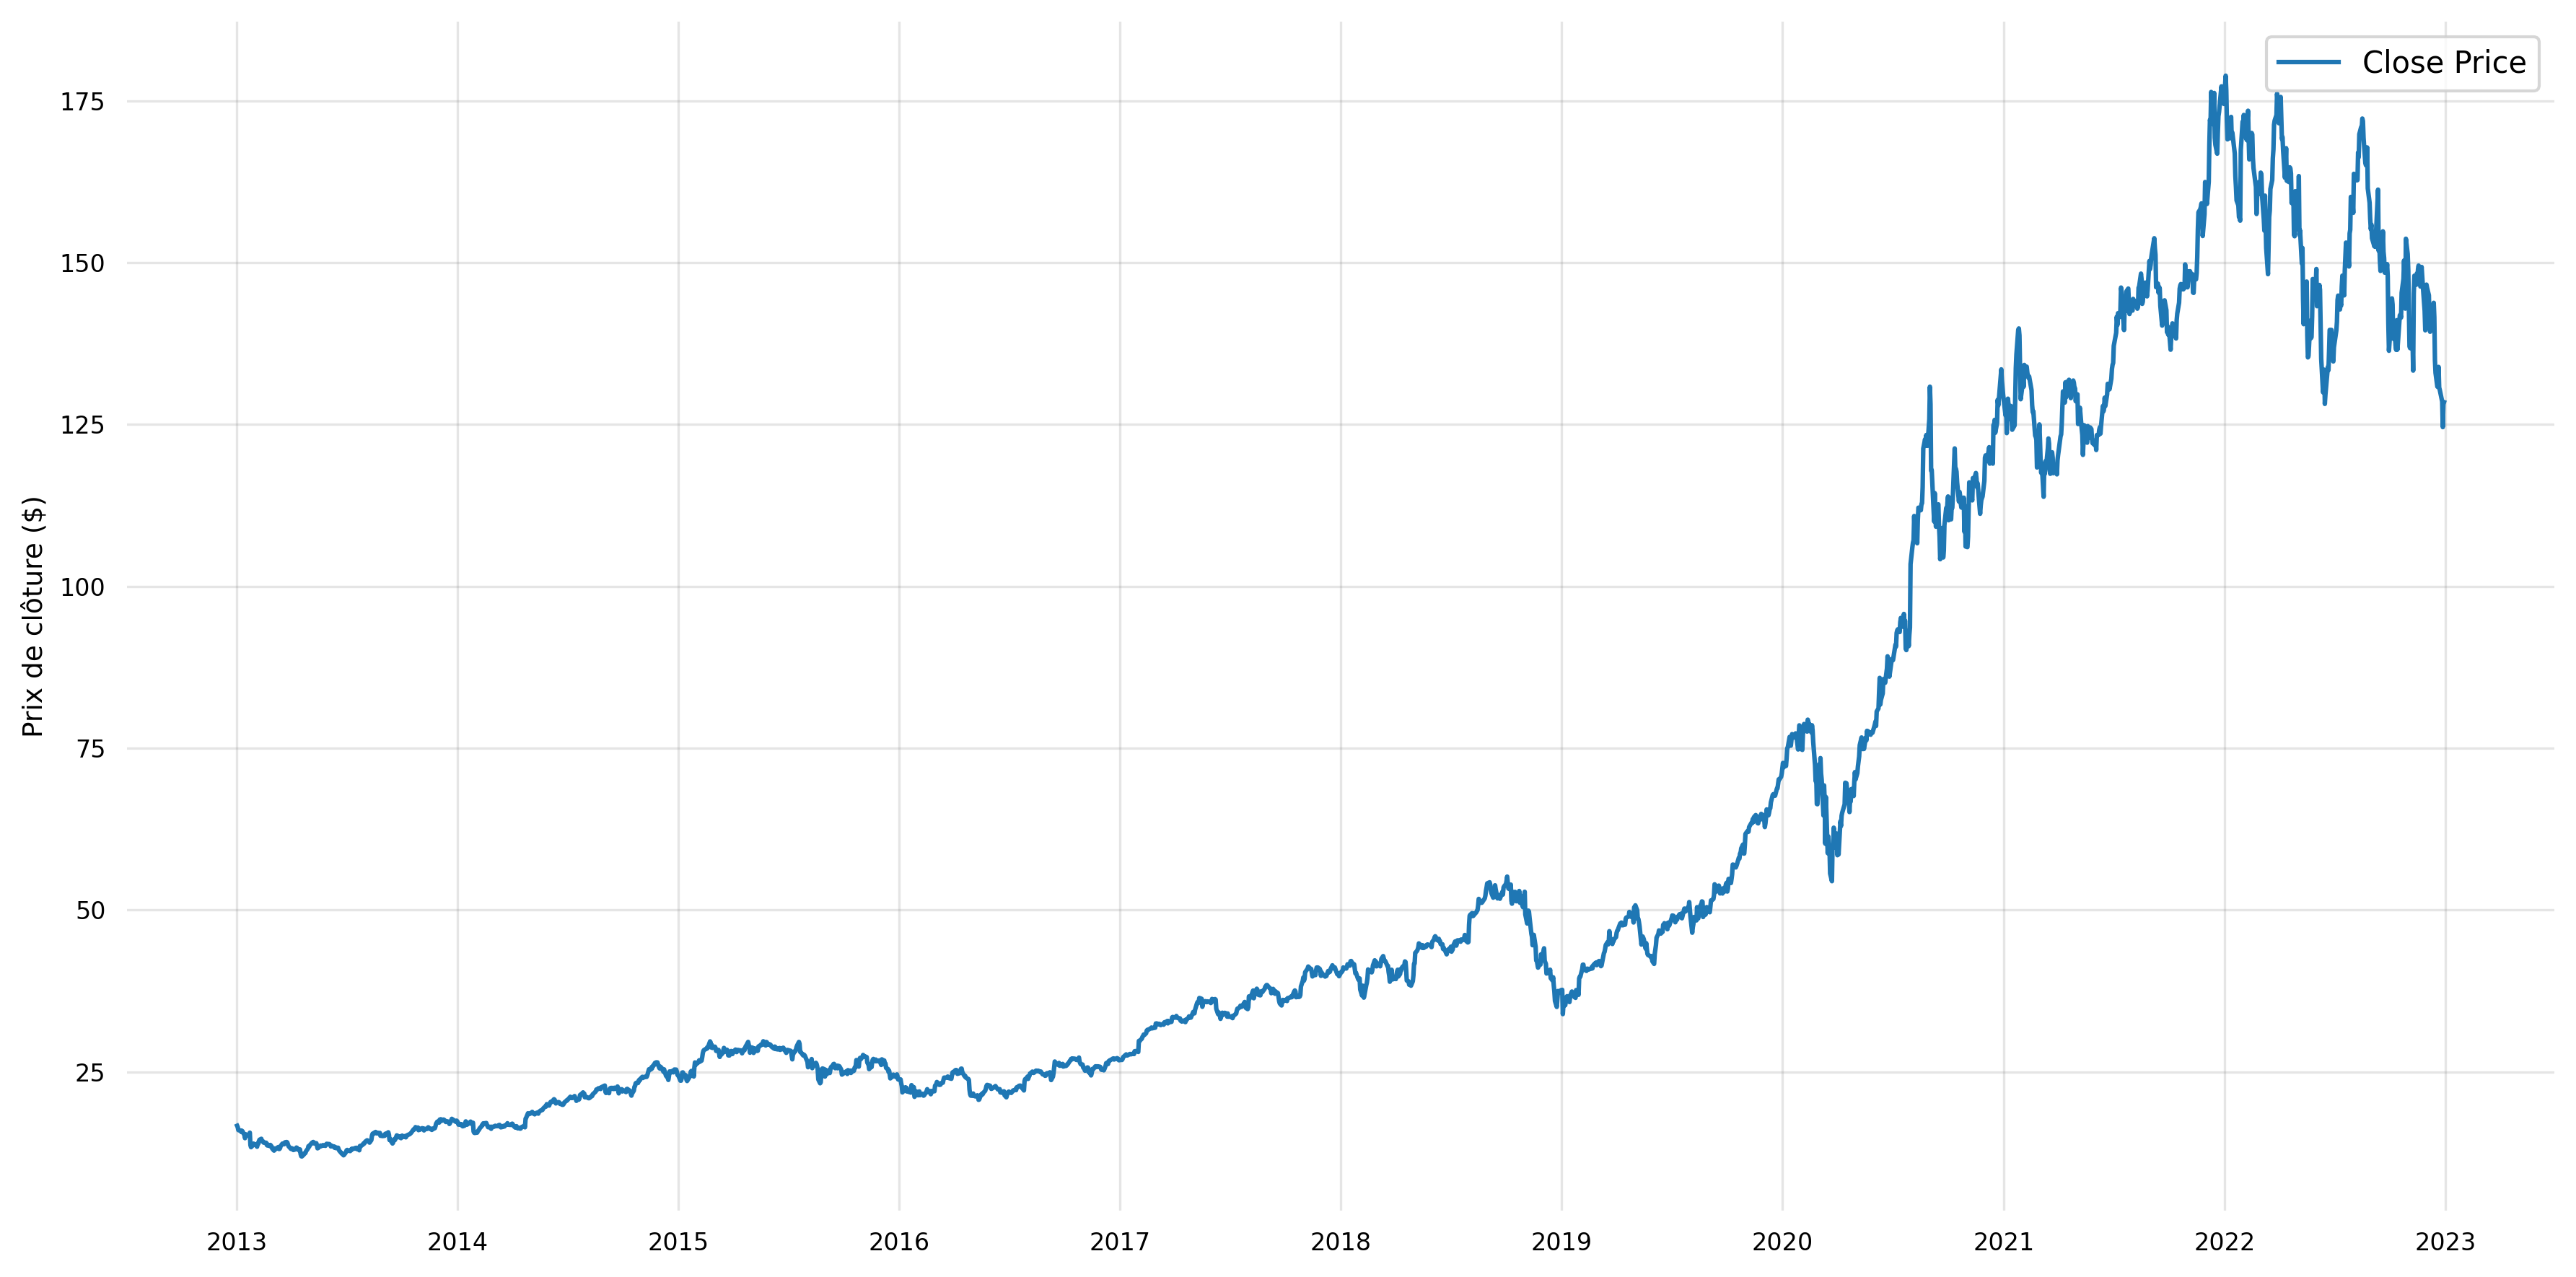

In [4]:
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.ylabel("Prix de clôture ($)")
plt.legend()
plt.tight_layout()
plt.show()

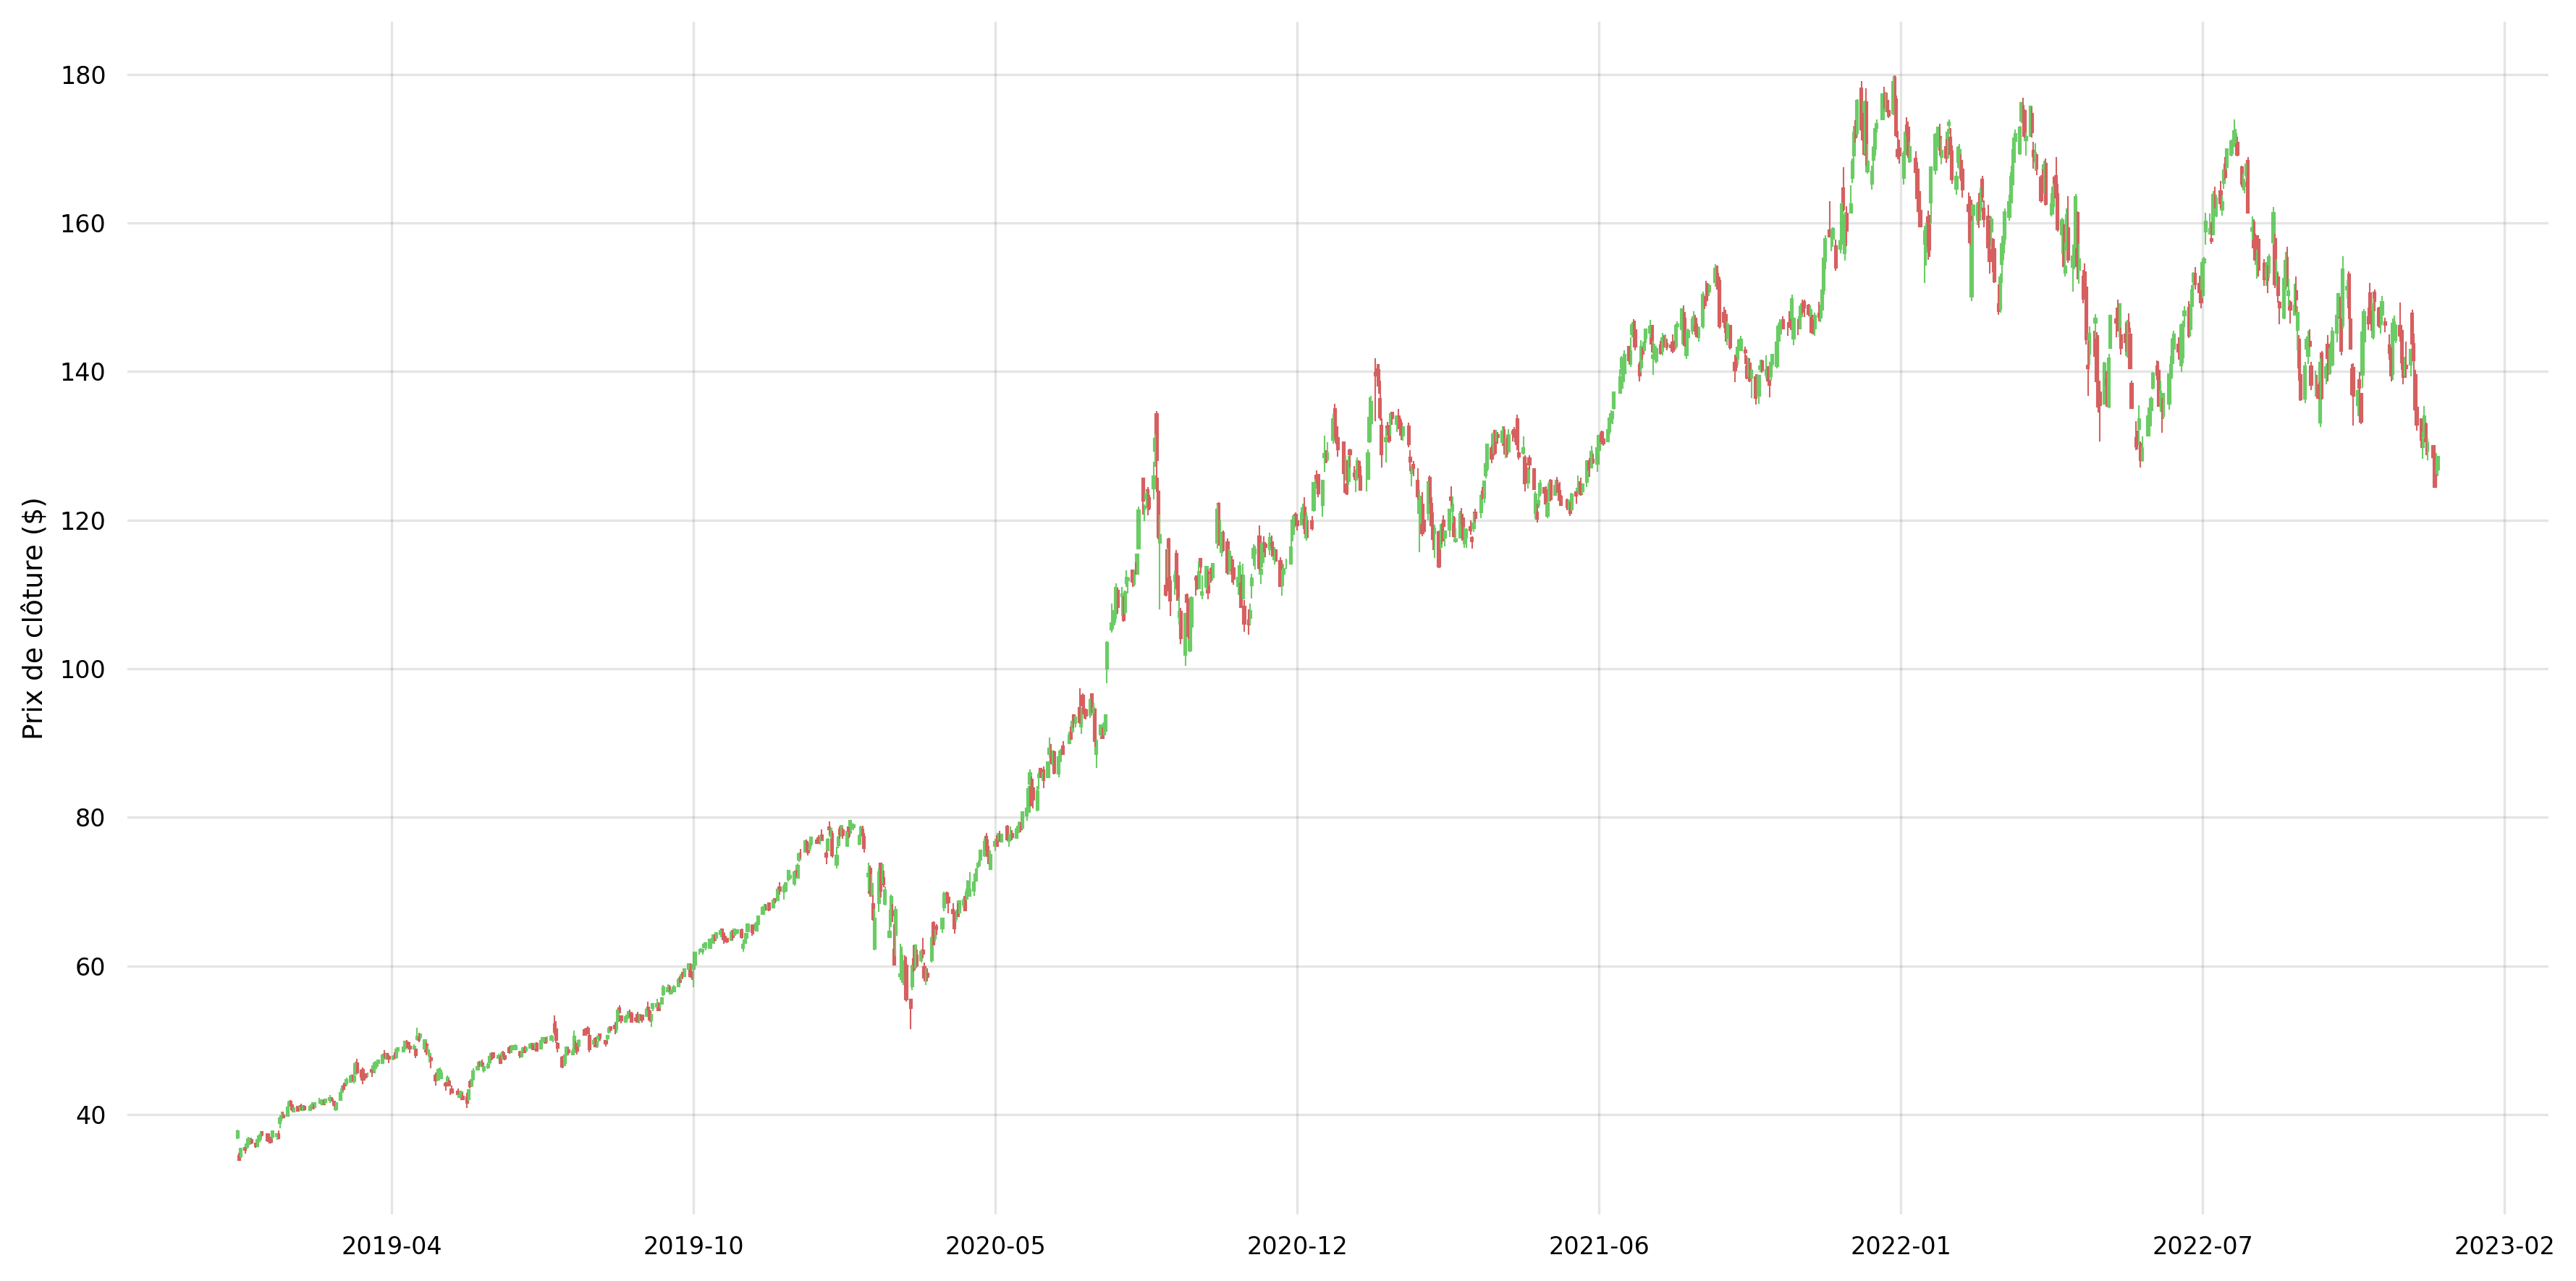

In [ ]:

data['Date_num'] = date2num(data['Date'])
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA2'] = data['Close'].rolling(window=2).mean()
quotes = [tuple(x) for x in data[['Date_num', 'Open', 'High', 'Low', 'Close']].values]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))  # You can set tight layout manually
from mplfinance.original_flavor import candlestick_ohlc
candlestick_ohlc(ax, quotes, width=0.6, colorup='g', colordown='r')

# Format x-axis
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.ylabel("Prix de clôture ($)")
# Tight layout
plt.tight_layout()
plt.show()

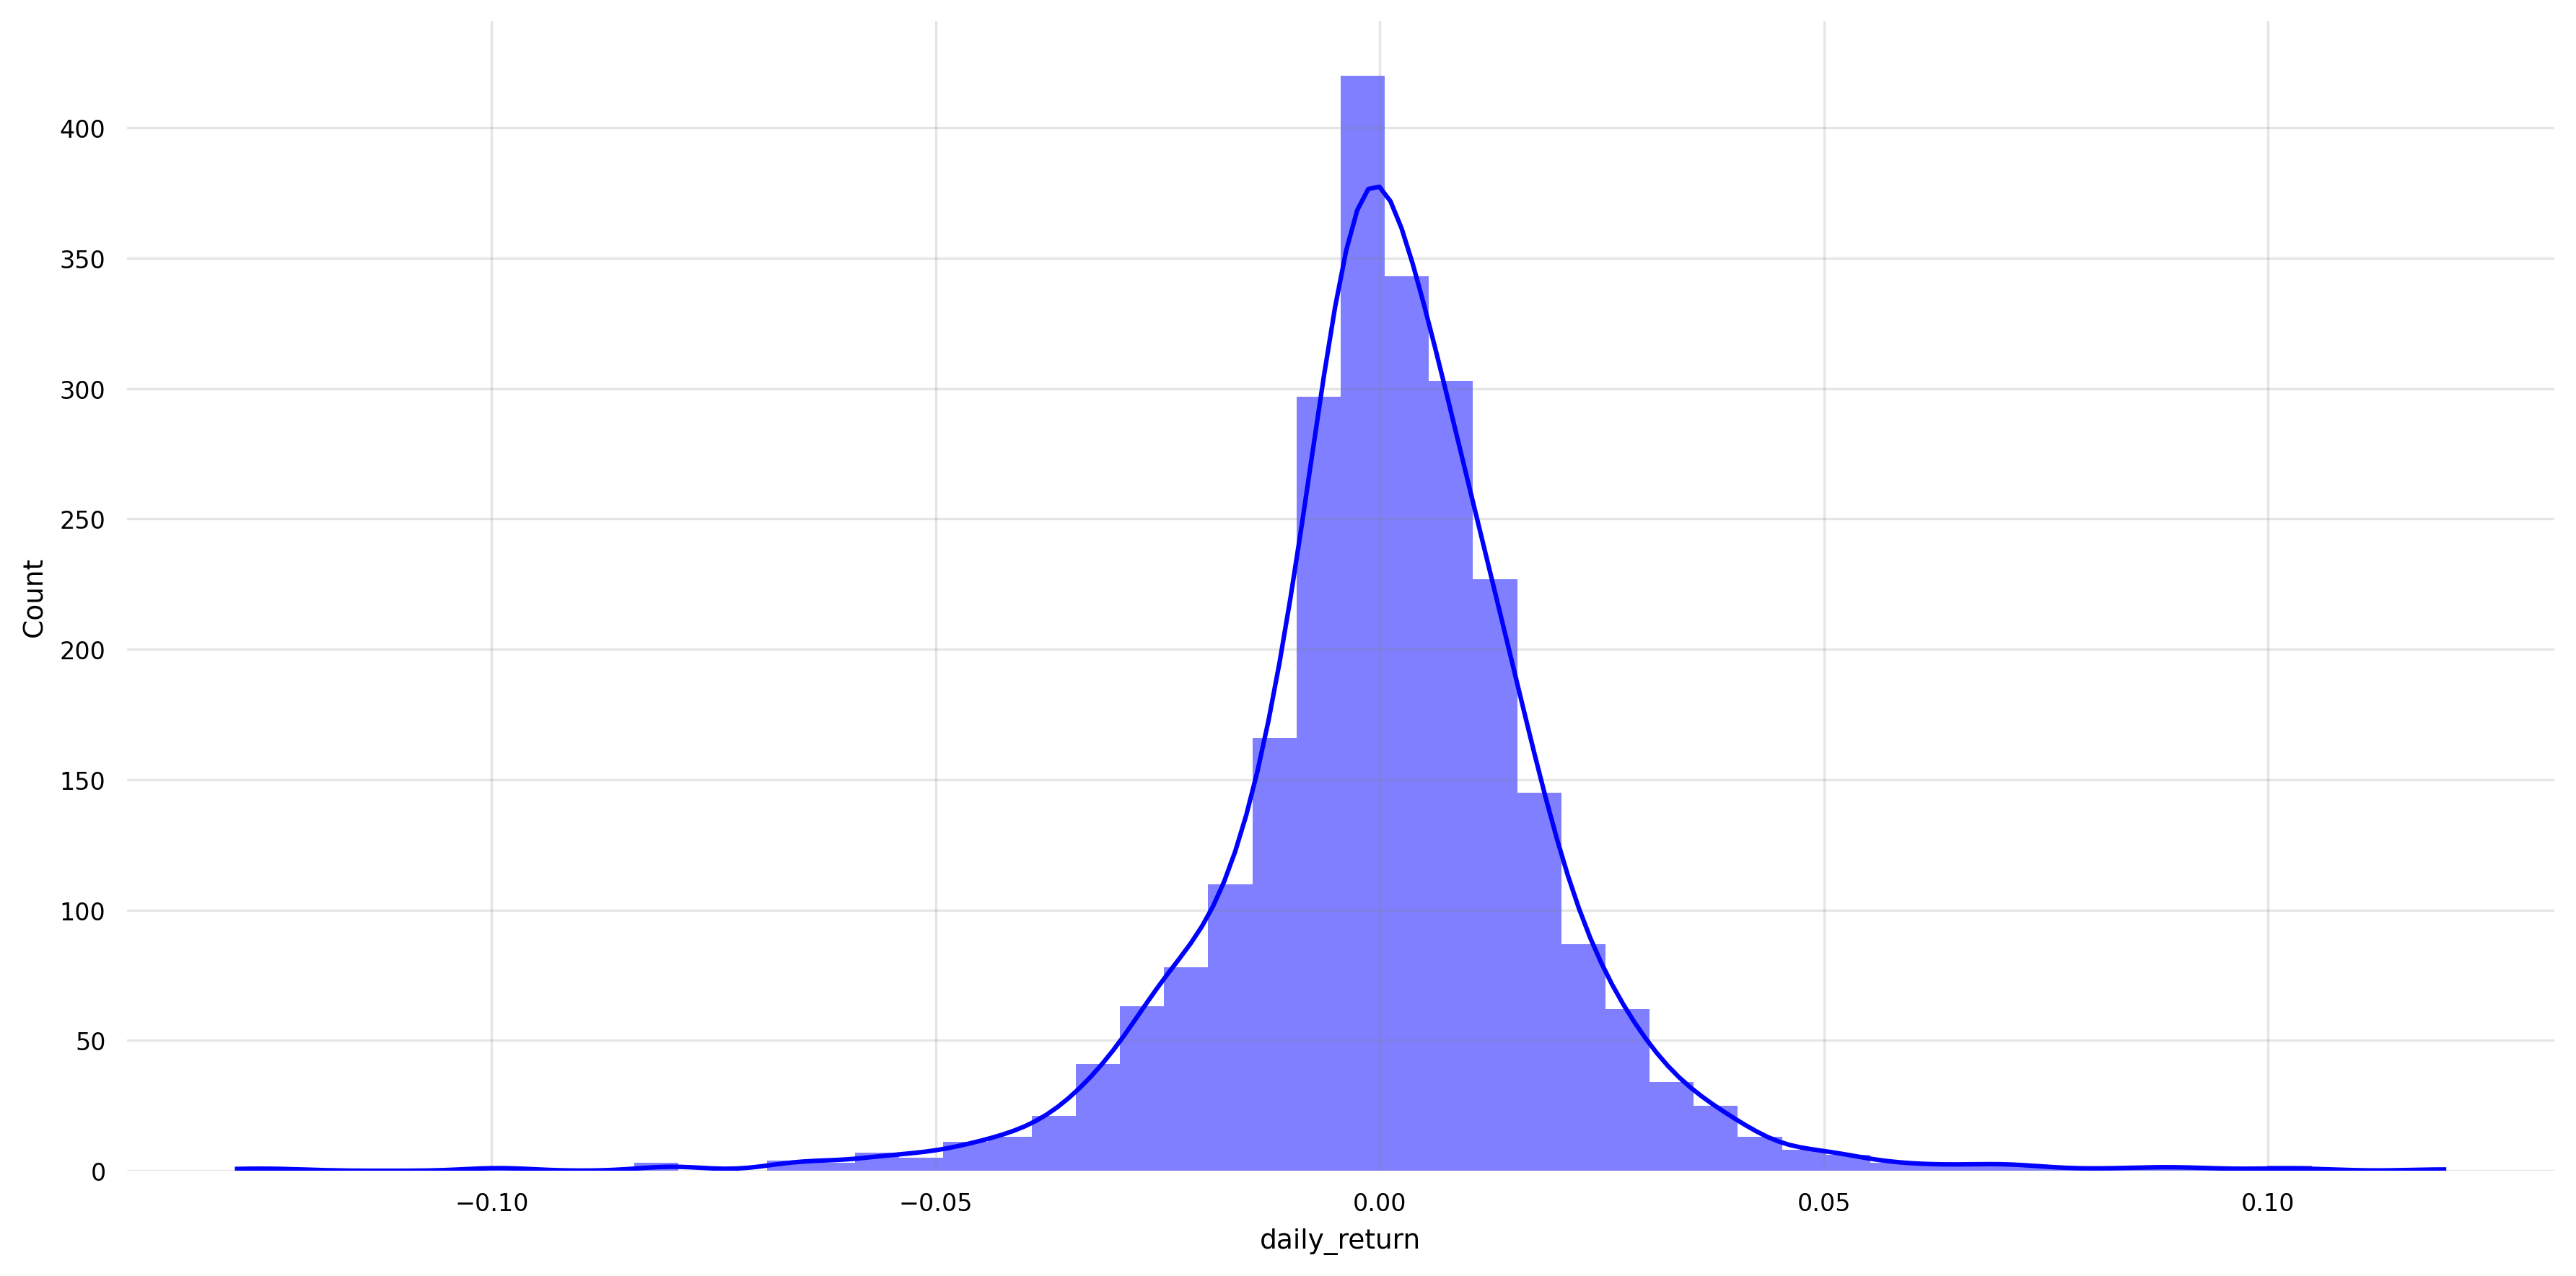

In [25]:
data['daily_return'] = data['Close'].pct_change()
sns.histplot(data['daily_return'], bins=50, kde=True, alpha=0.5, color='blue', edgecolor=None)
plt.tight_layout()

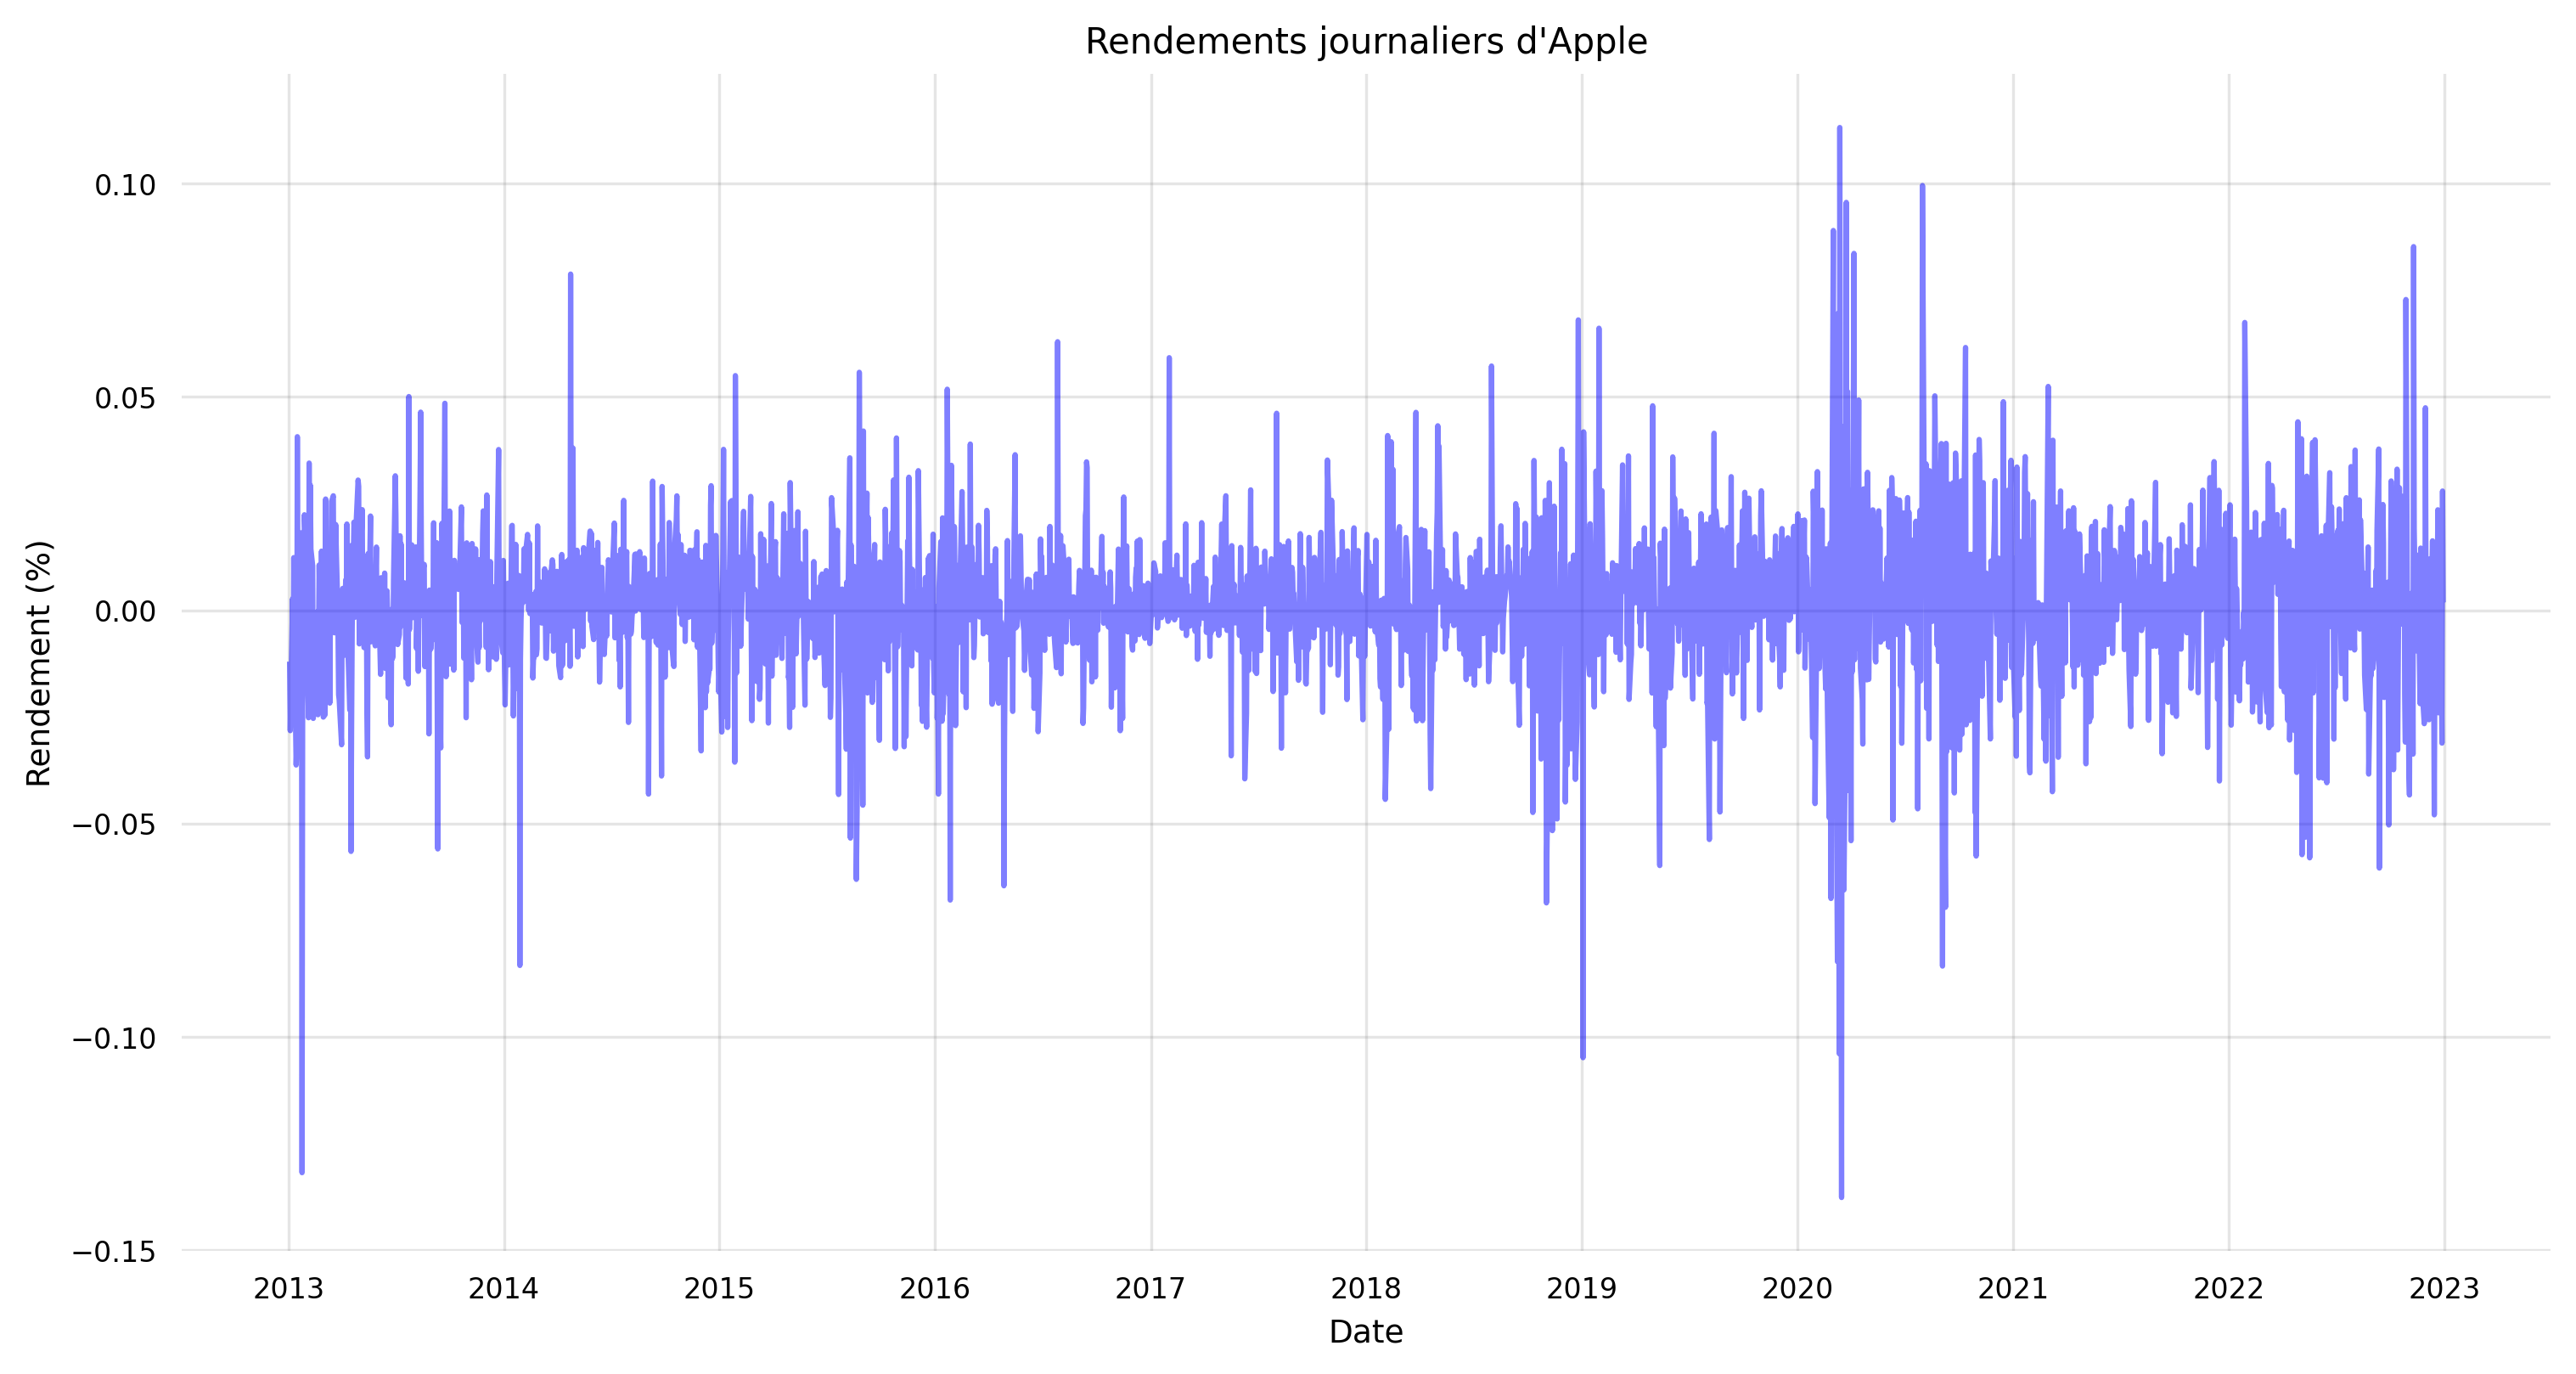

In [55]:
plt.plot(data['Date'], data['Log_Return'], color="blue", alpha=0.5)
plt.title("Rendements journaliers d'Apple")
#plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Rendement (%)")
plt.show()


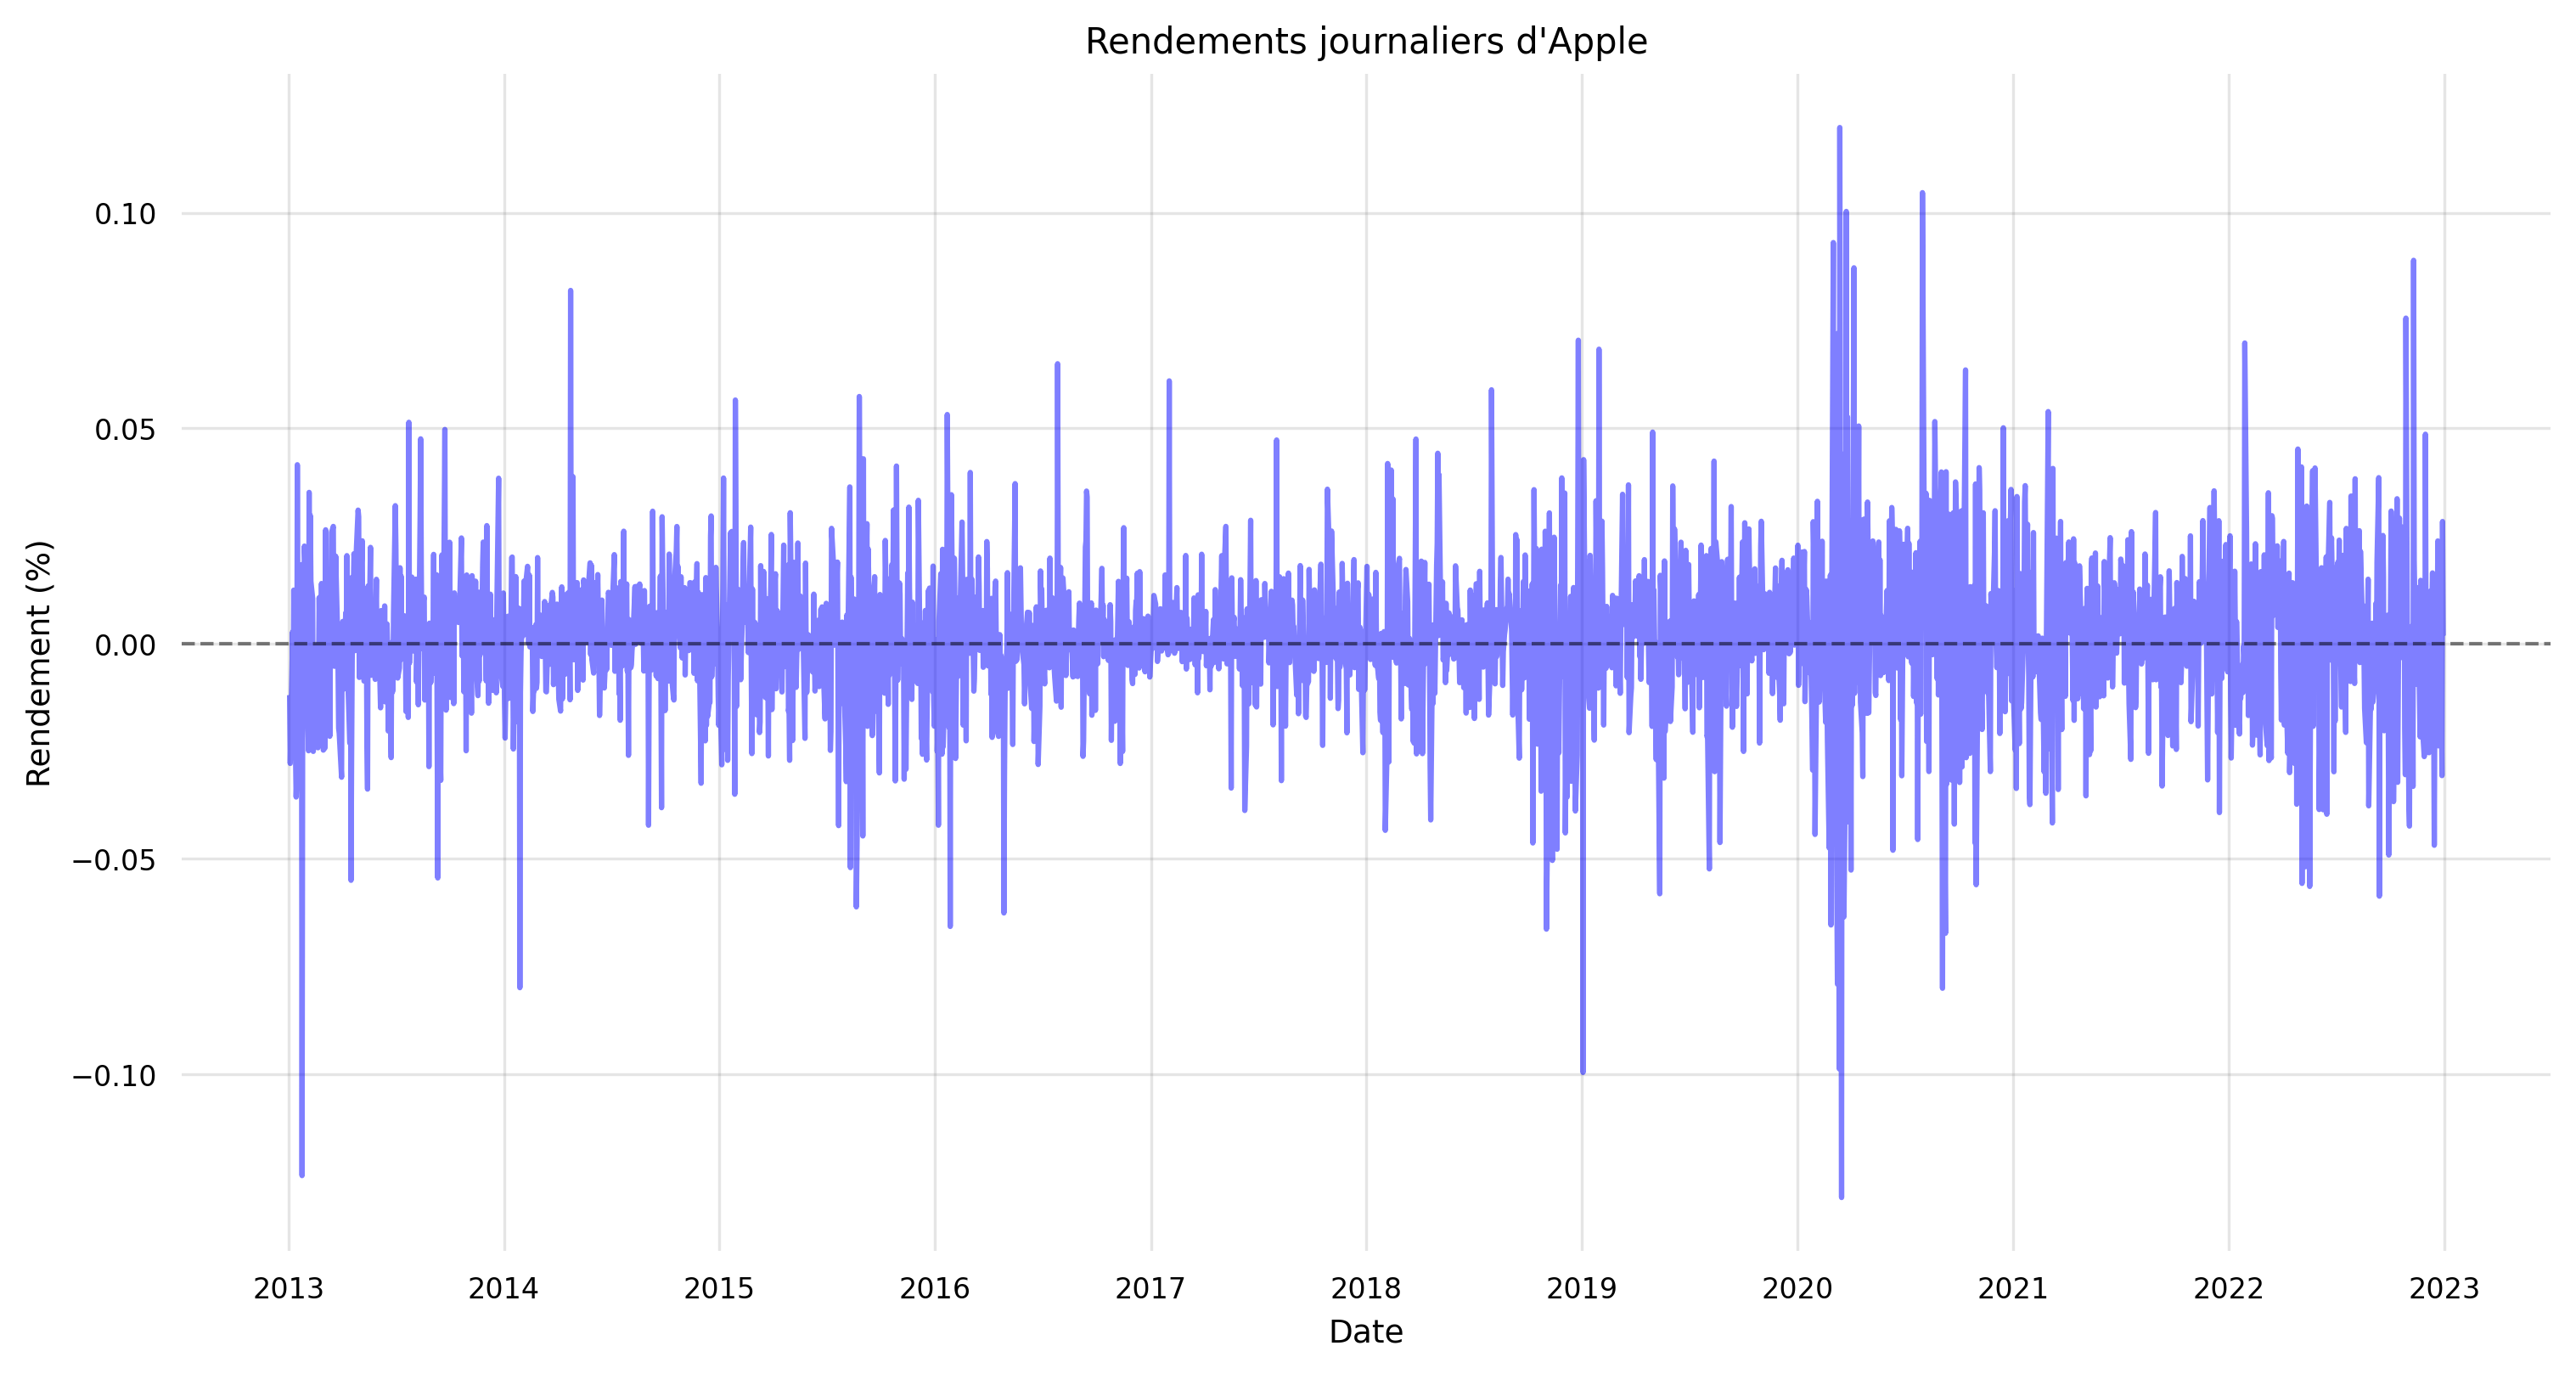

In [26]:
plt.plot(data['Date'], data['daily_return'], color="blue", alpha=0.5)
plt.title("Rendements journaliers d'Apple")
plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Rendement (%)")
plt.show()


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume `data` is your DataFrame
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

# Use Pandas Styler to apply a heatmap style
styled_corr = correlation_matrix.style.background_gradient(cmap='coolwarm')

styled_corr

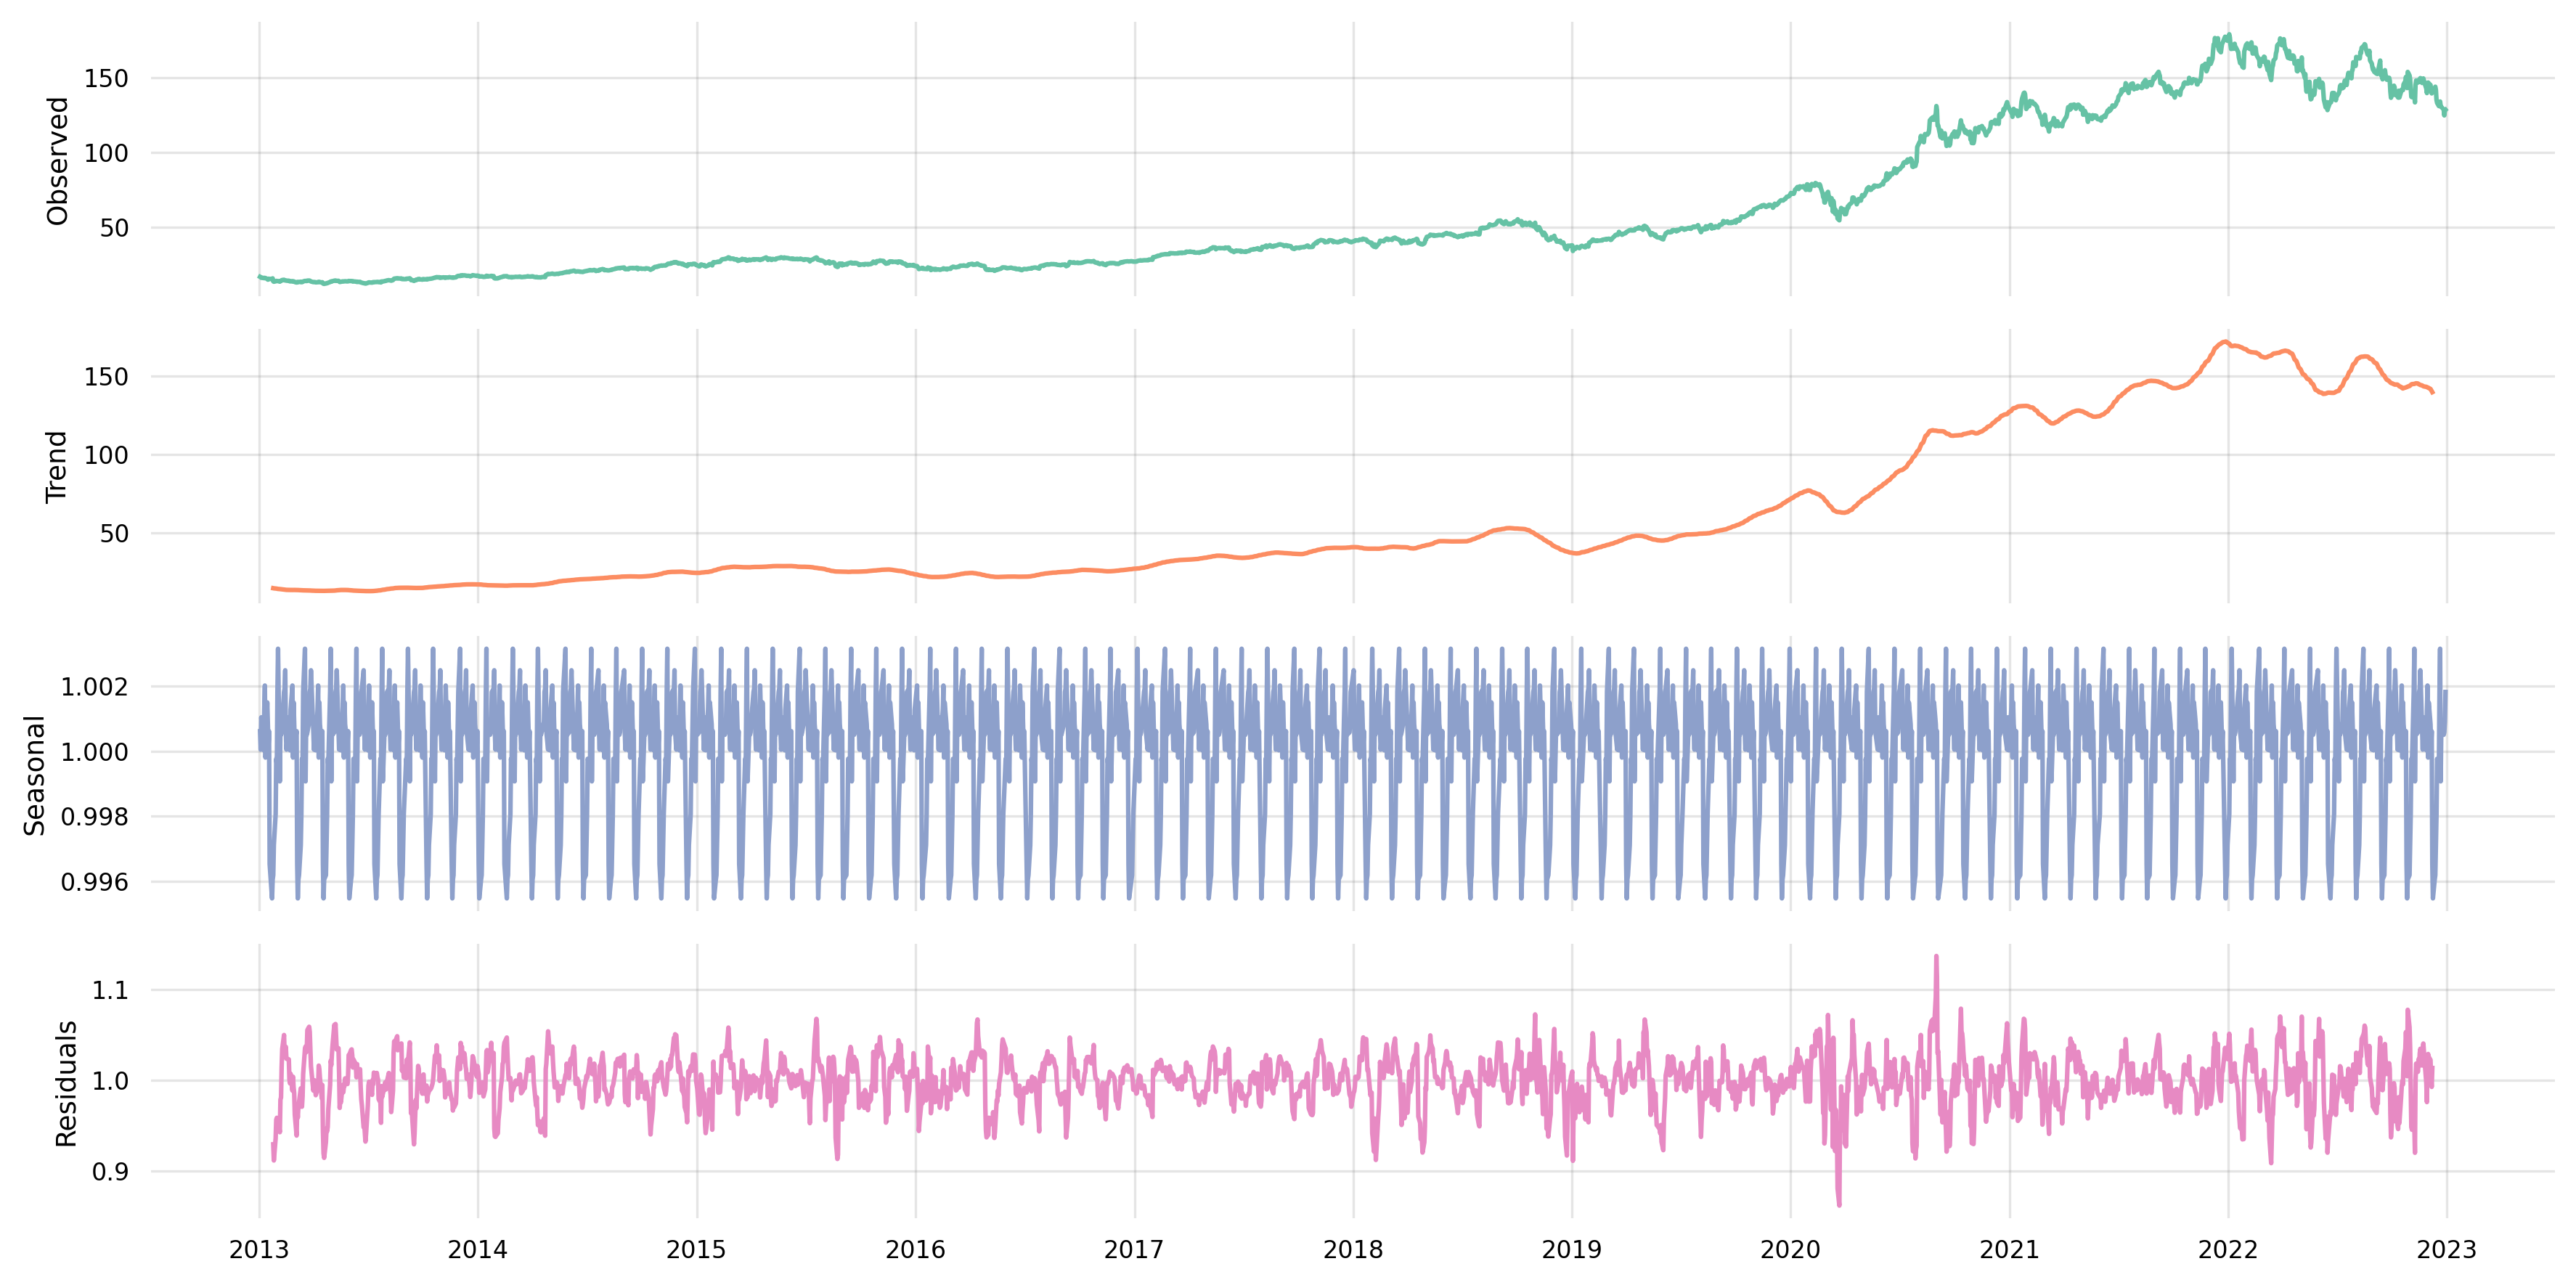

In [27]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Effectuer la décomposition
result = seasonal_decompose(data.set_index('Date')['Close'], model='multiplicative', period=30)

# Initialiser la figure avec 4 sous-graphes
fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)
components = ['observed', 'trend', 'seasonal', 'resid']
titles = ['Observed', 'Trend', 'Seasonal', 'Residuals']
colors = px.colors.qualitative.Plotly[:4]
colors = sns.color_palette("Set2")[:4]
# Tracer chaque composante
for ax, comp, title, color in zip(axes, components, titles, colors):
    series = getattr(result, comp)
    ax.plot(series, label=title, color=color)
    ax.set_ylabel(title)
    ax.grid(True)

# Titre général et ajustement
plt.tight_layout() 
plt.show()


# Tests with GARCH

In [11]:
model = arch_model(data['Log_Return'].dropna(), vol='Garch', p=1, q=1, rescale = False)
results = model.fit(disp='off')
residuals = results.resid
squared_residuals = residuals**2
arch_test = het_arch(squared_residuals)
print(f'ARCH test results:\n')
print(f'LM Statistic: {arch_test[0]}')
print(f'p-value: {arch_test[1]}')
print(f'F Statistic: {arch_test[2]}')
print(f'p-value: {arch_test[3]}')

ARCH test results:

LM Statistic: 204.39012098847314
p-value: 1.9584900248068844e-38
F Statistic: 22.15563073177779
p-value: 3.763216864651667e-40


In [12]:
model = arch_model(data['Log_Return'].dropna(), vol='Arch', p=1, rescale = False)
results = model.fit(disp='off')
print(results.summary())

save_arch_results_to_latex(results, p=1, q=None, model_type="ARCH")

                      Constant Mean - ARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                6578.84
Distribution:                  Normal   AIC:                          -13151.7
Method:            Maximum Likelihood   BIC:                          -13134.2
                                        No. Observations:                 2517
Date:               jeu., mai 22 2025   Df Residuals:                     2516
Time:                        16:11:43   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.1647e-03  3.782e-04      3.079  2.074e-03 [4.

In [13]:
model = arch_model(data['Log_Return'].dropna(), vol='Arch', p=2, rescale = False)
results = model.fit(disp='off')
print(results.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                6630.05
Distribution:                  Normal   AIC:                          -13252.1
Method:            Maximum Likelihood   BIC:                          -13228.8
                                        No. Observations:                 2517
Date:               jeu., mai 22 2025   Df Residuals:                     2516
Time:                        16:11:46   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.2029e-03  3.800e-04      3.165  1.549e-03 [4.

In [15]:
model = arch_model(data['Log_Return'].dropna(), vol='Garch', p=1, q=1, rescale = False)
results = model.fit(disp='off')
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6714.27
Distribution:                  Normal   AIC:                          -13420.5
Method:            Maximum Likelihood   BIC:                          -13397.2
                                        No. Observations:                 2517
Date:               jeu., mai 22 2025   Df Residuals:                     2516
Time:                        16:11:50   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.3664e-03  3.510e-05     38.932      0.000 [1.


Test ADF pour la série d'origine:
ADF Statistic: -0.4629491904666964
p-value: 0.8990461838265786
La série n'est pas stationnaire

Test ADF après différenciation :
ADF Statistic: -10.17682387712462
p-value: 6.857577581371488e-18
La série est stationnaire


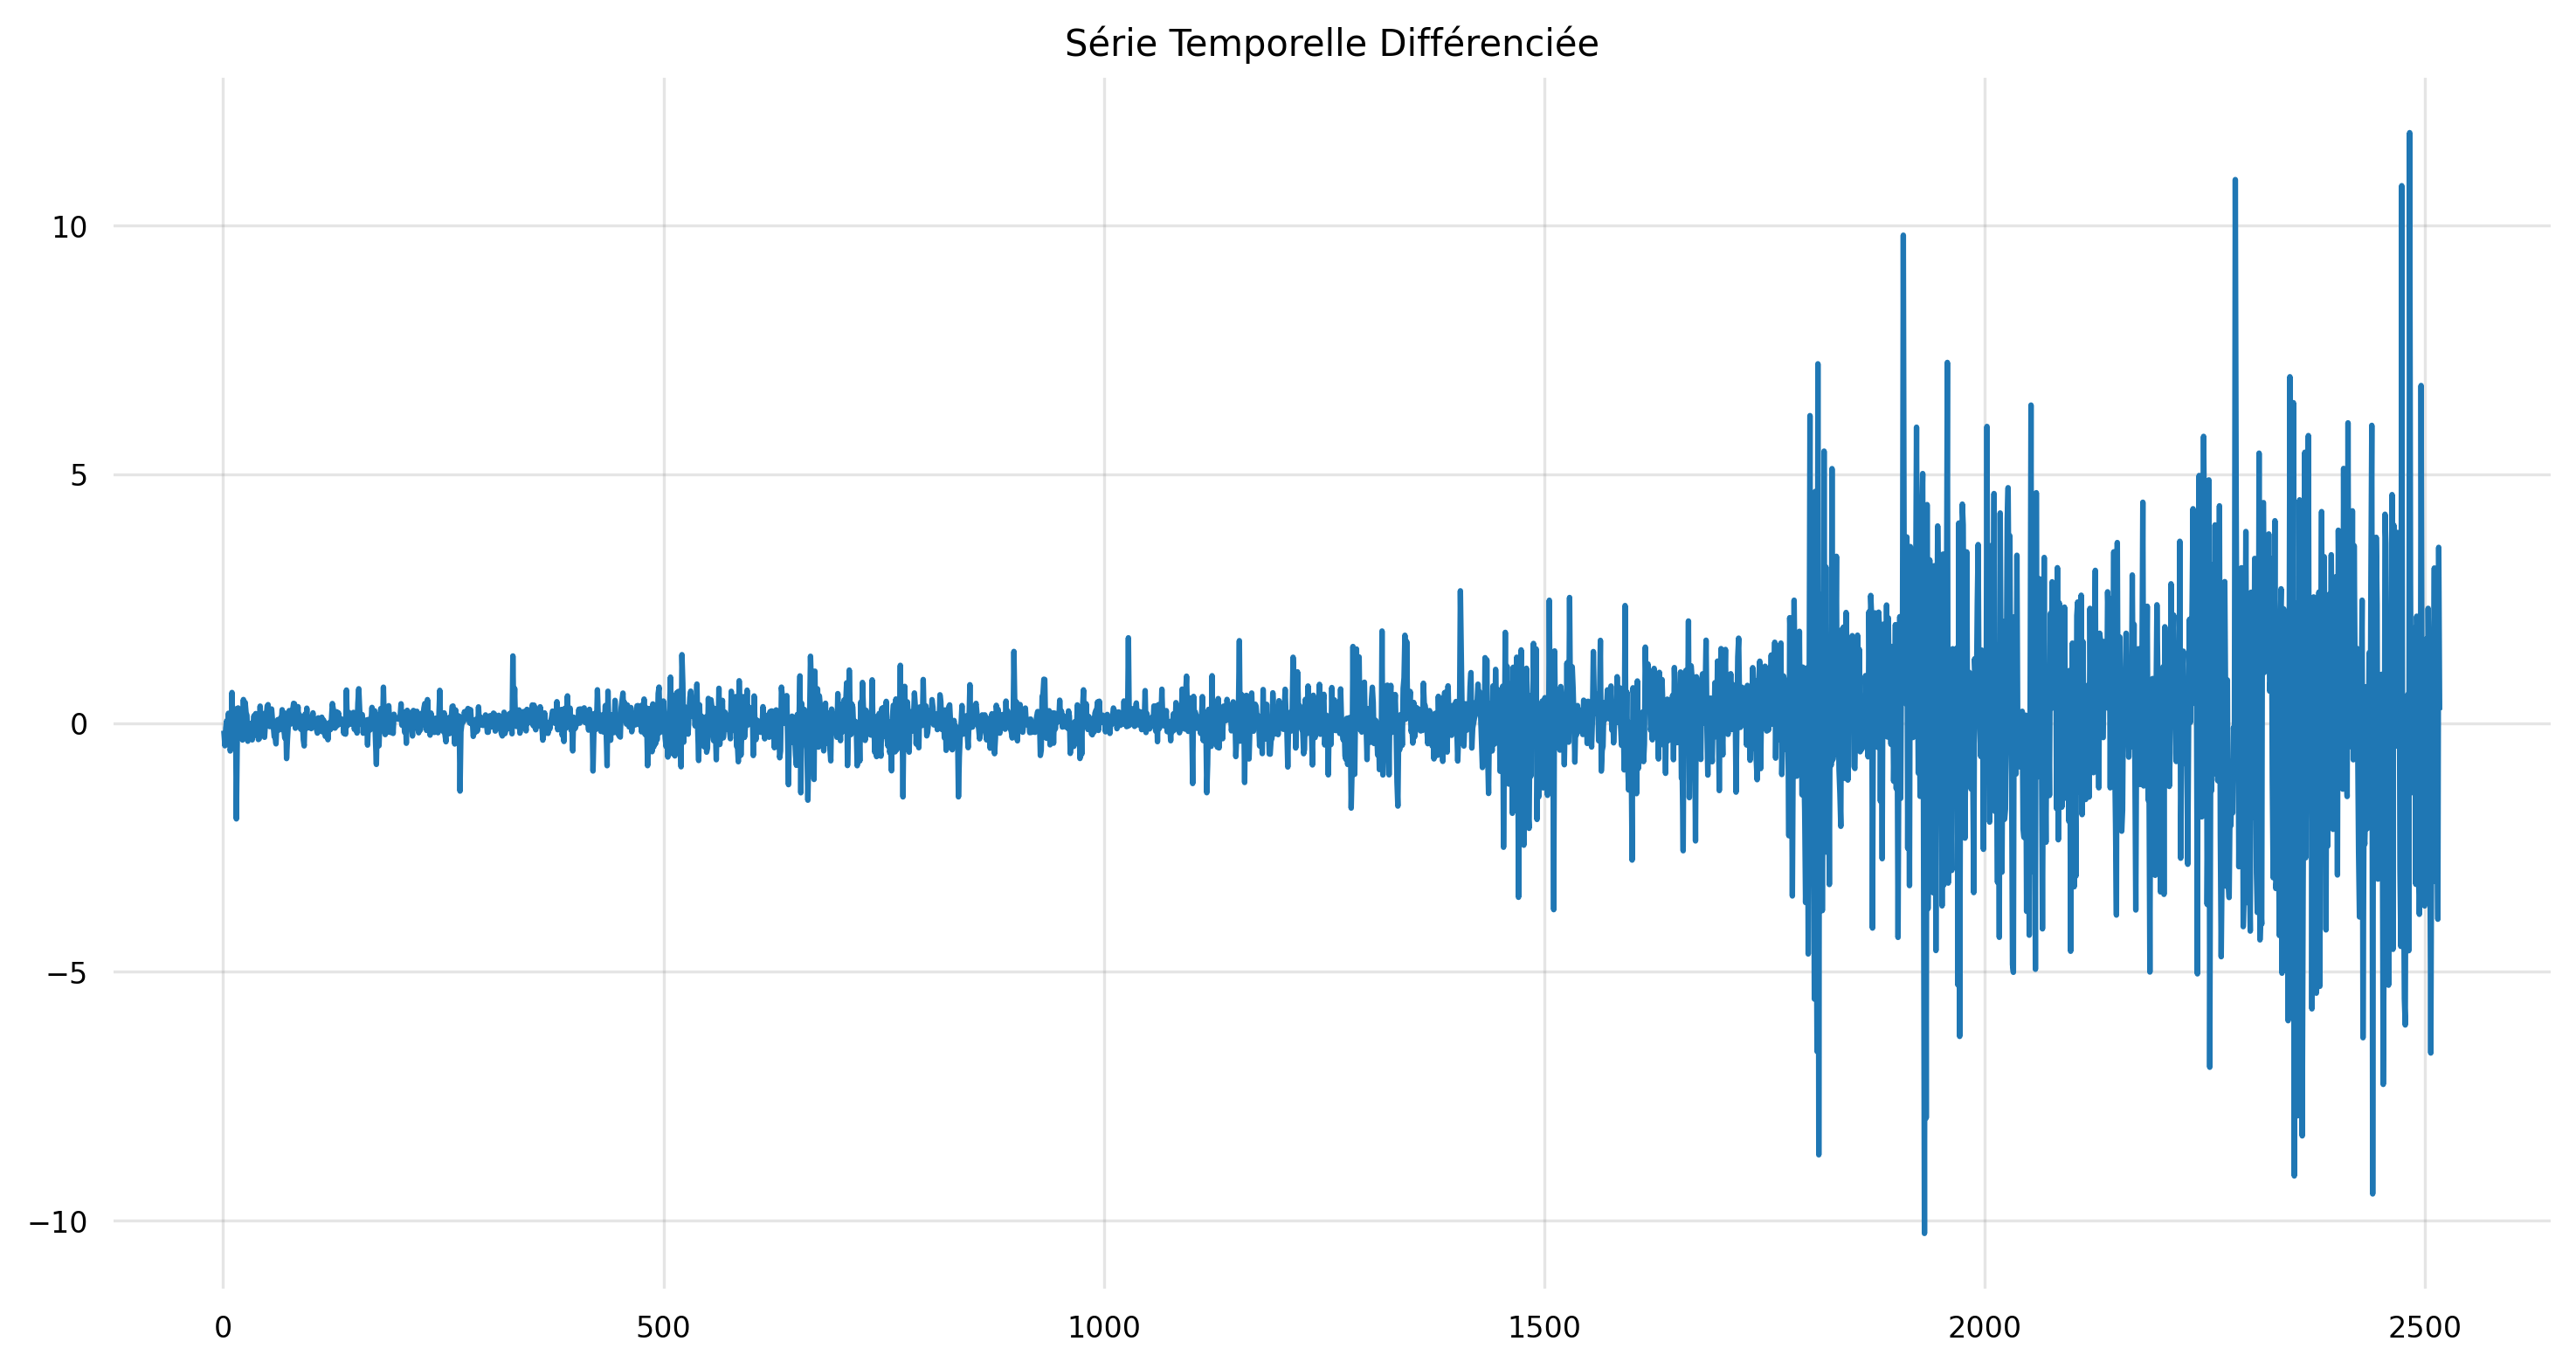

In [22]:
from statsmodels.tsa.stattools import adfuller, acf, pacf


def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("La série est stationnaire")
    else:
        print("La série n'est pas stationnaire")

print("\nTest ADF pour la série d'origine:")
ts = data['Close'].dropna()
adf_test(ts)

# Différenciation pour rendre la série stationnaire
ts_diff = ts.diff().dropna()
print("\nTest ADF après différenciation :")
adf_test(ts_diff)

plt.figure(figsize=(12, 6))
plt.plot(ts_diff, label='Différenciée')
plt.title('Série Temporelle Différenciée')
plt.show()


Test ADF pour la série d'origine:
ADF Statistic: -16.226456340003057
p-value: 3.850609569539182e-29
La série est stationnaire

Test ADF après différenciation :
ADF Statistic: -16.027404100225517
p-value: 6.10990391369429e-29
La série est stationnaire


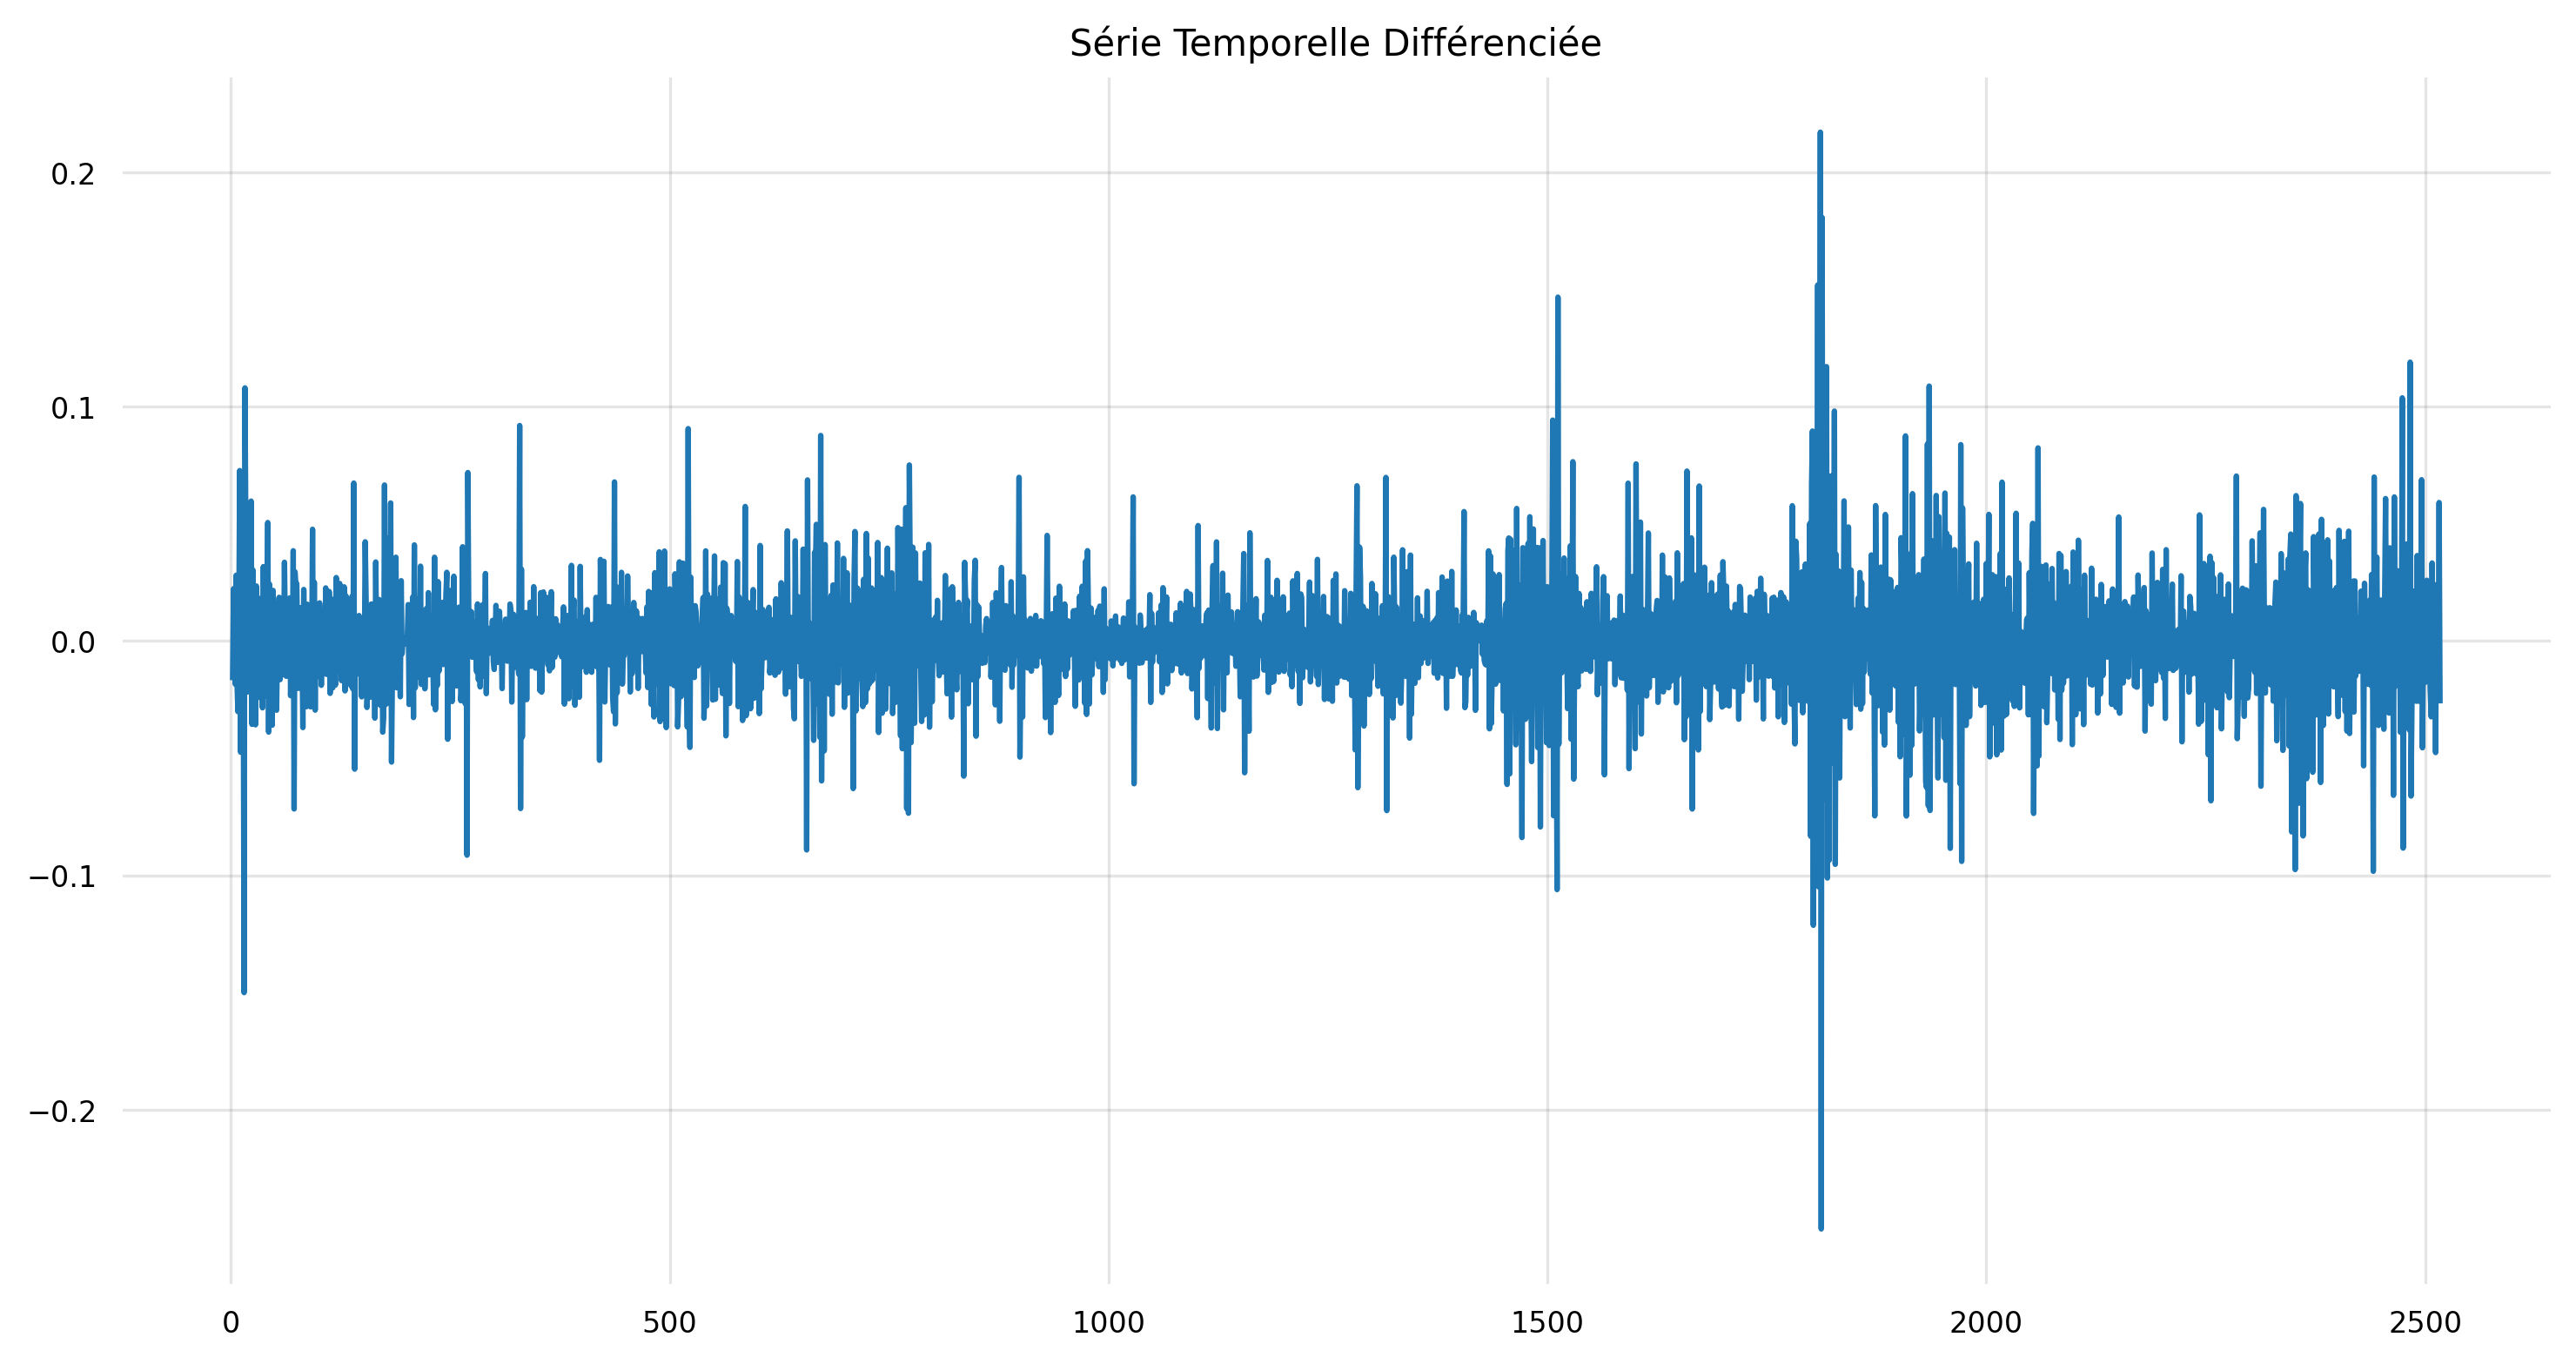

In [27]:
from statsmodels.tsa.stattools import adfuller, acf, pacf


def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("La série est stationnaire")
    else:
        print("La série n'est pas stationnaire")

print("\nTest ADF pour la série d'origine:")
ts = data['Log_Return'].dropna()
adf_test(ts)

# Différenciation pour rendre la série stationnaire
ts_diff = ts.diff().dropna()
print("\nTest ADF après différenciation :")
adf_test(ts_diff)

plt.figure(figsize=(12, 6))
plt.plot(ts_diff, label='Différenciée')
plt.title('Série Temporelle Différenciée')
plt.show()

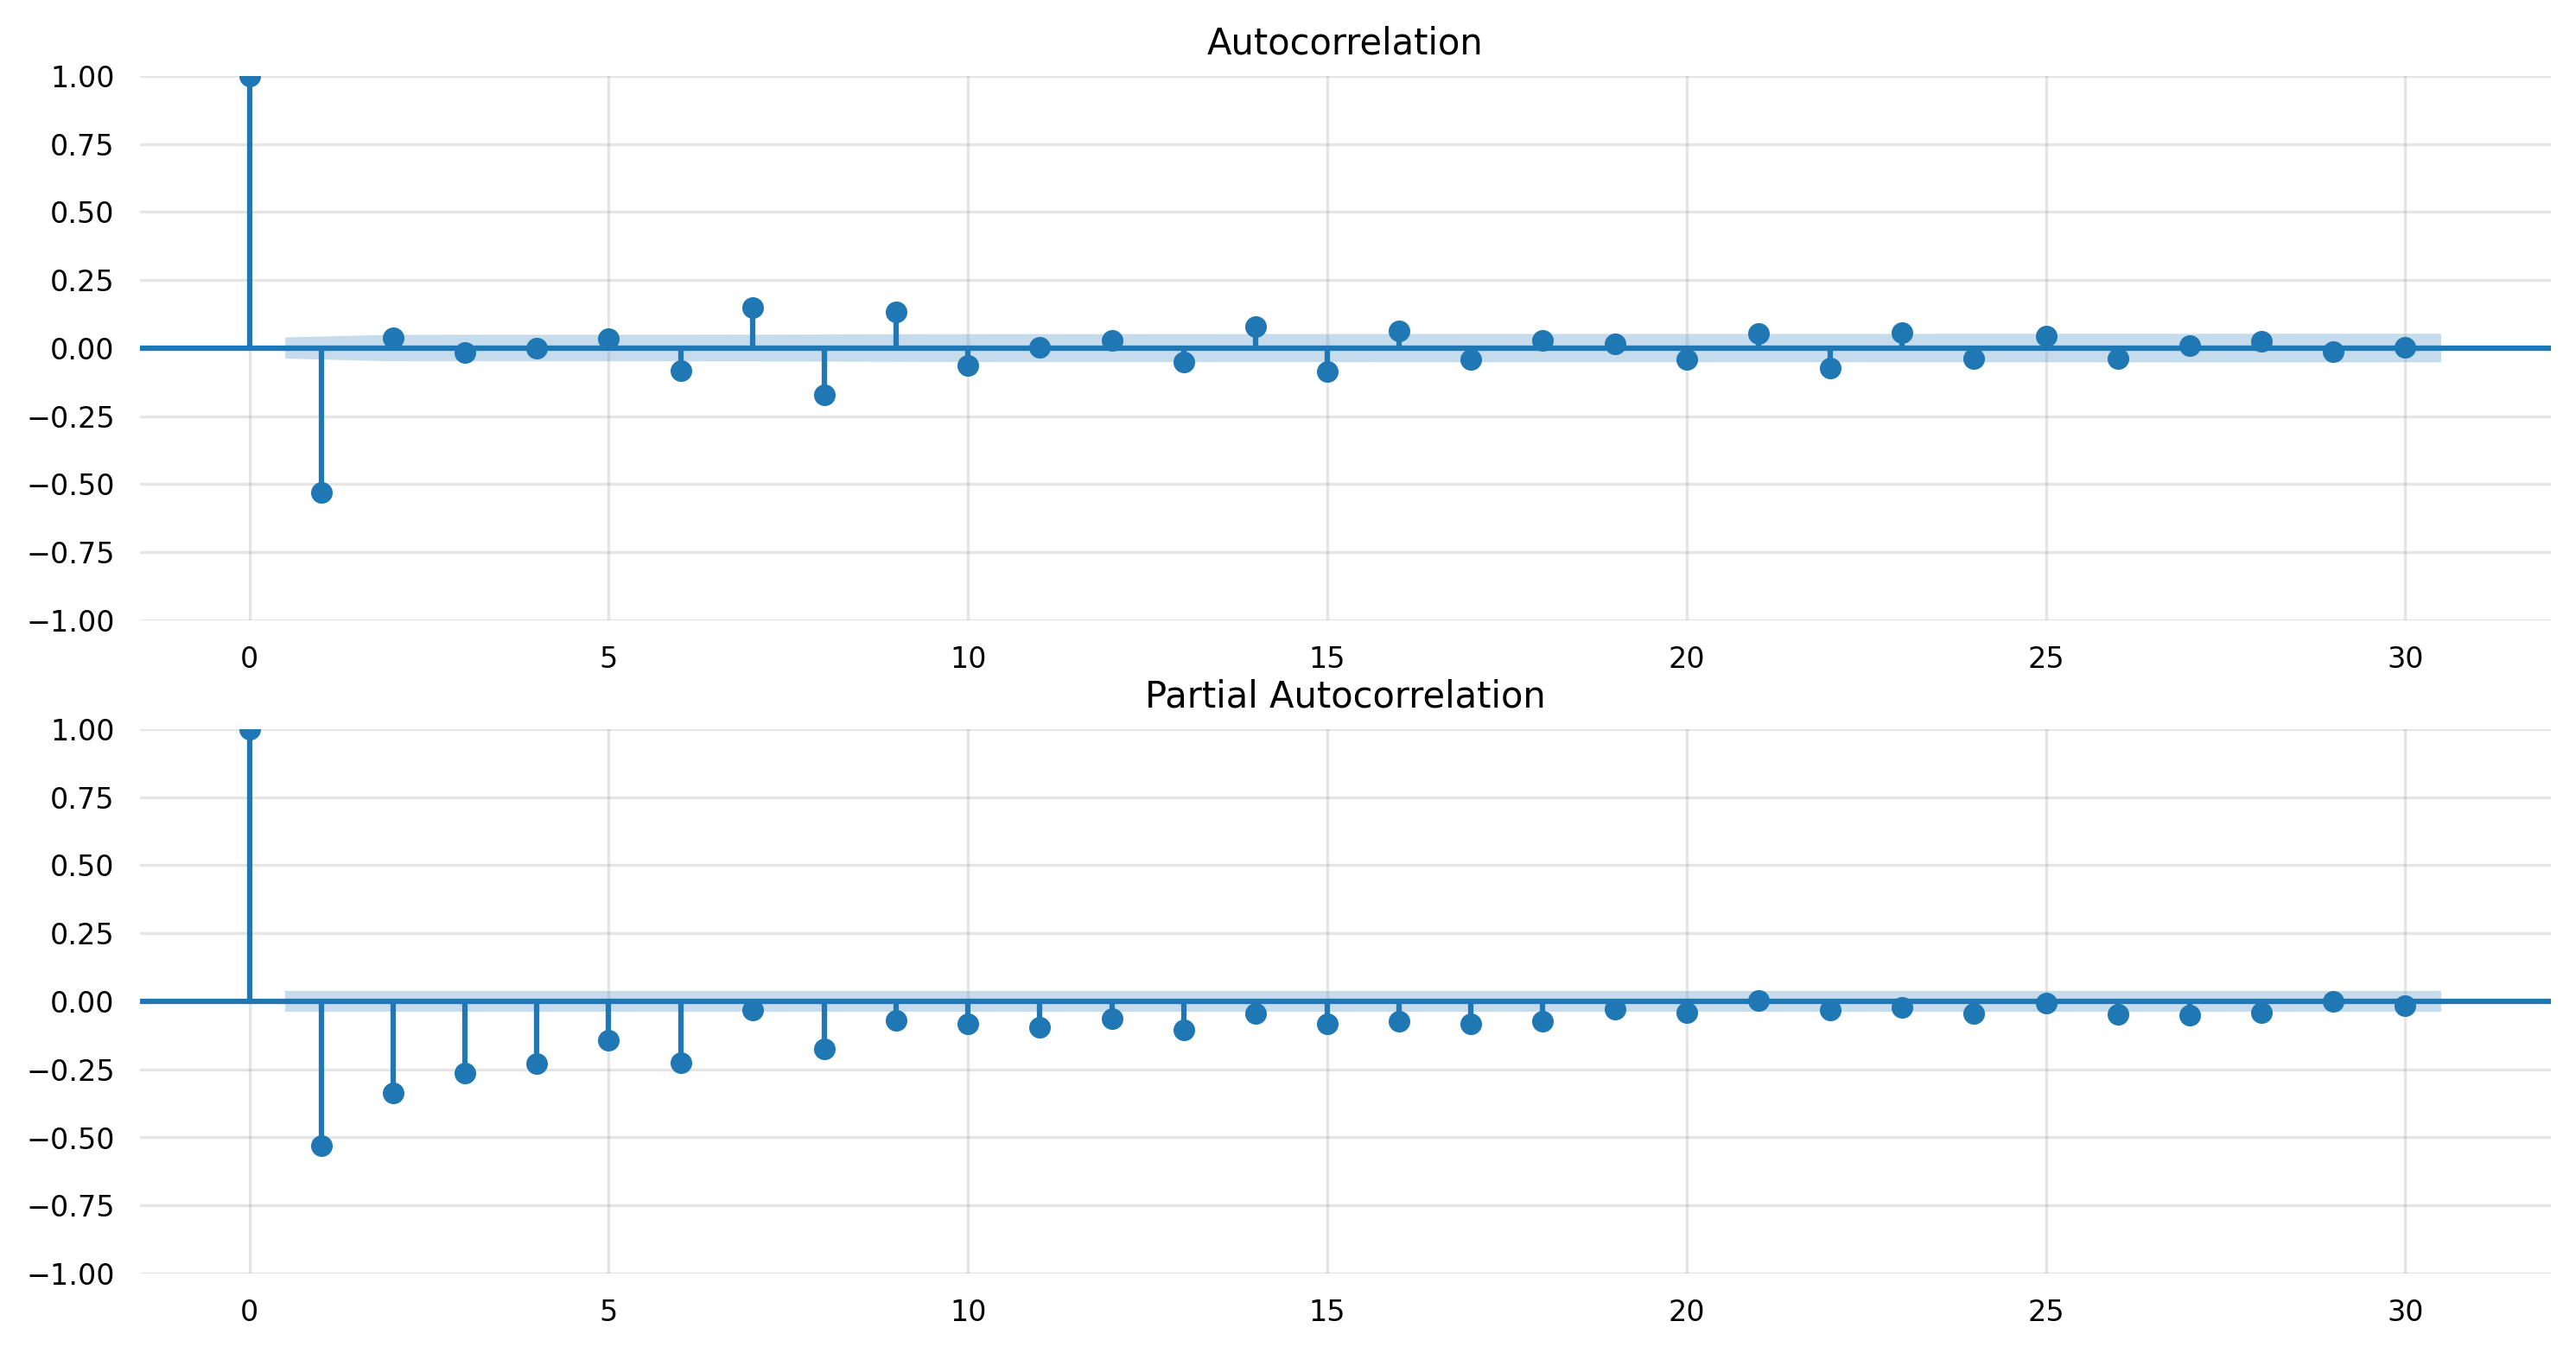

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(ts_diff, lags=30, ax=plt.gca())
plt.subplot(212)
plot_pacf(ts_diff, lags=30, ax=plt.gca())
plt.show()

In [4]:
stock_prices = data['Close']
stock_prices = stock_prices.dropna()
train_size = int(len(stock_prices) * 0.8)
train_data, test_data = stock_prices[:train_size], stock_prices[train_size:]

In [5]:
test_data

2014    129.609100
2015    126.405235
2016    127.968063
2017    123.660484
2018    127.880165
           ...    
2513    130.344498
2514    128.535507
2515    124.591385
2516    128.120346
2517    128.436676
Name: Close, Length: 504, dtype: float64

In [8]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

stock_prices = data.set_index('Date')['Close'].dropna()
train_size = int(len(stock_prices) * 0.8)
train_data, test_data = stock_prices[:train_size], stock_prices[train_size:]

train_ar = train_data.values
test_ar = test_data.values

model = auto_arima(train_ar, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore")
model.fit(train_ar)

predictions = []

for t in range(len(test_ar)):
    yhat = model.predict(n_periods=1)[0]
    predictions.append(yhat)

    model.update(test_ar[t:t+1])

mse = mean_squared_error(test_ar, predictions)
smape = smape_kun(test_ar, predictions)

print(f'Testing Mean Squared Error: {mse:.3f}')
print(f'Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.3f}')

Testing Mean Squared Error: 9.467
Symmetric Mean Absolute Percentage Error (sMAPE): 1.623


In [9]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2518
Model:               SARIMAX(5, 2, 0)   Log Likelihood               -4878.243
Date:               dim., 25 mai 2025   AIC                           9768.485
Time:                        23:57:28   BIC                           9803.468
Sample:                             0   HQIC                          9781.181
                               - 2518                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8900      0.010    -86.175      0.000      -0.910      -0.870
ar.L2         -0.7342      0.014    -54.284      0.000      -0.761      -0.708
ar.L3         -0.5758      0.014    -41.632      0.0

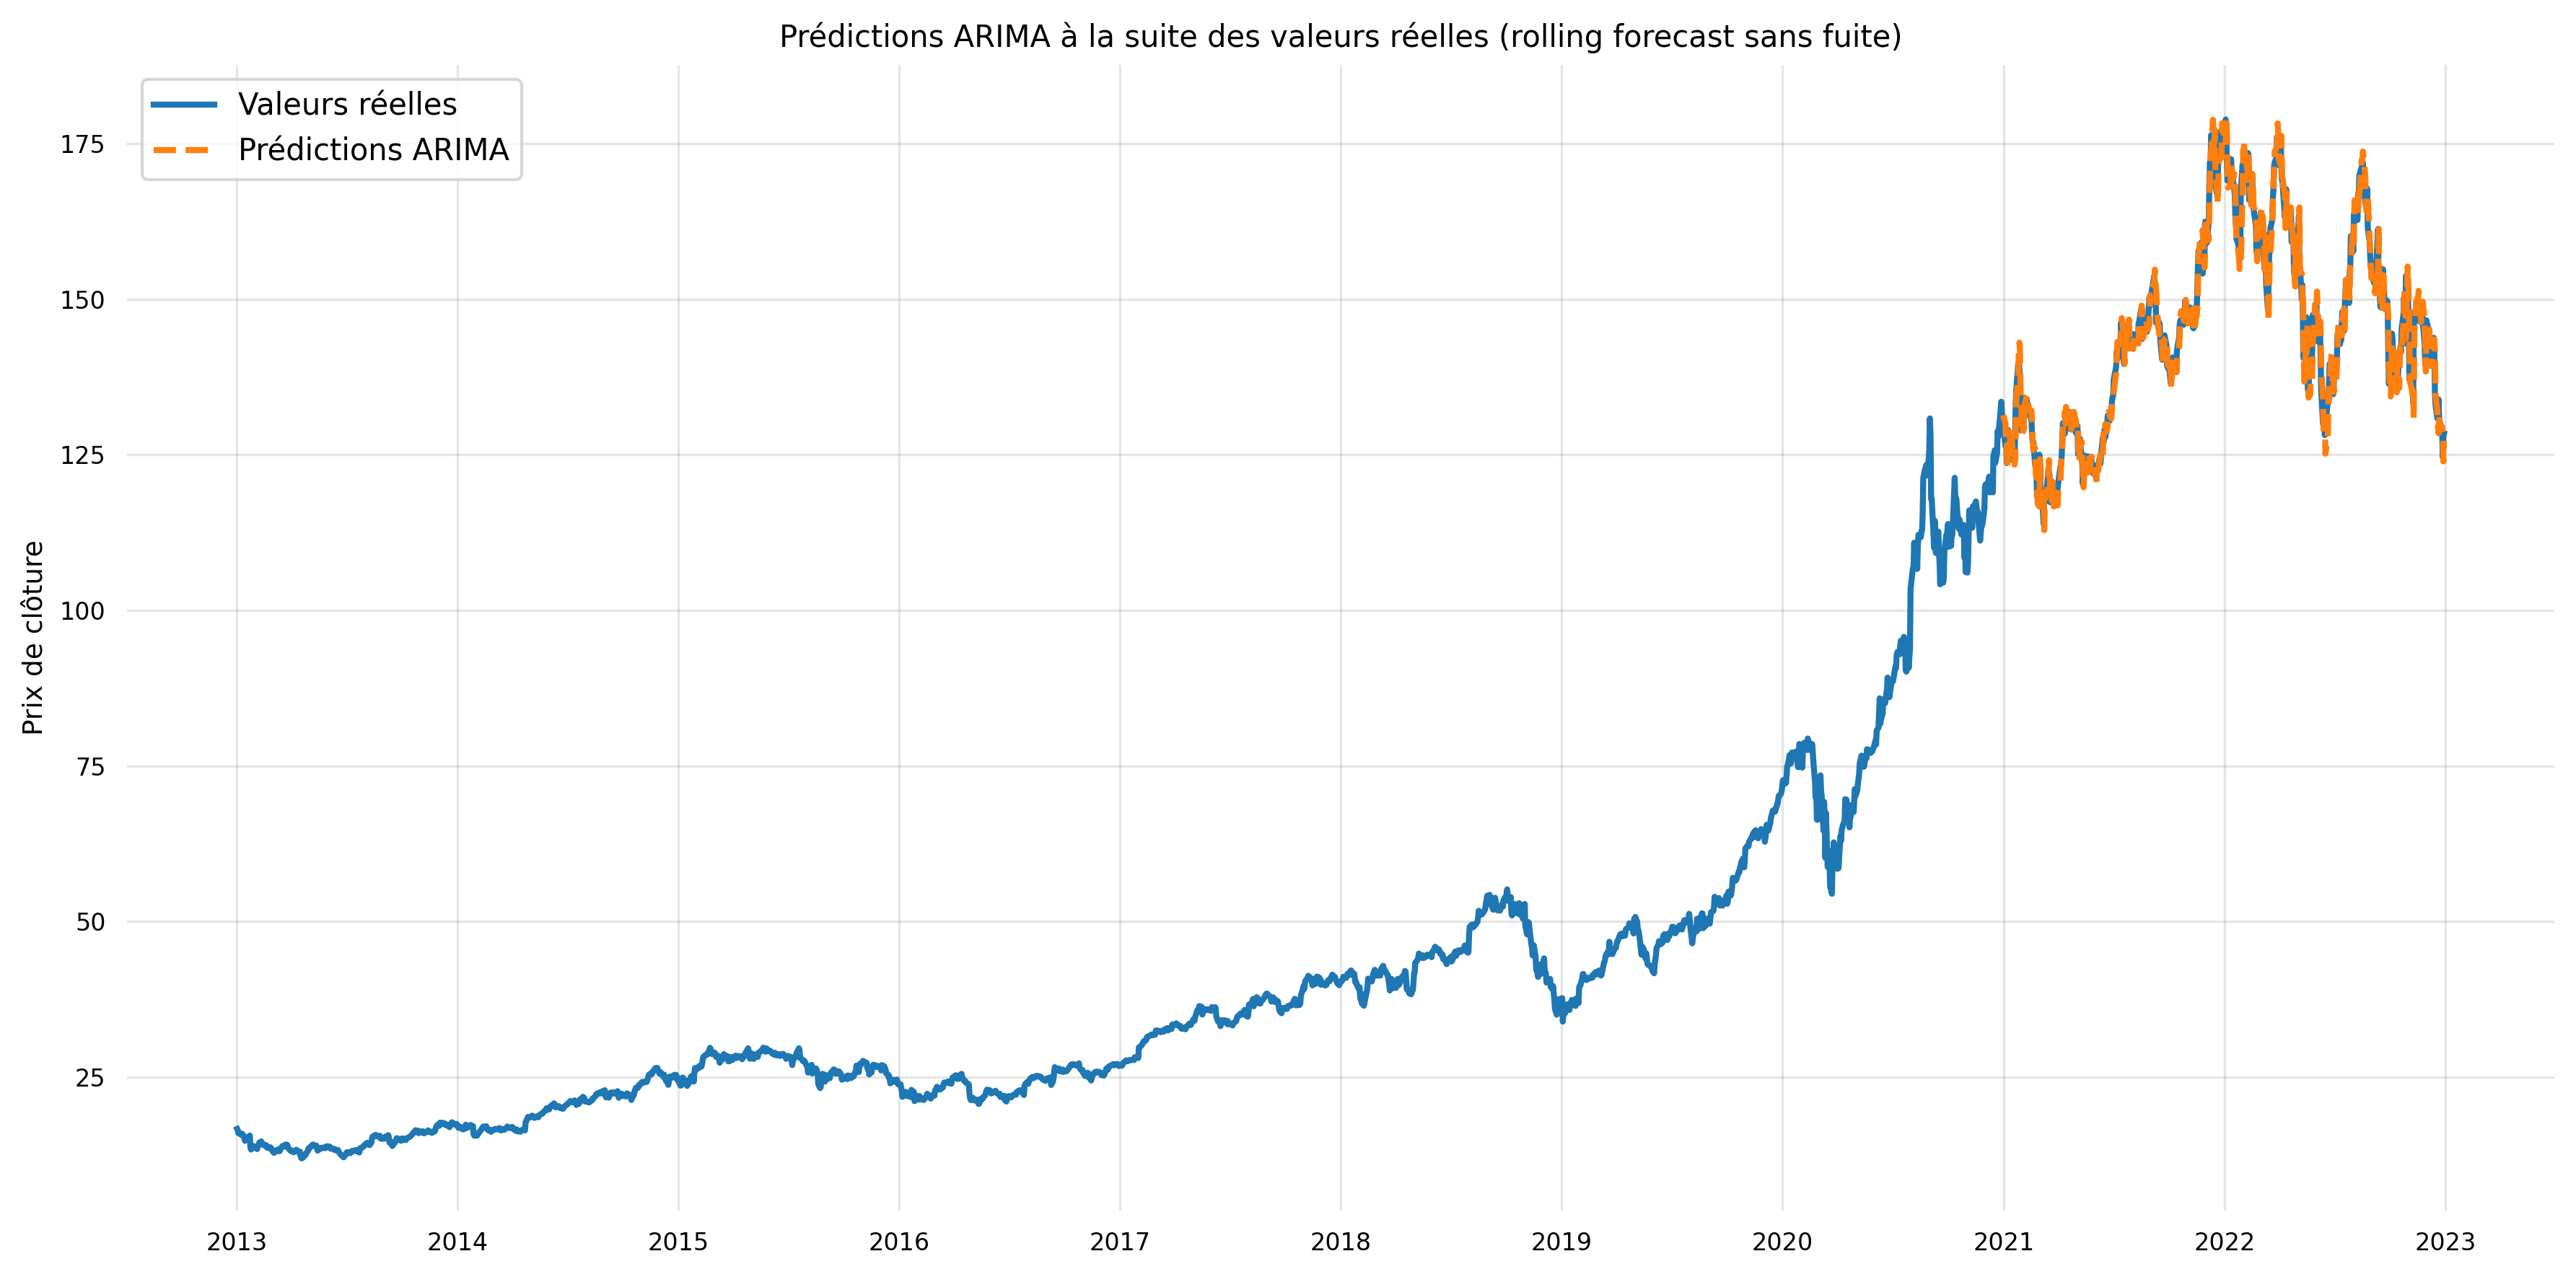

In [13]:
plt.figure(figsize=(12, 6))

plt.plot(stock_prices.index, stock_prices.values, label='Valeurs réelles', linewidth=2)

plt.plot(test_data.index, predictions, label='Prédictions ARIMA', linestyle='--', linewidth=2)

plt.title("Prédictions ARIMA à la suite des valeurs réelles (rolling forecast sans fuite)")
plt.ylabel("Prix de clôture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Définition de la fonction sMAPE
def smape_kun(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true)))

# Préparation des données
stock_prices = data.set_index('Date')['Close'].dropna()

# Découpage en 70% train / 30% test
train_size = int(len(stock_prices) * 0.7)
train_data = stock_prices[:train_size]
test_data = stock_prices[train_size:]

# Recherche automatique de l'ordre (p, d, q) avec p, d, q ≤ 5 selon critère AIC
warnings.filterwarnings("ignore")
best_aic = np.inf
best_order = None
for p in range(6):
    for d in range(6):
        for q in range(6):
            try:
                tmp_model = ARIMA(train_data, order=(p, d, q)).fit()
                if tmp_model.aic < best_aic:
                    best_aic = tmp_model.aic
                    best_order = (p, d, q)
            except:
                continue

print(f"Meilleur ordre ARIMA trouvé : p, d, q = {best_order} (AIC = {best_aic:.1f})")

# Entraînement final du modèle ARIMA avec le meilleur ordre
model = ARIMA(train_data, order=best_order).fit()

# Prédiction sur l'ensemble de la période de test (dernier 30%)
n_periods = len(test_data)
predictions = model.forecast(steps=n_periods)

# Calcul des métriques
mse = mean_squared_error(test_data.values, predictions)
smape = smape_kun(test_data.values, predictions)
print(f'Testing Mean Squared Error: {mse:.3f}')
print(f'Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.3f}')

# Affichage graphique des résultats
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data.values, label='Valeurs réelles')
plt.plot(test_data.index, predictions, label='Prédictions ARIMA')
plt.title("Comparaison des 30% derniers : Réelles vs Prédictions ARIMA")
plt.xlabel("Date")
plt.ylabel("Prix de clôture")
plt.legend()
plt.tight_layout()
plt.show()


c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

Testing Mean Squared Error: 8.078
Symmetric Mean Absolute Percentage Error (sMAPE): 1.478


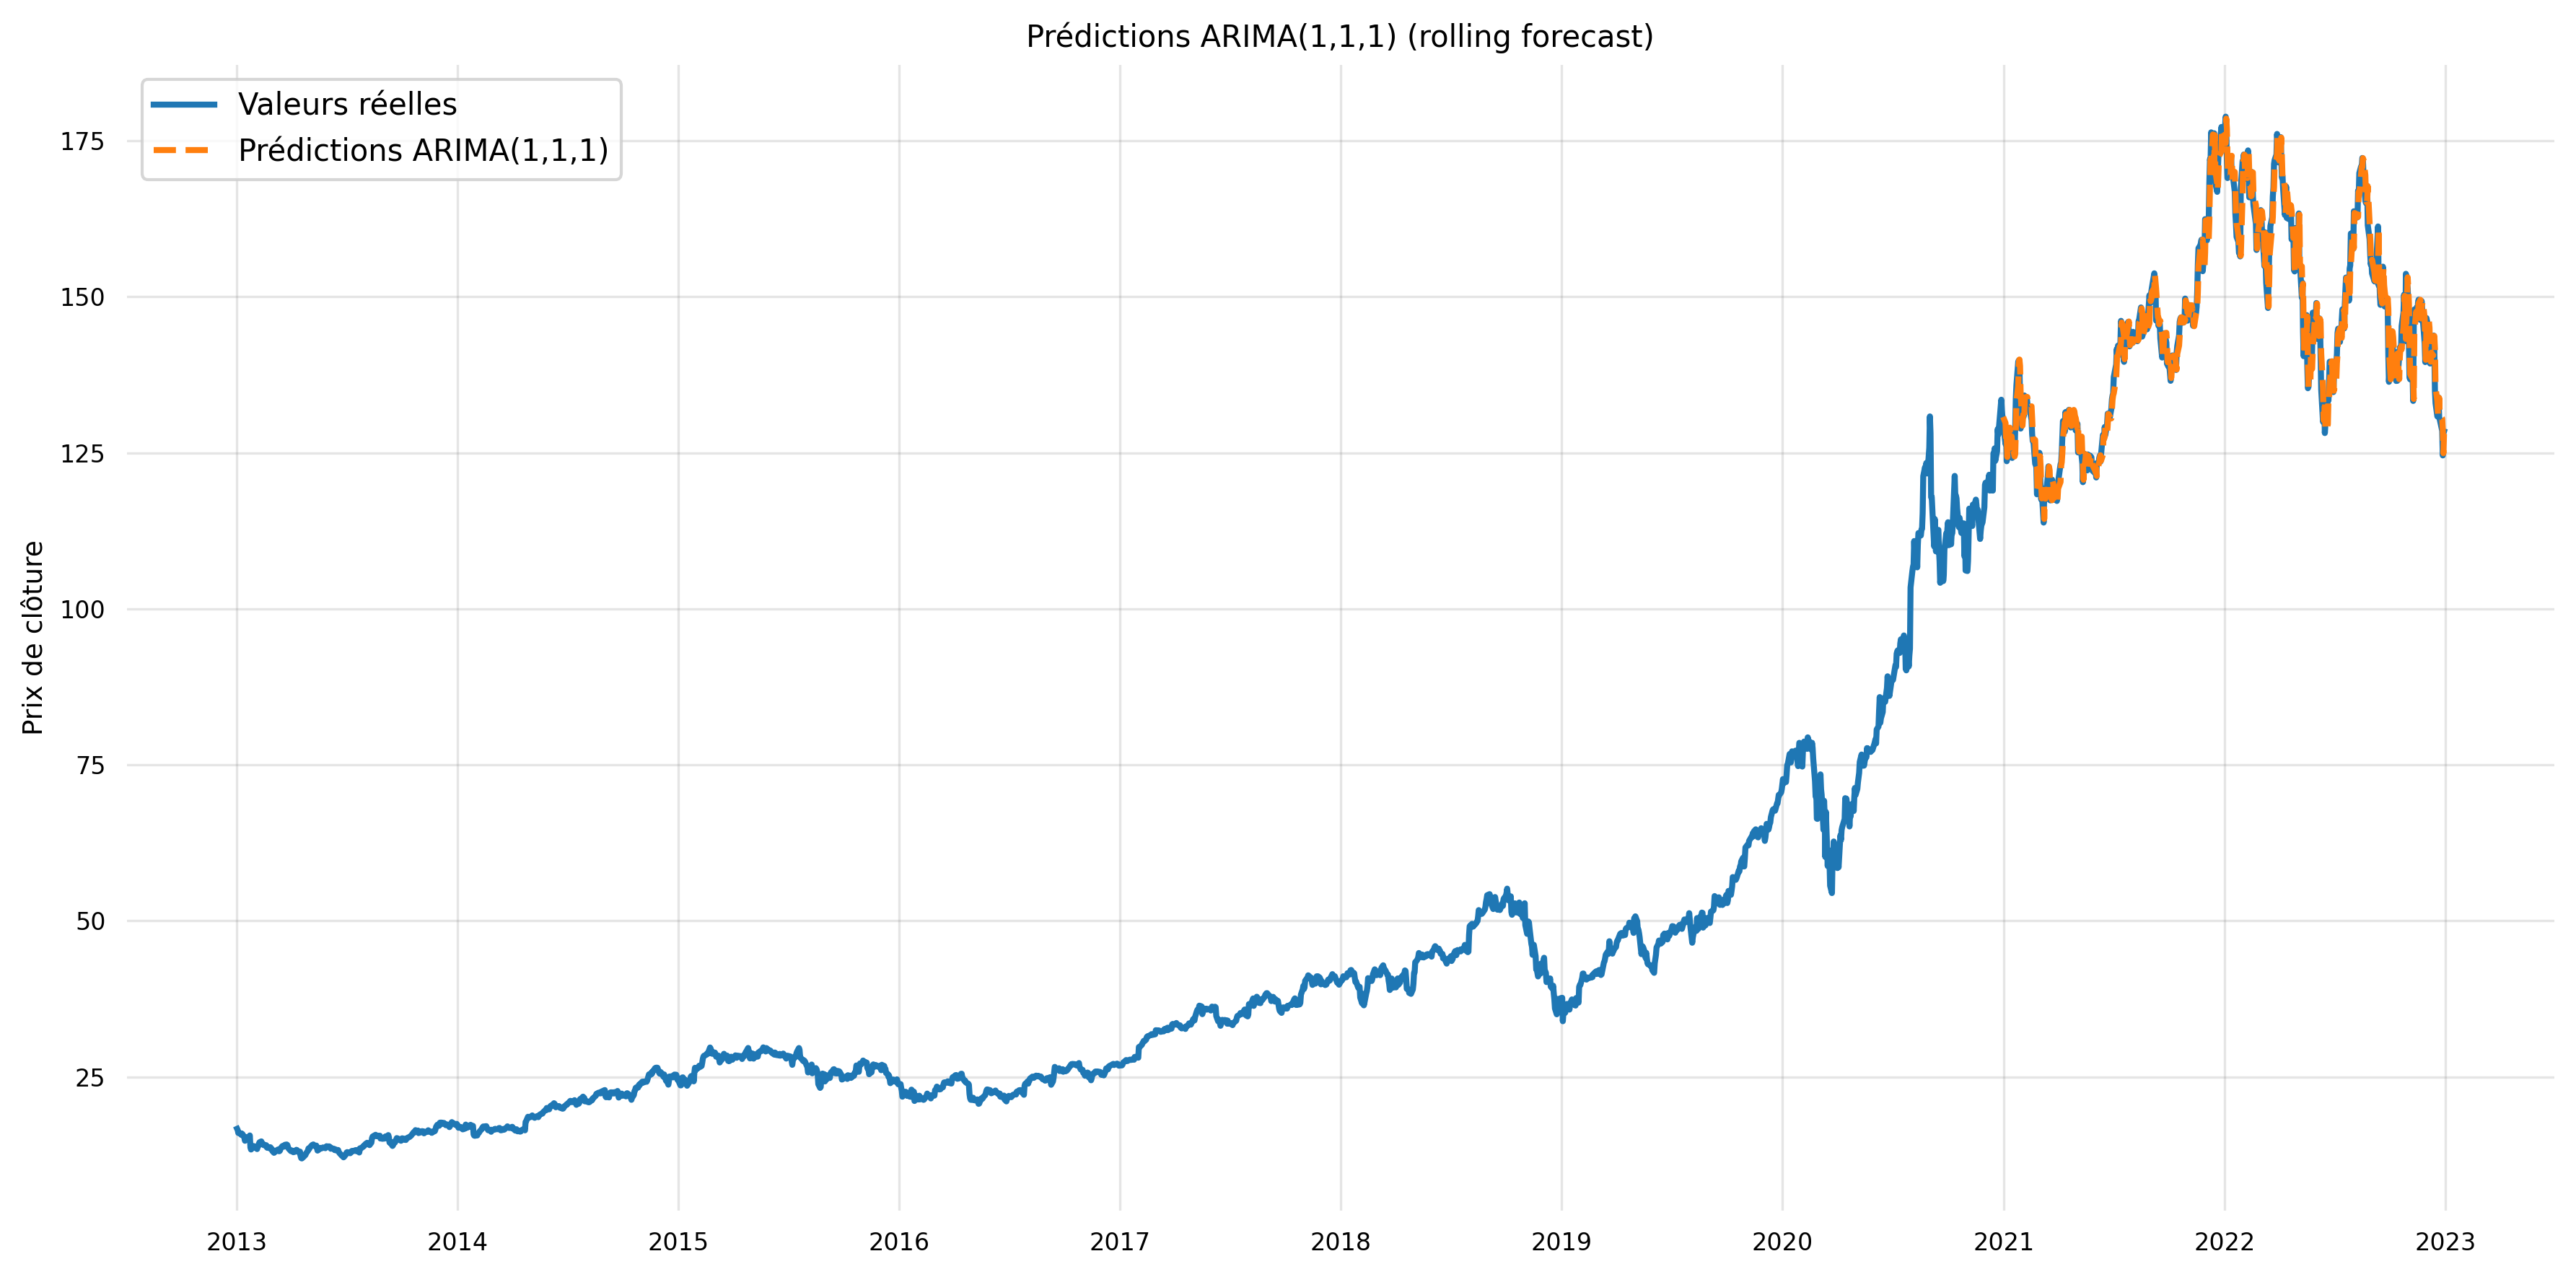

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from pmdarima.arima import ARIMA
import matplotlib.pyplot as plt

# ⚙️ Métrique sMAPE
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

# 📊 Données et séparation train/test
stock_prices = data.set_index('Date')['Close'].dropna()
train_size = int(len(stock_prices) * 0.8)
train_data, test_data = stock_prices[:train_size], stock_prices[train_size:]

train_ar = train_data.values
test_ar = test_data.values

# 🔧 Forcer ARIMA(1,1,1)
model = ARIMA(order=(1, 1, 1))
model.fit(train_ar)

# 🔁 Rolling forecast
predictions = []

for t in range(len(test_ar)):
    yhat = model.predict(n_periods=1)[0]
    predictions.append(yhat)
    model.update(test_ar[t:t+1])

# 📊 Évaluation
mse = mean_squared_error(test_ar, predictions)
smape = smape_kun(test_ar, predictions)

print(f'Testing Mean Squared Error: {mse:.3f}')
print(f'Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.3f}')

# 📈 Visualisation
plt.figure(figsize=(12, 6))
plt.plot(stock_prices.index, stock_prices.values, label='Valeurs réelles', linewidth=2)
plt.plot(test_data.index, predictions, label='Prédictions ARIMA(1,1,1)', linestyle='--', linewidth=2)
plt.title("Prédictions ARIMA(1,1,1) (rolling forecast)")
plt.ylabel("Prix de clôture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

Accuracy prédiction de direction : 0.026

Matrice de confusion :
[[  2 249]
 [241  11]]

Rapport de classification :
              precision    recall  f1-score   support

      Baisse       0.01      0.01      0.01       251
      Hausse       0.04      0.04      0.04       252

    accuracy                           0.03       503
   macro avg       0.03      0.03      0.03       503
weighted avg       0.03      0.03      0.03       503


MSE: 8.078, sMAPE: 1.478


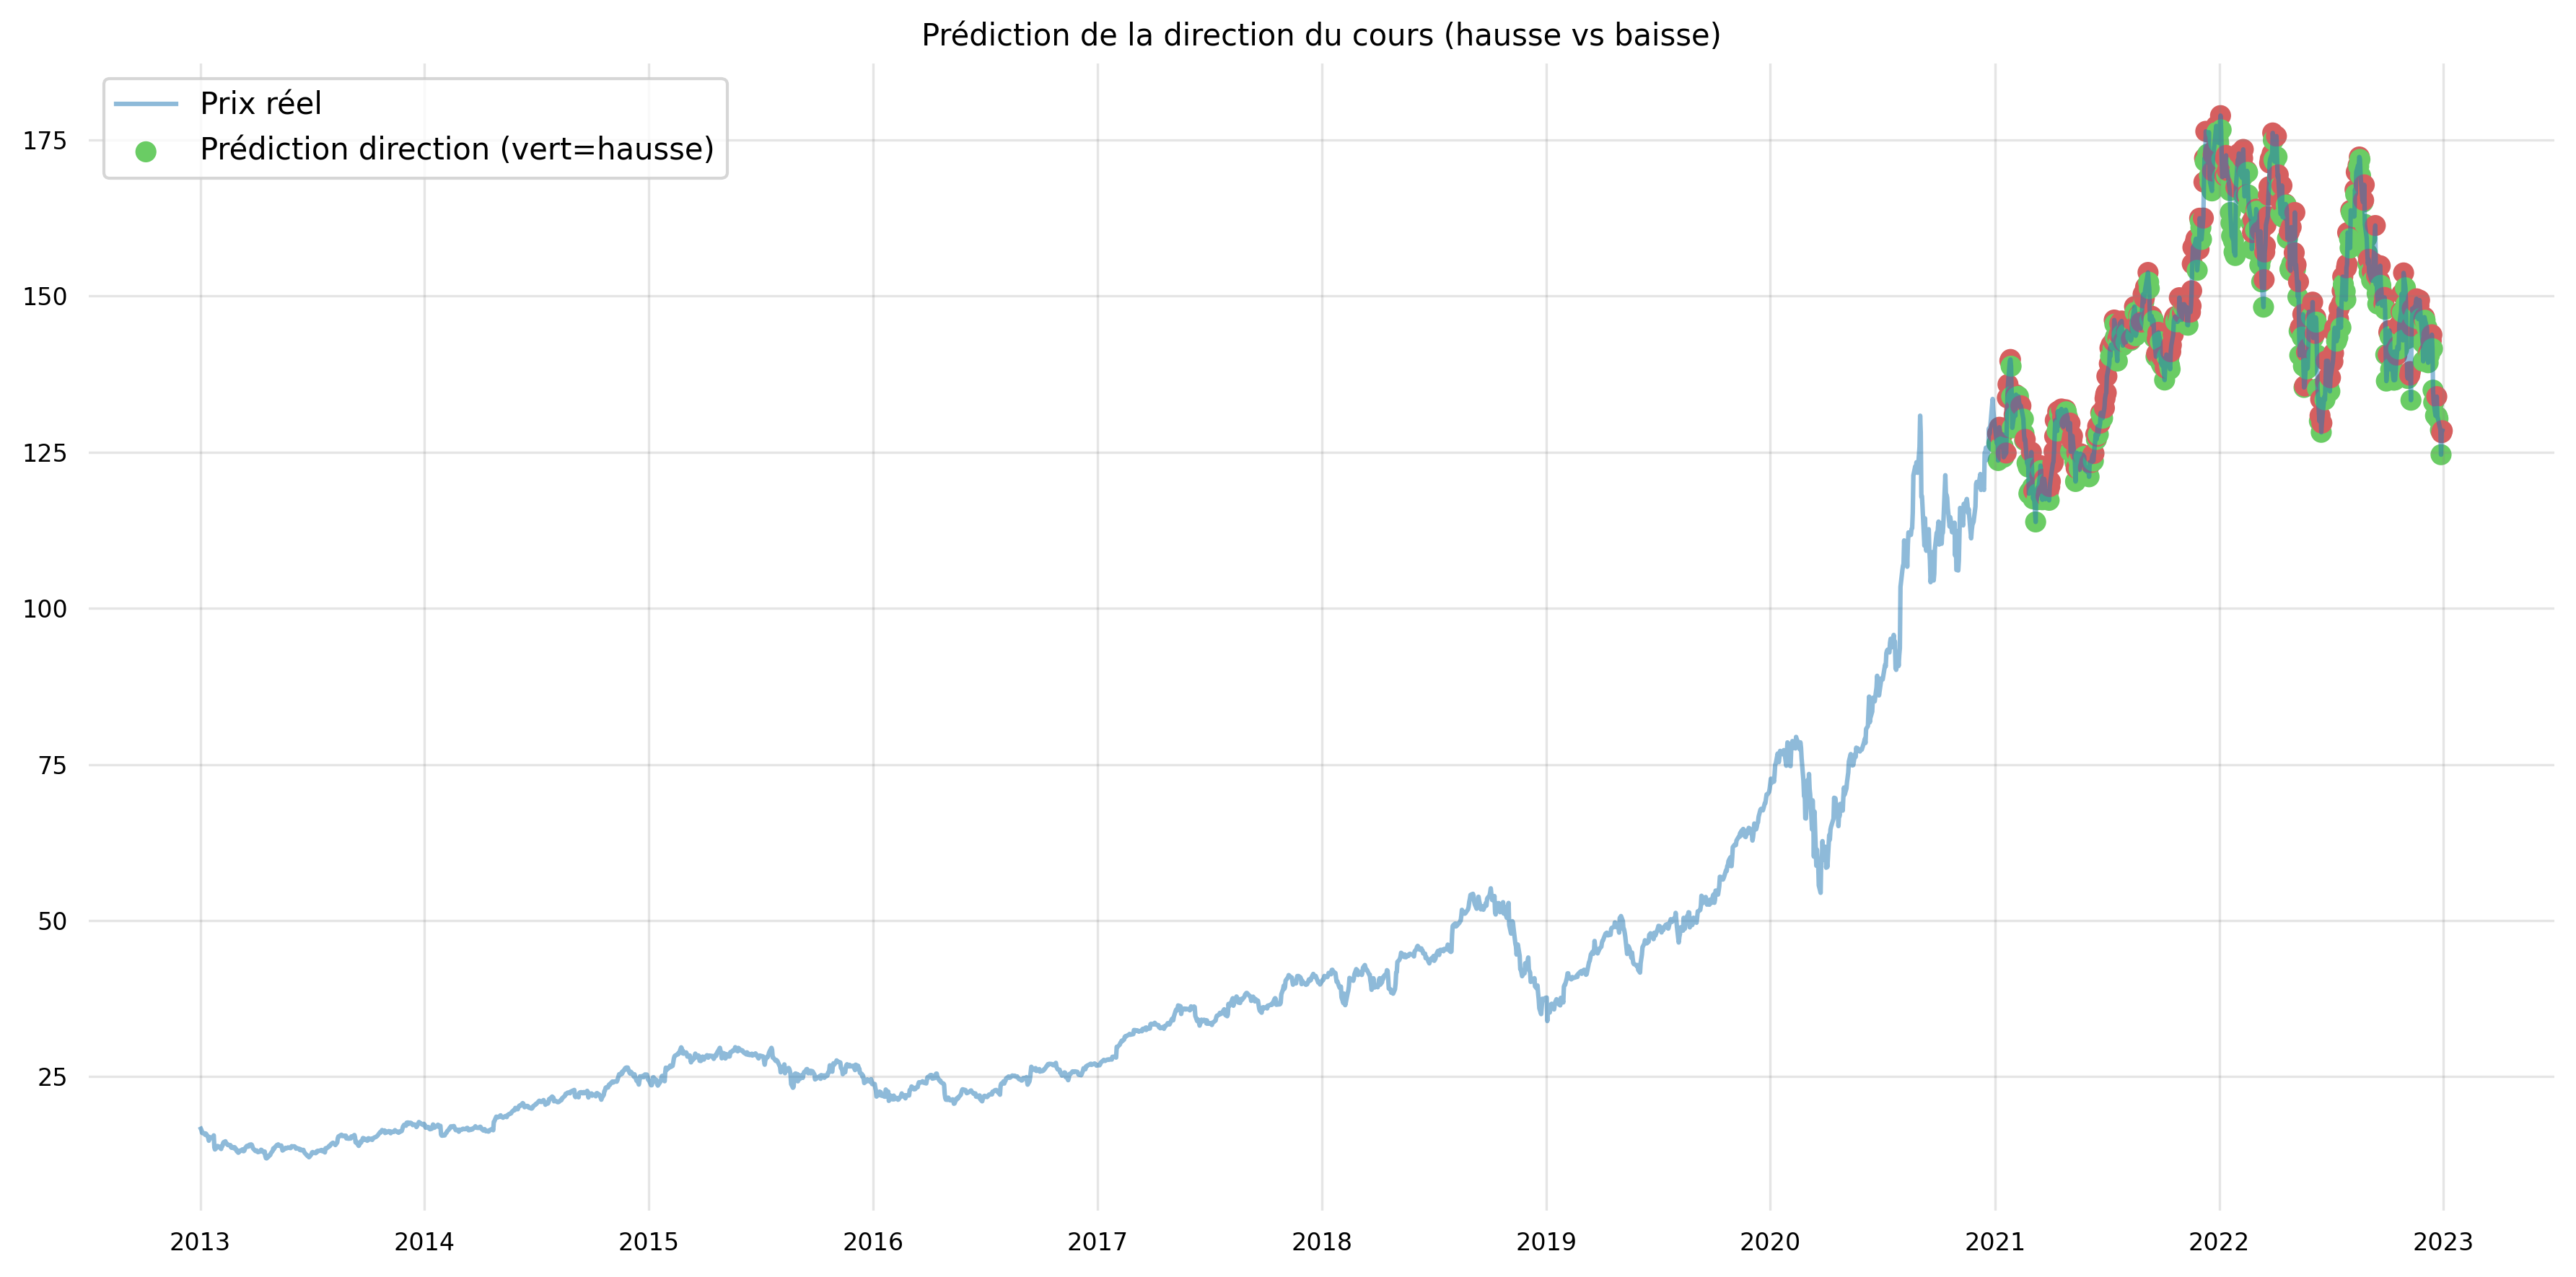

In [72]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pmdarima.arima import ARIMA
import matplotlib.pyplot as plt

# ⚙️ Métrique sMAPE (on peut la garder si on veut benchmarker prix)
def smape_kun(y_true, y_pred):
    return np.mean(200 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# 📊 Préparation des données
stock_prices = data.set_index('Date')['Close'].dropna()
train_size = int(len(stock_prices) * 0.8)
train_data = stock_prices.iloc[:train_size]
test_data  = stock_prices.iloc[train_size:]

train_ar = train_data.values
test_ar  = test_data.values

# 🔧 Ajustement ARIMA(1,1,1)
model = ARIMA(order=(1, 1, 1))
model.fit(train_ar)

# 🔁 Rolling forecast
predictions = []
history = list(train_ar)

for actual in test_ar:
    # 1. Prédire le prochain prix
    yhat = model.predict(n_periods=1)[0]
    predictions.append(yhat)
    # 2. Mettre à jour le modèle avec la vraie valeur (rolling)
    model.update(np.array([actual]))
    history.append(actual)

# 📝 Calcul des directions
# Direction prédite : 1 si prédiction > price précédent, sinon 0
pred_dir = []
for i, yhat in enumerate(predictions):
    last_price = history[train_size + i]  # prix du jour t avant d’observer t+1
    pred_dir.append(int(yhat > last_price))

# Vraie direction : 1 si test[t] > test[t-1], sinon 0
# On ignore la première valeur de test_ar pour ce calcul
true_dir = (test_data.diff().iloc[1:] > 0).astype(int).values
pred_dir = np.array(pred_dir[1:])  # alignement

# 📊 Évaluation classification
acc = accuracy_score(true_dir, pred_dir)
cm  = confusion_matrix(true_dir, pred_dir)
report = classification_report(true_dir, pred_dir, target_names=['Baisse','Hausse'])

print(f"Accuracy prédiction de direction : {acc:.3f}\n")
print("Matrice de confusion :")
print(cm)
print("\nRapport de classification :")
print(report)

# (Optionnel) On peut toujours regarder MSE / sMAPE sur les prix
from sklearn.metrics import mean_squared_error
mse   = mean_squared_error(test_ar, predictions)
smape = smape_kun(test_ar, predictions)
print(f"\nMSE: {mse:.3f}, sMAPE: {smape:.3f}")

# 📈 Visualisation
plt.figure(figsize=(12,6))
plt.plot(stock_prices.index, stock_prices.values, label='Prix réel', alpha=0.5)
# Pour afficher les signaux de hausse/baisse, on peut colorer les points test
test_idx = test_data.index[1:]
colors = ['g' if d==1 else 'r' for d in pred_dir]
plt.scatter(test_idx, test_data.values[1:], c=colors, marker='o', label='Prédiction direction (vert=hausse)')
plt.title("Prédiction de la direction du cours (hausse vs baisse)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2518
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4686.068
Date:               lun., 26 mai 2025   AIC                           9380.136
Time:                        00:17:02   BIC                           9403.459
Sample:                             0   HQIC                          9388.600
                               - 2518                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0265      0.019      1.414      0.157      -0.010       0.063
ar.L1          0.4027      0.127      3.162      0.002       0.153       0.652
ma.L1         -0.4636      0.125     -3.722      0.0

In [55]:
data_new = data.loc[data["Date"].astype(str).str[:4].astype(int)>2019]

In [46]:
data.query("Date >= '2020-01-01'")

TypeError: Invalid comparison between dtype=datetime64[ns, America/New_York] and Timestamp

Epoch 10/50 - Loss: 0.095584
Epoch 20/50 - Loss: 0.060350
Epoch 30/50 - Loss: 0.036969
Epoch 40/50 - Loss: 0.007284
Epoch 50/50 - Loss: 0.005873
Testing Mean Squared Error: 74.949
Symmetric Mean Absolute Percentage Error (sMAPE): 4.795


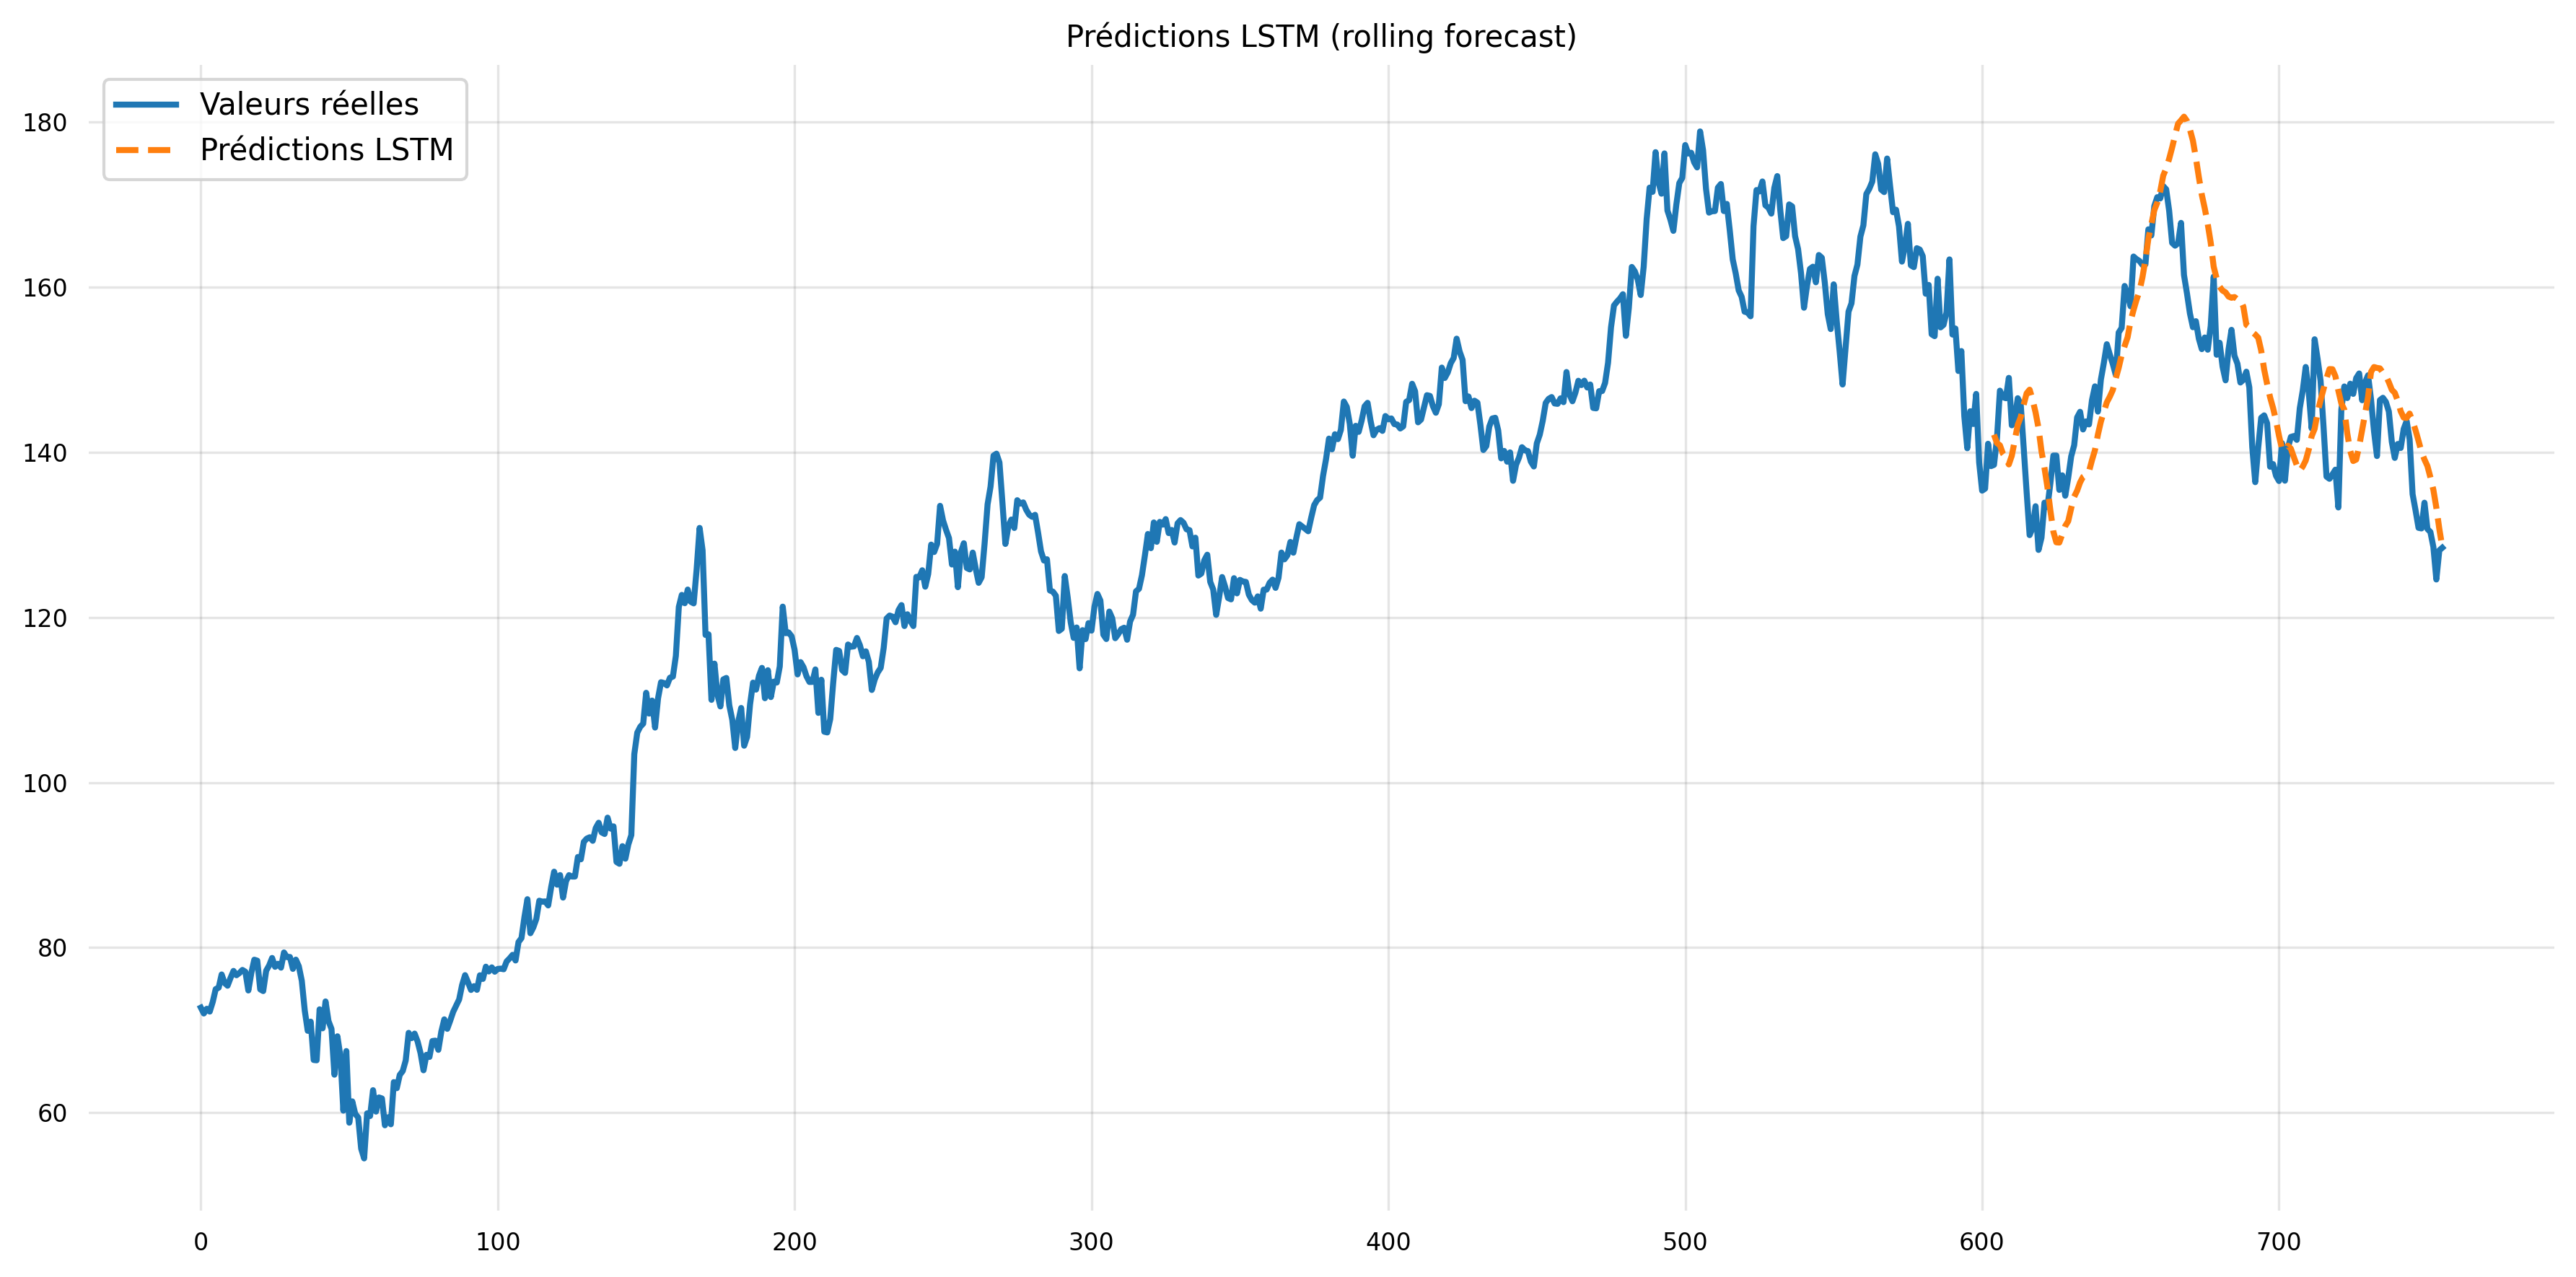

In [71]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ⚙️ sMAPE
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

# ⚙️ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📊 Données
stock_prices = data_new.set_index('Date')['Close'].dropna().values.reshape(-1, 1)
train_size = int(len(stock_prices) * 0.8)

scaler = MinMaxScaler()
stock_scaled = scaler.fit_transform(stock_prices)

train_scaled = stock_scaled[:train_size]
test_scaled = stock_scaled[train_size:]

# 🔁 Séquences
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 10
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

# 🔧 Modèle LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                    batch_first=True, dropout=0.2)

        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Dernier pas de temps
        return self.fc(out)

model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 🏋️ Entraînement
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {loss.item():.6f}")

# 🔮 Rolling forecast sur test set
model.eval()
inputs = train_scaled[-SEQ_LEN:].tolist()
predictions = []

for i in range(len(test_scaled)):
    seq = torch.tensor([inputs[-SEQ_LEN:]], dtype=torch.float32).to(device)
    with torch.no_grad():
        pred = model(seq).cpu().numpy().flatten()[0]
    predictions.append(pred)
    inputs.append([test_scaled[i][0]])  # update input with true value (no cheating)

# 🔁 Inverser la normalisation
pred_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
test_true = scaler.inverse_transform(test_scaled).flatten()

# 📊 Évaluation
mse = mean_squared_error(test_true, pred_inv)
smape = smape_kun(test_true, pred_inv)

print(f'Testing Mean Squared Error: {mse:.3f}')
print(f'Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.3f}')

# 📈 Visualisation
plt.figure(figsize=(12, 6))
plt.plot(range(len(stock_prices)), stock_prices, label="Valeurs réelles", linewidth=2)
plt.plot(range(train_size, train_size + len(pred_inv)), pred_inv, label="Prédictions LSTM", linestyle='--', linewidth=2)
plt.title("Prédictions LSTM (rolling forecast)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


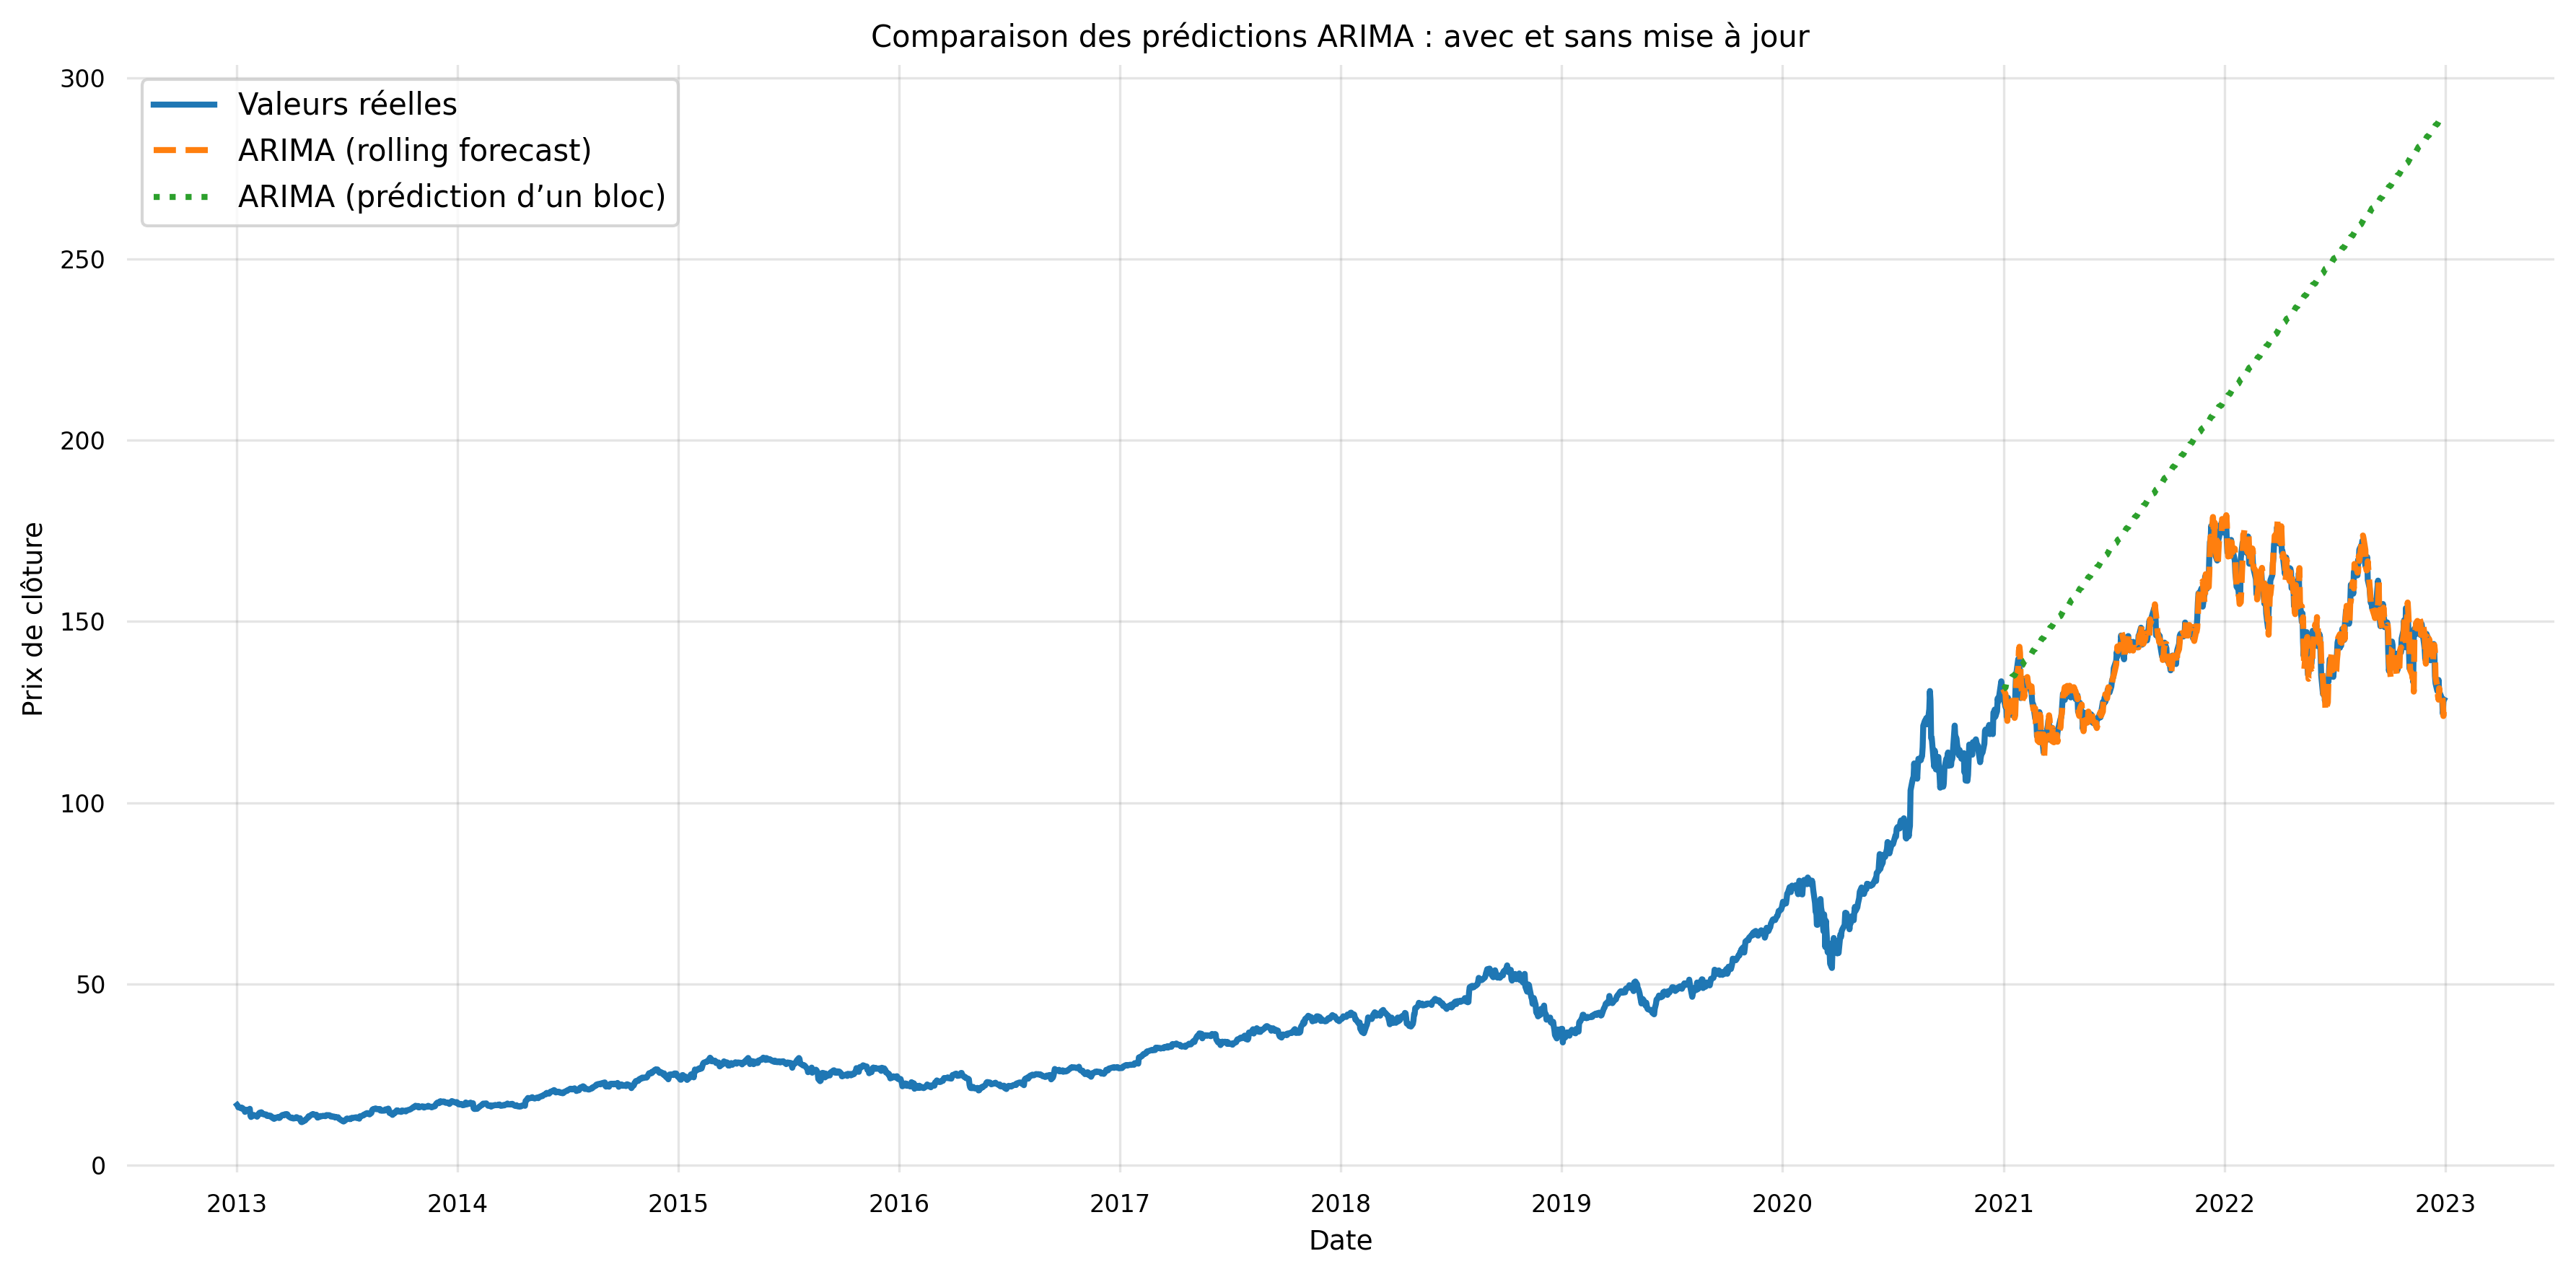

In [51]:
plt.figure(figsize=(12, 6))

# Courbe réelle
plt.plot(stock_prices.index, stock_prices.values, label='Valeurs réelles', linewidth=2)

# Rolling forecast ARIMA
plt.plot(test_data.index, predictions, '--', label='ARIMA (rolling forecast)', linewidth=2)

# Static ARIMA (sans update)
plt.plot(test_data.index, static_preds, ':', label='ARIMA (prédiction d’un bloc)', linewidth=2)

plt.title("Comparaison des prédictions ARIMA : avec et sans mise à jour")
plt.xlabel("Date")
plt.ylabel("Prix de clôture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-pack

Testing Mean Squared Error: 5933.993
Symmetric Mean Absolute Percentage Error (sMAPE): 34.584


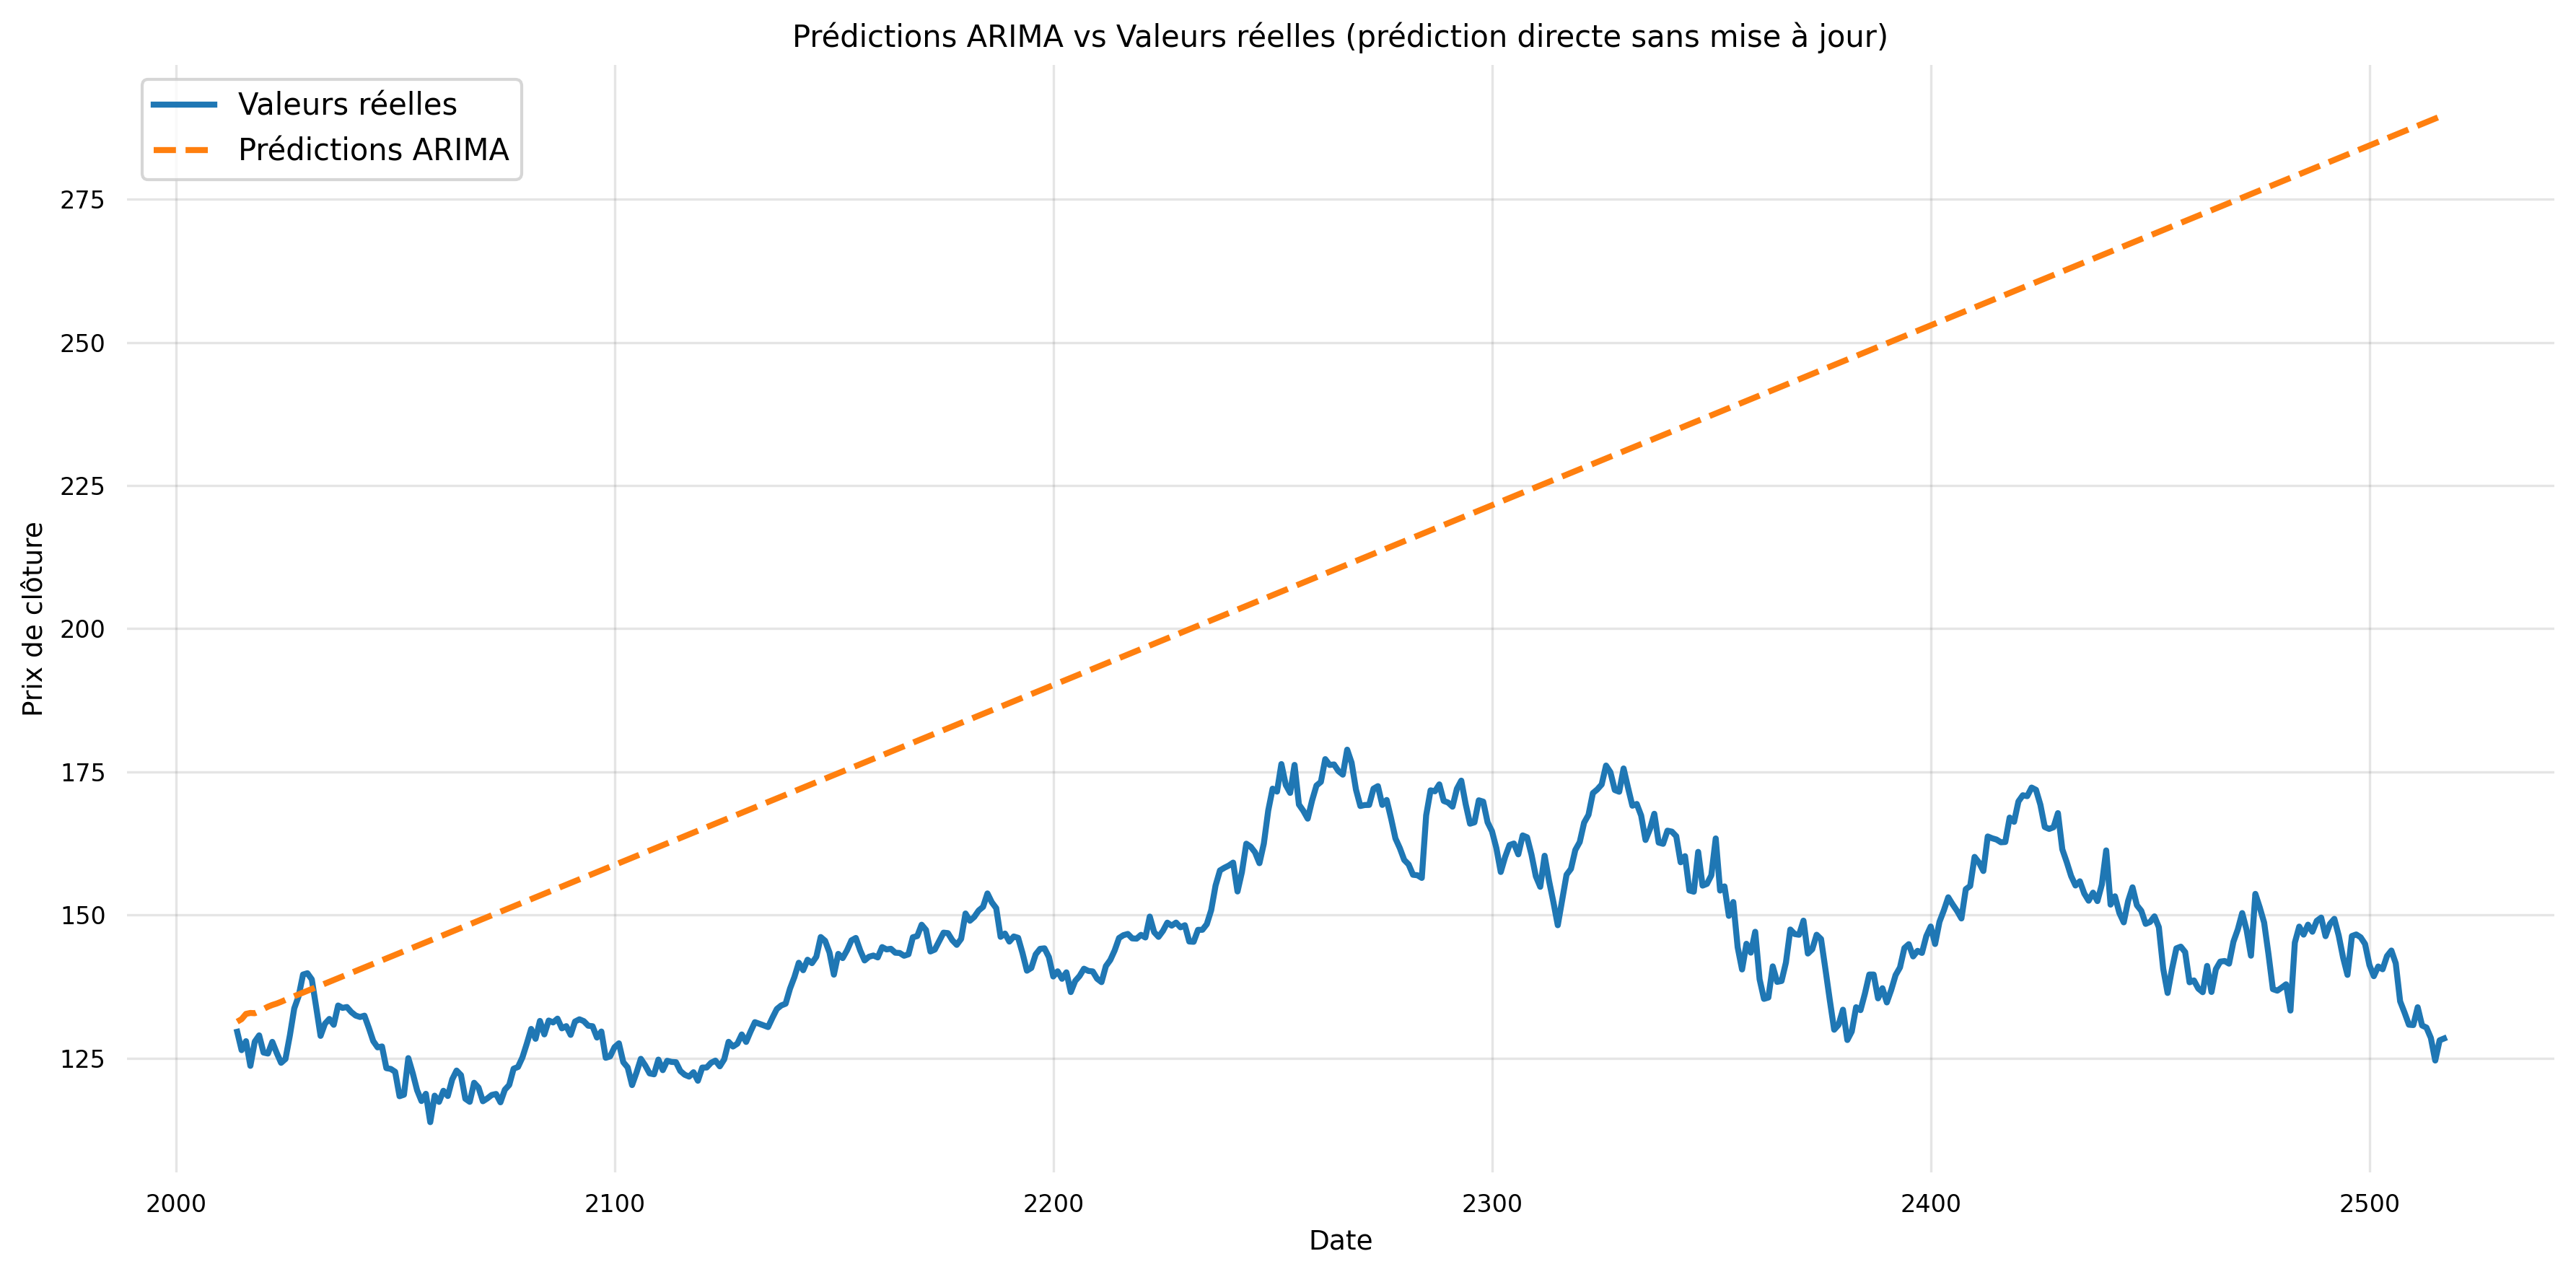

In [43]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

# Série temporelle
stock_prices = data['Close'].dropna()
train_size = int(len(stock_prices) * 0.8)
train_data, test_data = stock_prices[:train_size], stock_prices[train_size:]

# Extraction des valeurs numpy
train_ar = train_data.values
test_ar = test_data.values

# 🔍 Entraînement unique sur les données d'entraînement
model = auto_arima(train_ar, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore")
model.fit(train_ar)

# 🔮 Prédiction directe sur toute la période de test
predictions = model.predict(n_periods=len(test_ar))

# 📊 Calcul des erreurs
mse = mean_squared_error(test_ar, predictions)
smape = smape_kun(test_ar, predictions)

print(f'Testing Mean Squared Error: {mse:.3f}')
print(f'Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.3f}')

# 📈 Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_ar, label='Valeurs réelles', linewidth=2)
plt.plot(test_data.index, predictions, label='Prédictions ARIMA', linestyle='--', linewidth=2)
plt.title("Prédictions ARIMA vs Valeurs réelles (prédiction directe sans mise à jour)")
plt.xlabel("Date")
plt.ylabel("Prix de clôture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


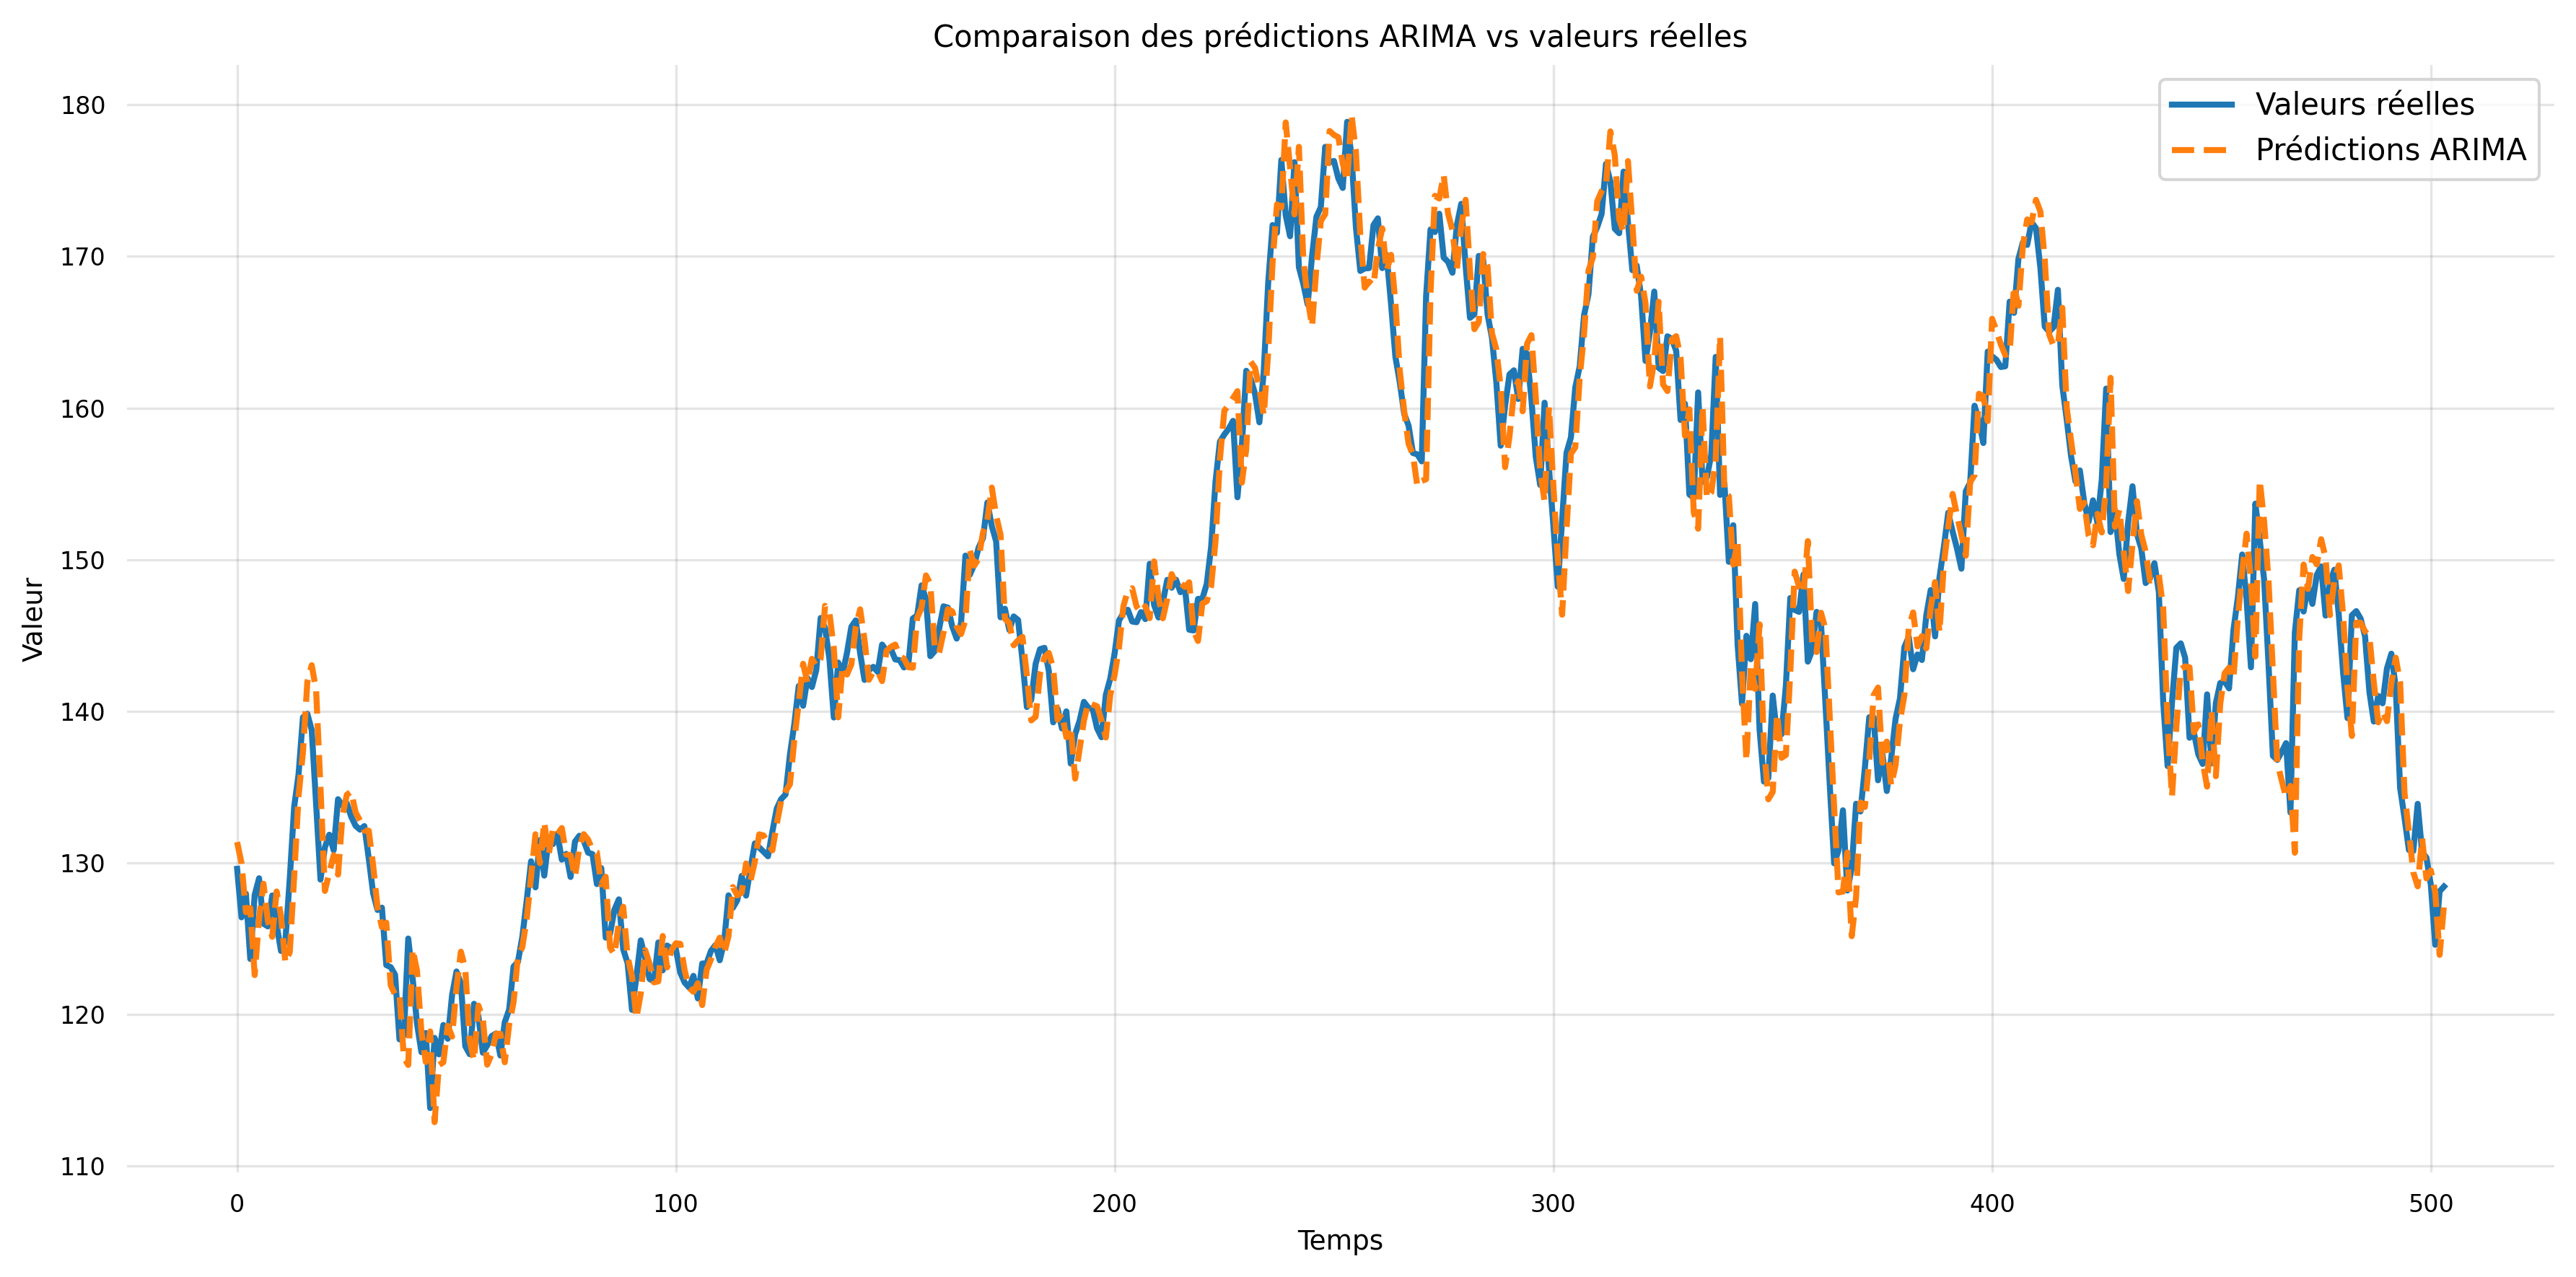

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(test_ar, label='Valeurs réelles', linewidth=2)
plt.plot(predictions, label='Prédictions ARIMA', linewidth=2, linestyle='--')
plt.title("Comparaison des prédictions ARIMA vs valeurs réelles")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1763
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1333.087
Date:               jeu., 29 mai 2025   AIC                           2674.175
Time:                        18:49:47   BIC                           2696.069
Sample:                             0   HQIC                          2682.266
                               - 1763                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0045      0.016      0.279      0.780      -0.027       0.036
ar.L2         -0.0596      0.018     -3.392      0.001      -0.094      -0.025
ma.L1         -0.9900      0.003   -360.499      0.0

c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


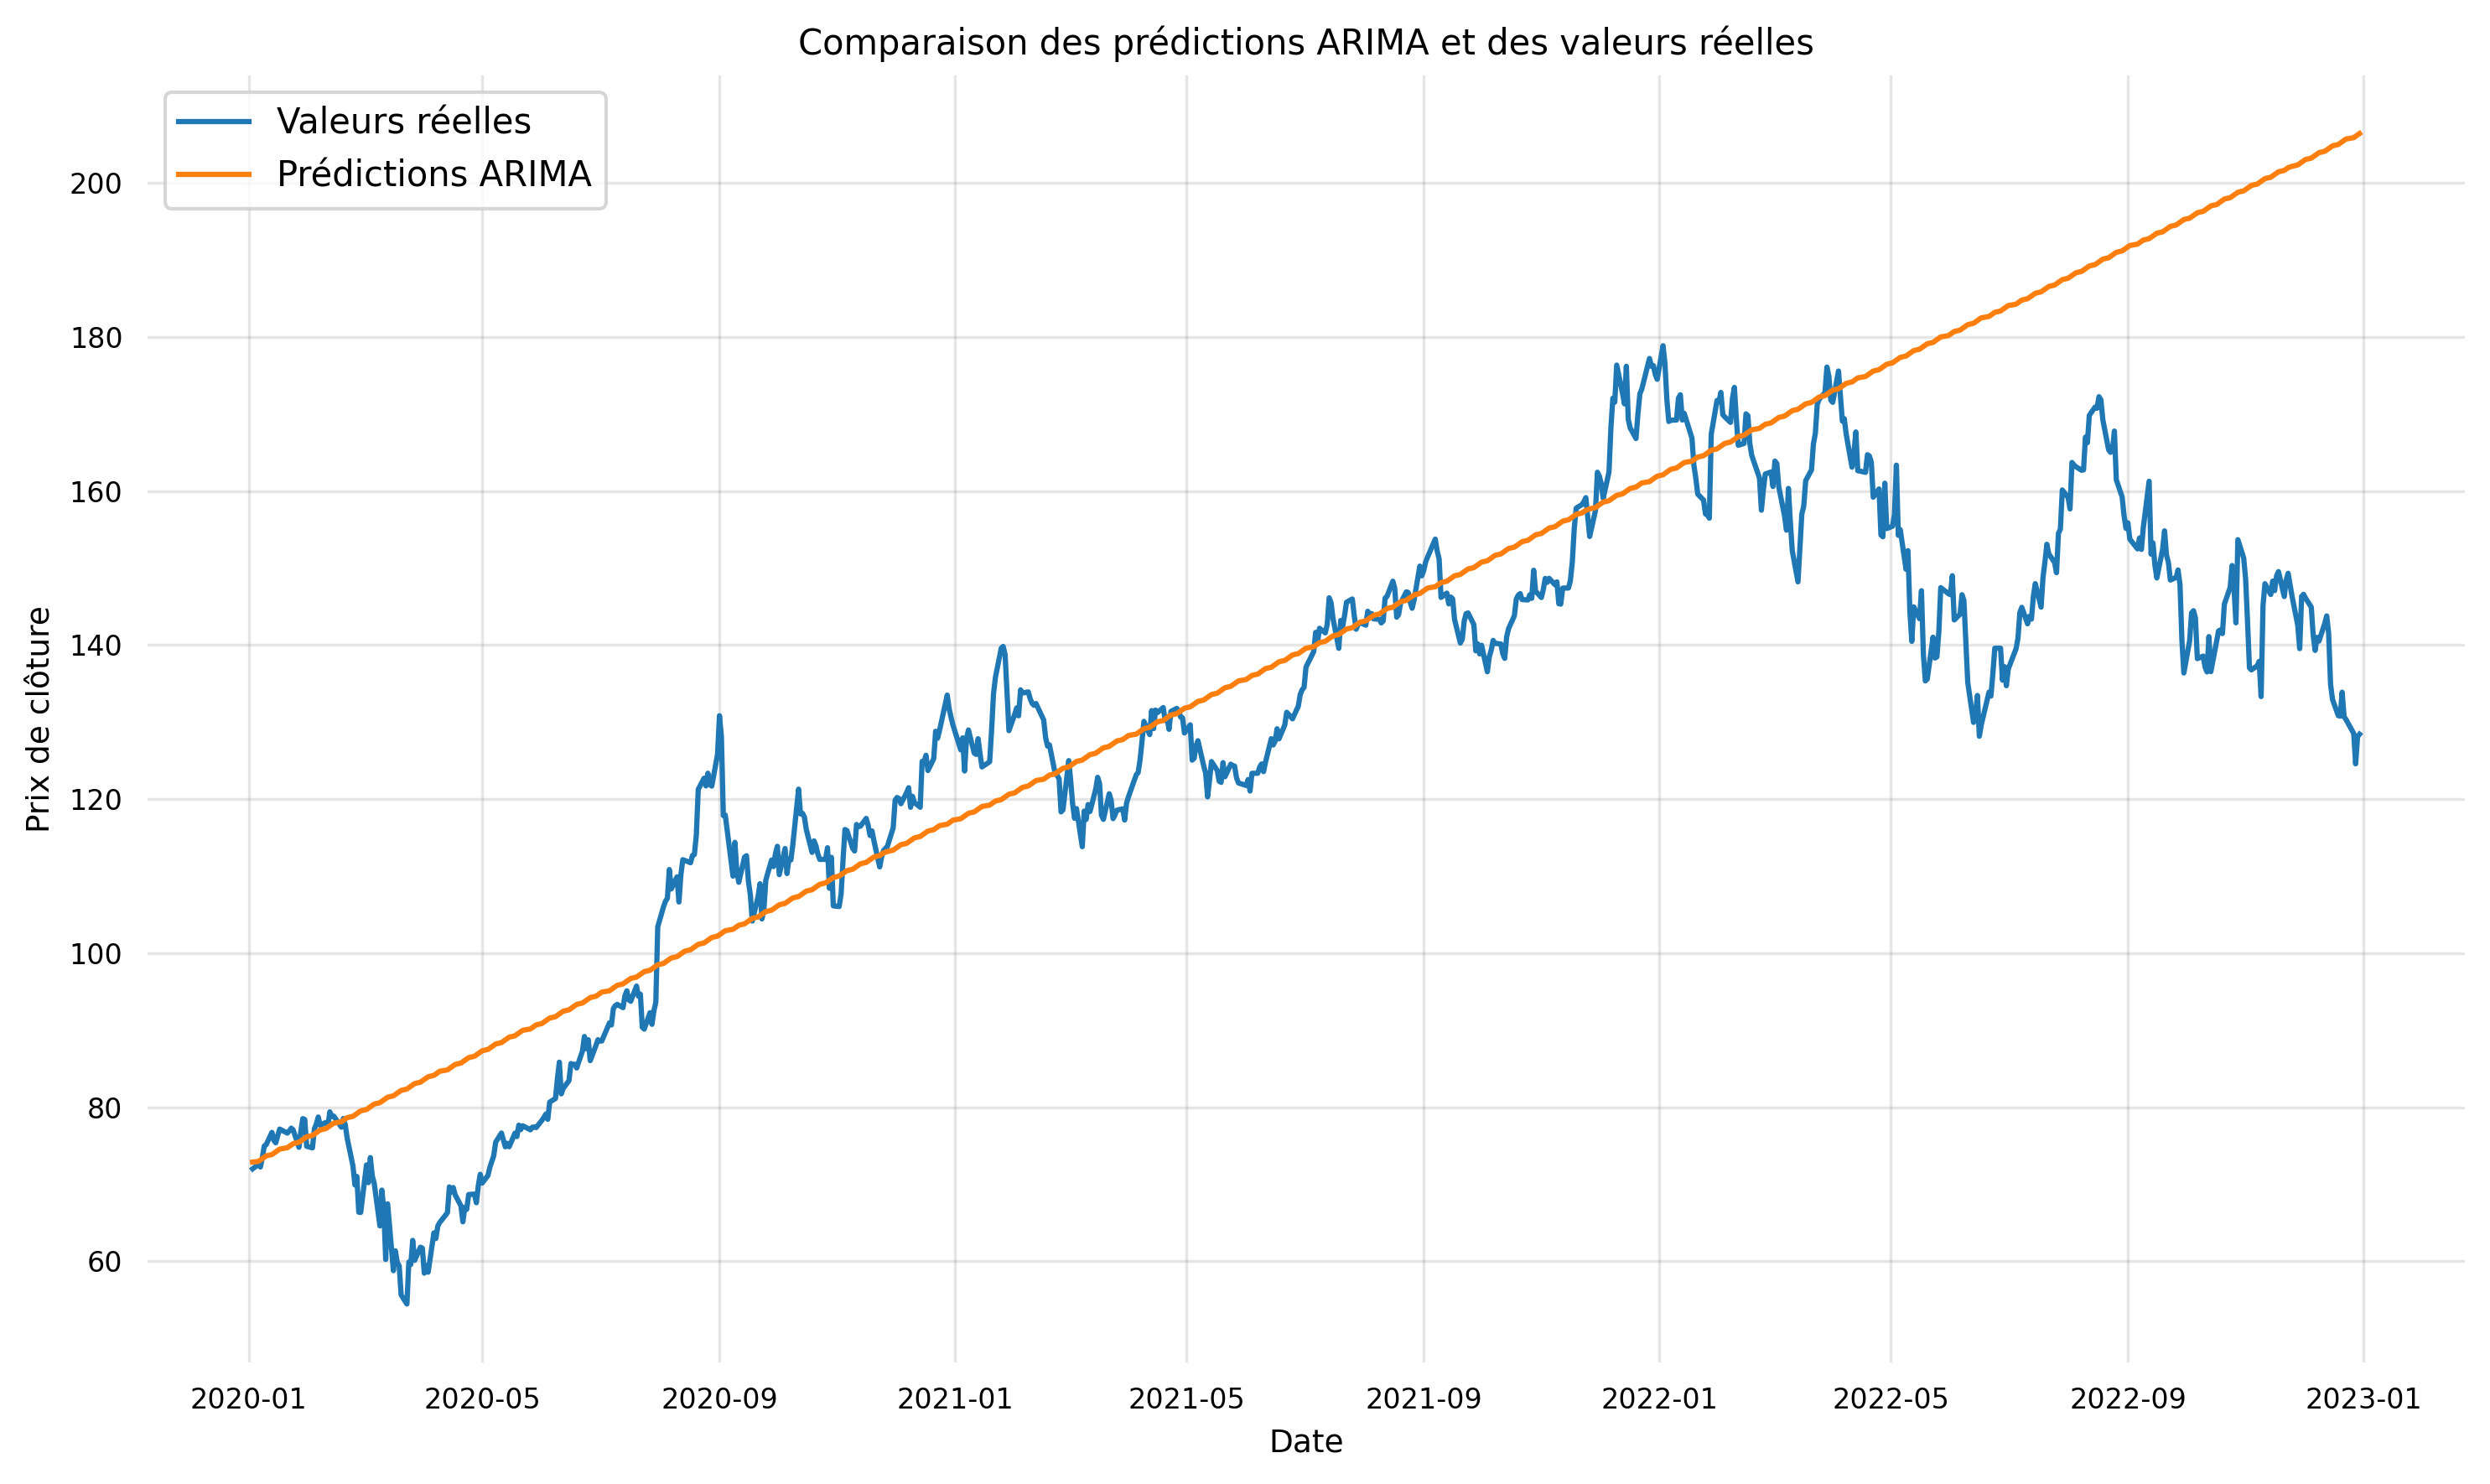

In [7]:
# Préparation des données
stock_prices = data.set_index('Date')['Close'].dropna()
n = len(stock_prices)
test_size = int(n * 0.3)
train_size = n - test_size

train_data = stock_prices.iloc[:train_size]
test_data = stock_prices.iloc[train_size:]

# Entraînement du modèle ARIMA avec sélection automatique des ordres (p,d,q ≤ 5)
model = auto_arima(
    train_data,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    max_d=3,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)
model.fit(train_data)
print(model.summary())
# Prédiction sur les 30% finaux
n_periods = len(test_data)
predictions = model.predict(n_periods=n_periods)

# Calcul de l'erreur
mse = mean_squared_error(test_data, predictions)
print(f'MSE sur les 30% finaux : {mse:.3f}')

# Affichage des vraies valeurs et des prédictions
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data.values, label='Valeurs réelles')
plt.plot(test_data.index, predictions, label='Prédictions ARIMA')
plt.xlabel('Date')
plt.ylabel('Prix de clôture')
plt.title('Comparaison des prédictions ARIMA et des valeurs réelles')
plt.legend()
plt.tight_layout()
plt.show()


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1763
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1333.087
Date:               jeu., 29 mai 2025   AIC                           2674.175
Time:                        18:54:42   BIC                           2696.069
Sample:                             0   HQIC                          2682.266
                               - 1763                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0045      0.016      0.279      0.780      -0.027       0.036
ar.L2         -0.0596      0.018     -3.392      0.001      -0.094      -0.025
ma.L1         -0.9900      0.003   -360.499      0.0

c:\Users\zetru\projets_python\apple-stock-prediction\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE sur les 30% finaux : 20.351
sMAPE sur les 30% finaux : 2.695%


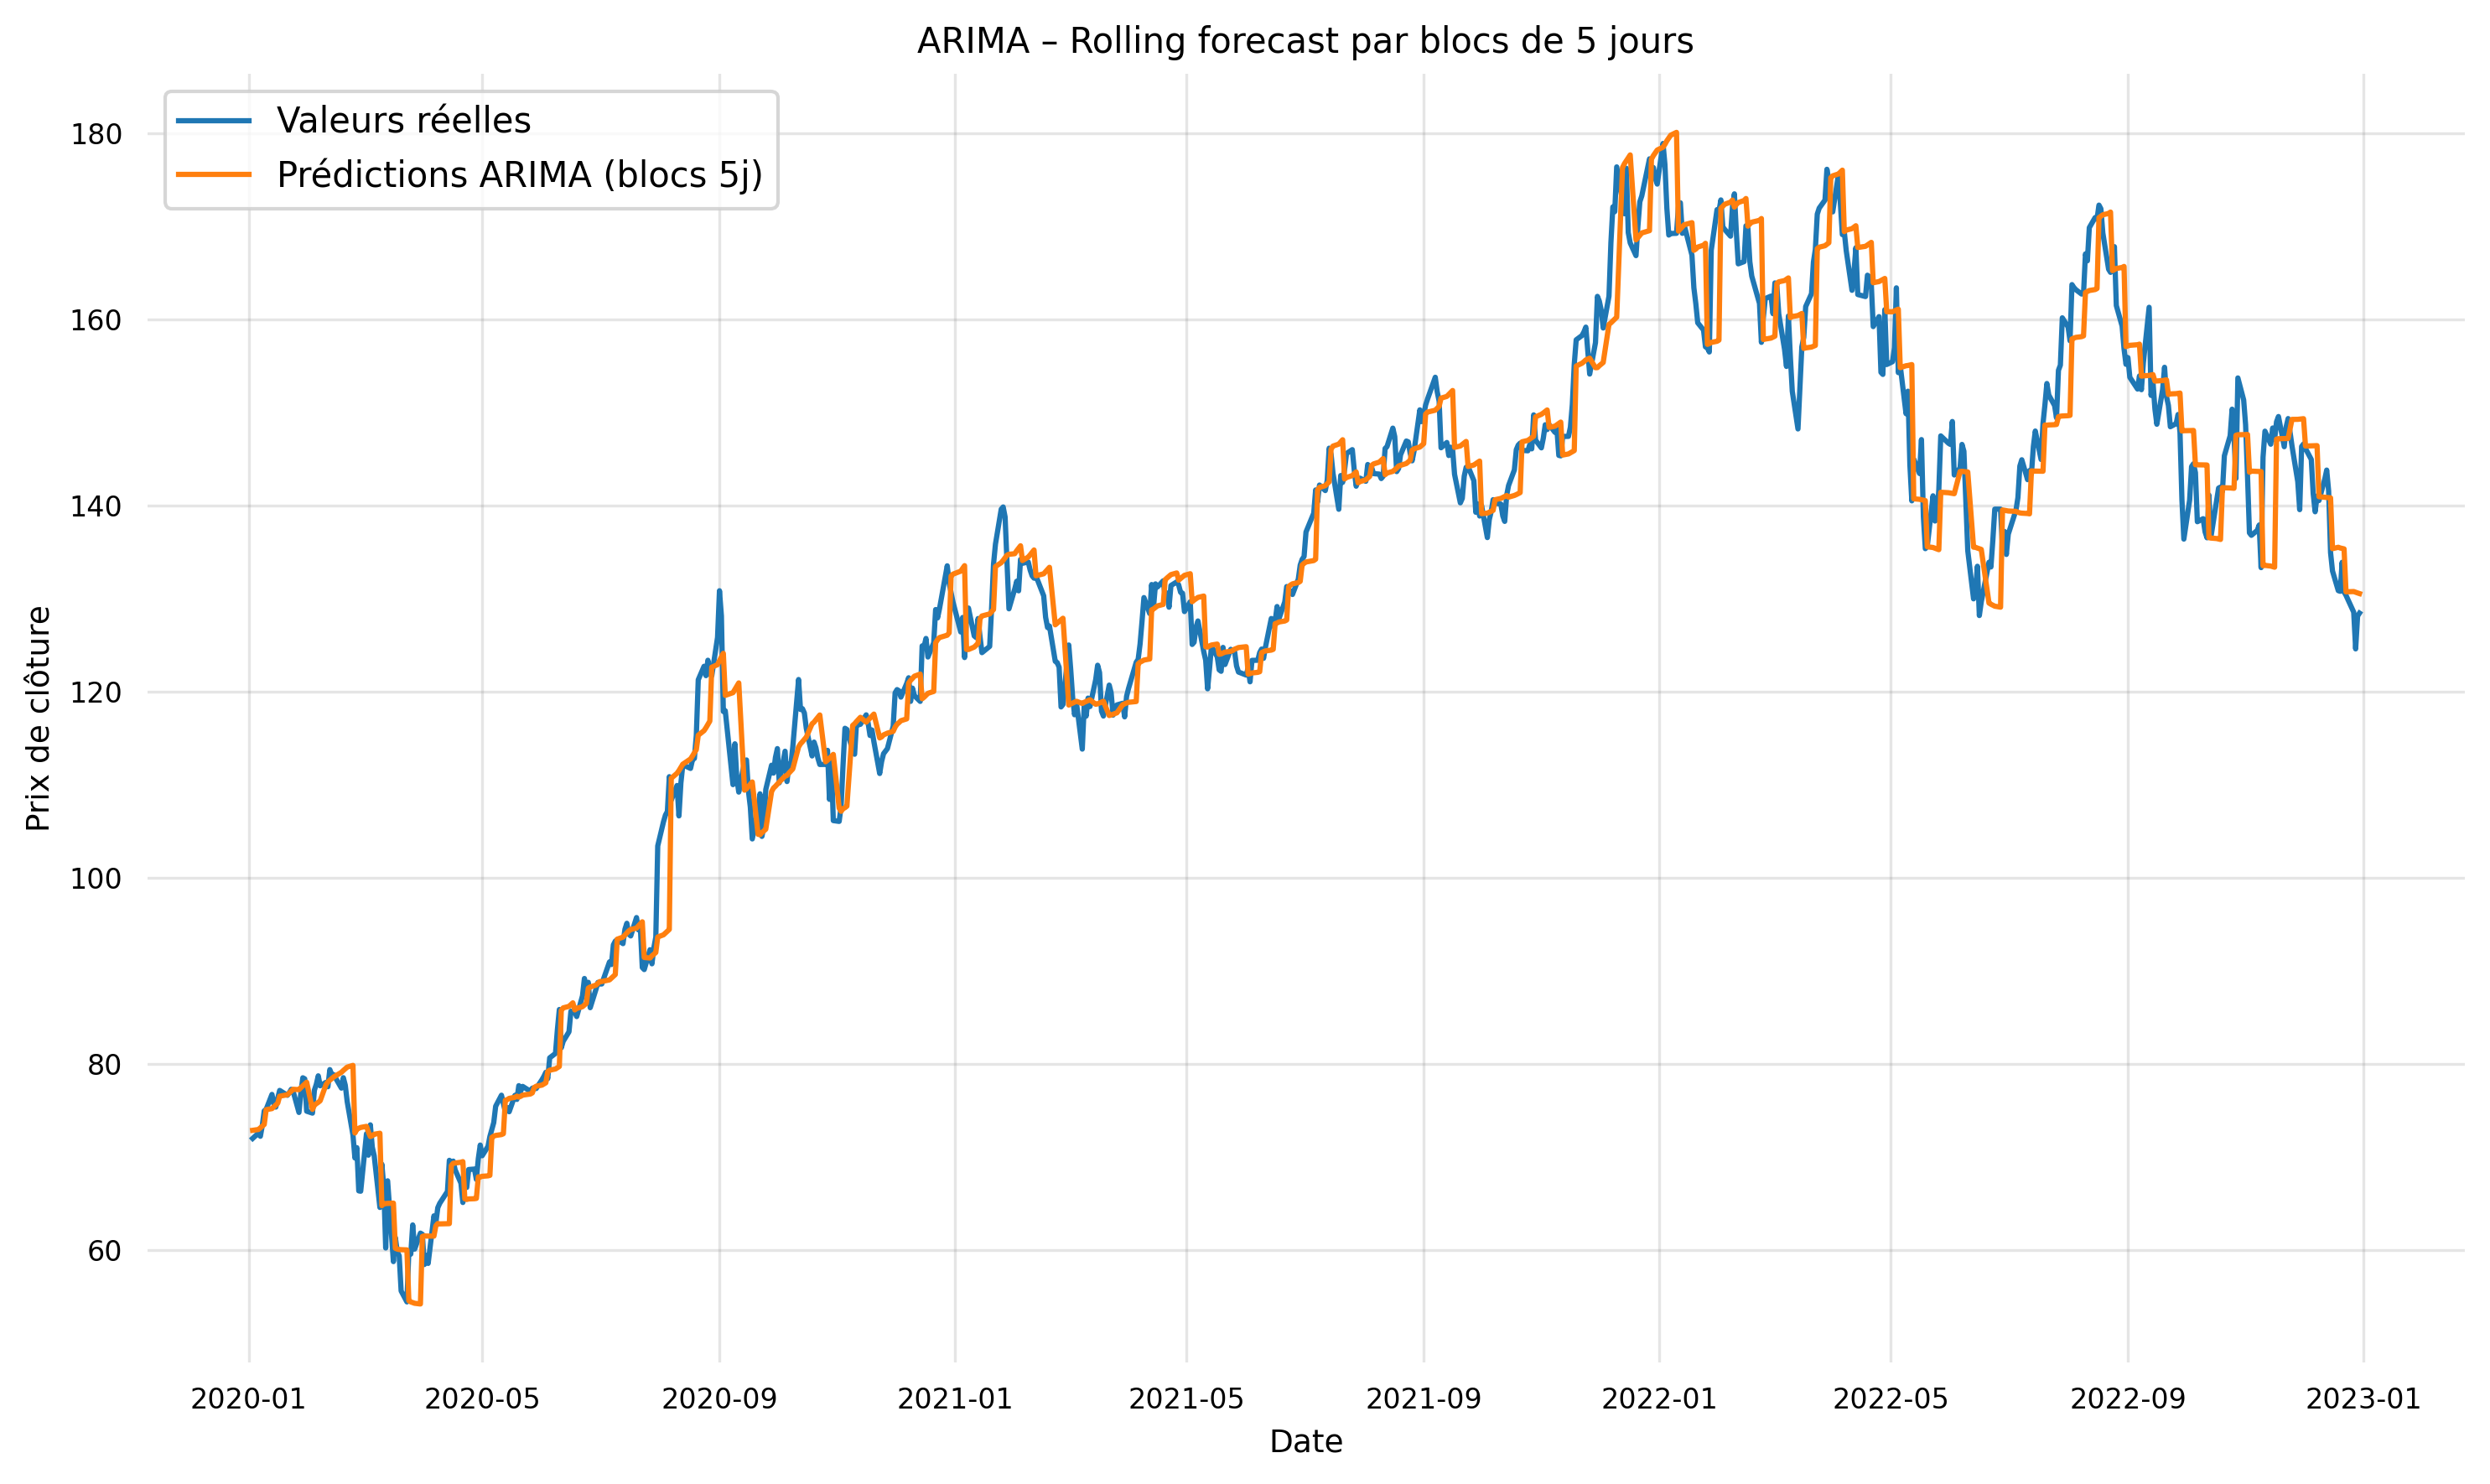

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

def smape_kun(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) * 200. / (np.abs(y_pred) + np.abs(y_true)))

# 1. Préparation des données
stock_prices = data.set_index('Date')['Close'].dropna()
n = len(stock_prices)
test_size = int(n * 0.3)
train_size = n - test_size

train_data = stock_prices.iloc[:train_size]
test_data  = stock_prices.iloc[train_size:]

# 2. Entraînement du modèle ARIMA avec sélection auto des ordres p,d,q ≤ 5
model = auto_arima(
    train_data,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    max_d=3,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)
model.fit(train_data)
print(model.summary())

# 3. Rolling forecast par blocs de 5 jours
block_size   = 5
predictions  = []

# on itère sur la série de test par pas de 5
for start in range(0, len(test_data), block_size):
    block = test_data.iloc[start:start+block_size]
    h = len(block)  # dernier bloc peut être plus petit que 5

    # on prédit h pas d'avance en un seul appel
    preds = model.predict(n_periods=h)
    predictions.extend(preds)

    # on met à jour le modèle (filtre) avec les vraies valeurs du bloc
    model.update(block.values)

# 4. Évaluation
pred_series = test_data.copy()
pred_series[:] = predictions

mse   = mean_squared_error(test_data, pred_series)
smape = smape_kun(test_data.values, pred_series.values)
print(f'MSE sur les 30% finaux : {mse:.3f}')
print(f'sMAPE sur les 30% finaux : {smape:.3f}%')

# 5. Affichage
plt.figure(figsize=(10,6))
plt.plot(test_data.index,       test_data.values,   label='Valeurs réelles')
plt.plot(test_data.index, pred_series.values, label=f'Prédictions ARIMA (blocs {block_size}j)')
plt.xlabel('Date')
plt.ylabel('Prix de clôture')
plt.title(f'ARIMA – Rolling forecast par blocs de {block_size} jours')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
data.head(20)

Date       Open       High        Low      Close  \
0  2013-01-02 00:00:00-05:00  16.814443  16.850269  16.444345  16.669014   
1  2013-01-03 00:00:00-05:00  16.634106  16.688452  16.425223  16.458620   
2  2013-01-04 00:00:00-05:00  16.302868  16.353267  15.964647  16.000170   
3  2013-01-07 00:00:00-05:00  15.848357  16.069990  15.641903  15.906043   
4  2013-01-08 00:00:00-05:00  16.067263  16.148630  15.825592  15.948855   
5  2013-01-09 00:00:00-05:00  15.863543  15.939749  15.665894  15.699595   
6  2013-01-10 00:00:00-05:00  16.047221  16.052382  15.651620  15.894204   
7  2013-01-11 00:00:00-05:00  15.817999  15.949157  15.757883  15.796746   
8  2013-01-14 00:00:00-05:00  15.261789  15.408129  15.135185  15.233555   
9  2013-01-15 00:00:00-05:00  15.128810  15.149759  14.675826  14.752943   
10 2013-01-16 00:00:00-05:00  15.017687  15.467028  14.952716  15.365318   
11 2013-01-17 00:00:00-05:00  15.493443  15.506803  15.242056  15.261789   
12 2013-01-18 00:00:00-05:00  15.135490  15.247825  15.071125  15.180425   
13 2013-01-22 00:00:00-05:00  15.318869  15.419666  15.078108  15.325245   
14 2013-01-23 00:00:00-05:00  15.447896  15.635526  15.325239  15.605773   
15 2013-01-24 00:00:00-05:00  13.965989  14.139957  13.669970  13.677562   
16 2013-01-25 00:00:00-05:00  13.713688  13.851526  13.206965  13.355126   
17 2013-01-28 00:00:00-05:00  13.292887  13.759836  13.233076  13.657216   
18 2013-01-29 00:00:00-05:00  13.920450  13.972064  13.726747  13.913466   
19 2013-01-30 00:00:00-05:00  13.874909  14.044931  13.799008  13.869748   

        Volume  Dividends  Stock Splits  Volatility    Return  Log_Return  
0    560518000        0.0           0.0    0.405924       NaN         NaN  
1    352965200        0.0           0.0    0.263229 -0.012622   -0.012702  
2    594333600        0.0           0.0    0.388620 -0.027855   -0.028250  
3    484156400        0.0           0.0    0.428087 -0.005883   -0.005900  
4    458707200        0.0           0.0    0.323039  0.002692    0.002688  
5    407604400        0.0           0.0    0.273855 -0.015629   -0.015752  
6    601146000        0.0           0.0    0.400763  0.012396    0.012320  
7    350506800        0.0           0.0    0.191274 -0.006132   -0.006151  
8    734207600        0.0           0.0    0.272944 -0.035652   -0.036303  
9    876772400        0.0           0.0    0.473934 -0.031550   -0.032058  
10   690804800        0.0           0.0    0.514312  0.041509    0.040670  
11   453678400        0.0           0.0    0.264746 -0.006738   -0.006761  
12   472922800        0.0           0.0    0.176700 -0.005331   -0.005346  
13   461546400        0.0           0.0    0.341559  0.009540    0.009495  
14   861509600        0.0           0.0    0.310288  0.018305    0.018139  
15  1460852400        0.0           0.0    0.469987 -0.123558   -0.131884  
16  1208026400        0.0           0.0    0.644560 -0.023574   -0.023856  
17   785517600        0.0           0.0    0.526760  0.022620    0.022368  
18   571158000        0.0           0.0    0.245316  0.018763    0.018589  
19   417155200        0.0           0.0    0.245923 -0.003142   -0.003147

In [12]:
data

Date        Open        High         Low  \
0    2013-01-02 00:00:00-05:00   16.814443   16.850269   16.444345   
1    2013-01-03 00:00:00-05:00   16.634106   16.688452   16.425223   
2    2013-01-04 00:00:00-05:00   16.302868   16.353267   15.964647   
3    2013-01-07 00:00:00-05:00   15.848357   16.069990   15.641903   
4    2013-01-08 00:00:00-05:00   16.067263   16.148630   15.825592   
...                        ...         ...         ...         ...   
2513 2022-12-23 00:00:00-05:00  129.415299  130.898059  128.150012   
2514 2022-12-27 00:00:00-05:00  129.869997  129.899651  127.240566   
2515 2022-12-28 00:00:00-05:00  128.179661  129.524031  124.423341   
2516 2022-12-29 00:00:00-05:00  126.518963  128.980342  126.261956   
2517 2022-12-30 00:00:00-05:00  126.934157  128.456450  125.965417   

           Close     Volume  Dividends  Stock Splits  Volatility    Return  \
0      16.669014  560518000        0.0           0.0    0.405924       NaN   
1      16.458620  352965200        0.0           0.0    0.263229 -0.012622   
2      16.000170  594333600        0.0           0.0    0.388620 -0.027855   
3      15.906043  484156400        0.0           0.0    0.428087 -0.005883   
4      15.948855  458707200        0.0           0.0    0.323039  0.002692   
...          ...        ...        ...           ...         ...       ...   
2513  130.344498   63814900        0.0           0.0    2.748047 -0.002798   
2514  128.535507   69007800        0.0           0.0    2.659085 -0.013879   
2515  124.591385   85438400        0.0           0.0    5.100691 -0.030685   
2516  128.120346   75703700        0.0           0.0    2.718386  0.028324   
2517  128.436676   77034200        0.0           0.0    2.491034  0.002469   

      Log_Return  
0            NaN  
1      -0.012702  
2      -0.028250  
3      -0.005900  
4       0.002688  
...          ...  
2513   -0.002802  
2514   -0.013976  
2515   -0.031166  
2516    0.027931  
2517    0.002466  

[2518 rows x 11 columns]

In [18]:
for i in range(100, len(stock_prices) - 1):
    window = stock_prices.iloc[i - 100:i].values
    target = int(stock_prices.iloc[i + 1] > 0)
    print(int(stock_prices.iloc[i + 1] > 0))

1
0
1
0
0
0
1
0
0
0
1
0
1
0
0
0
0
0
1
0
0
1
1
1
1
0
0
1
0
1
0
1
1
1
1
0
1
0
1
0
1
1
1
0
1
1
1
0
0
0
0
1
1
1
0
1
1
0
1
1
0
1
0
1
1
0
1
1
0
1
1
0
0
1
0
0
1
1
1
0
1
0
0
1
0
0
1
1
0
0
1
0
1
1
1
1
1
1
1
1
1
0
1
1
0
1
0
1
0
0
1
0
0
0
1
0
1
1
1
0
0
1
0
1
0
1
1
1
1
0
1
0
1
0
1
0
0
0
0
1
0
0
0
1
1
0
0
0
0
1
0
0
1
0
1
0
0
1
1
1
0
0
1
1
1
0
1
0
0
0
1
1
1
1
1
1
1
1
0
1
0
1
0
0
0
1
0
0
1
0
1
1
1
0
0
1
1
1
0
0
1
1
0
0
1
1
1
0
0
0
0
1
1
0
0
0
0
1
0
0
1
0
1
1
1
1
0
1
1
1
0
0
1
1
1
0
0
0
0
1
1
1
0
1
1
1
1
1
1
1
0
1
0
0
1
1
1
0
1
1
0
0
0
1
0
1
0
0
0
0
1
1
1
1
1
0
1
1
0
1
0
1
1
0
0
0
1
0
1
1
0
1
1
0
0
0
1
0
0
0
0
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
0
1
0
0
1
1
1
0
0
1
1
0
1
1
0
0
1
0
1
0
1
0
0
0
1
1
0
0
0
0
0
1
1
1
1
1
1
0
1
1
0
1
1
0
1
1
1
0
1
1
1
1
0
1
0
1
1
1
0
1
0
0
0
1
0
0
0
1
0
0
0
0
0
1
1
0
1
0
0
1
0
0
0
0
0
1
1
1
1
0
1
0
0
0
1
1
1
1
1
0
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
0
0
1
0
1
1
0
0
1
1
0
0
1
0
1
1
1
0
0
1
0
0
1
0
1
0
0
1
1
0
0
1
1
0
0
1
0
0
1
0
1
1
1
1
0
0
0
1
0
0
0
1
1
0
0
1
1
0
1
0
0
1
1


In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid

features_df = data.set_index('Date')[['Log_Return']].dropna()

def build_dataset(features_df, window_size):
    X = []
    y = []

    for i in range(window_size, len(features_df) - 1):
        # Concatène toutes les colonnes sur la fenêtre
        window_values = features_df.iloc[i - window_size:i].values.flatten()
        target = int(features_df['Log_Return'].iloc[i + 1] > 0)
        X.append(window_values)
        y.append(target)

    return np.array(X), np.array(y)

param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto']
}

results = []

window_sizes = [100, 150, 200, 250, 300]

for window_size in window_sizes:
    X, y = build_dataset(features_df, window_size)

    for params in ParameterGrid(param_grid):
        y_true = []
        y_pred = []

        for t in range(window_size, len(X) - 1):
            X_train = X[t - window_size:t]
            y_train = y[t - window_size:t]
            X_test = X[t].reshape(1, -1)
            y_test = y[t]

            if len(np.unique(y_train)) < 2:
                continue

            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('svc', SVC(kernel='rbf', class_weight='balanced'))
            ])
            pipeline.set_params(**params)
            pipeline.fit(X_train, y_train)
            y_hat = pipeline.predict(X_test)[0]

            y_true.append(y_test)
            y_pred.append(y_hat)

        if len(y_true) == 0:
            continue

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        report = classification_report(y_true, y_pred, digits=3, output_dict=True)
        recall = recall_score(y_true, y_pred)

        results.append({
            'window_size': window_size,
            'C': params['svc__C'],
            'gamma': params['svc__gamma'],
            'accuracy': acc,
            'recall': recall,
            'f1_score': f1,
            'precision_0': report['0']['precision'],
            'precision_1': report['1']['precision'],
            'recall_0': report['0']['recall'],
            'recall_1': report['1']['recall'],
            'f1_0': report['0']['f1-score'],
            'f1_1': report['1']['f1-score'],
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score', ascending=False)

In [34]:
results_df.to_excel('svm_results.xlsx', index=False)

In [42]:
features_df = data.set_index('Date')[['Log_Return']].dropna()

param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto']
}

window_sizes = [100, 150, 200, 250, 300]

results_df = rolling_svm_pipeline(
    features_df=features_df,
    window_sizes=window_sizes,
    param_grid=param_grid
)

display(results_df)


NameError: name 'rolling_svm_pipeline' is not defined